In [1]:
import xarray as xr
import numpy as np
import rioxarray  # Import rioxarray for GeoTIFF export
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
import os

# Get the current working directory (optional)
current_directory = os.getcwd()
print(f"Current directory: {current_directory}")

# Define the new directory path
new_directory = "I:/loca2/gen_use"  # Replace with your desired path

# Change the directory
try:
    os.chdir(new_directory)
    print(f"Successfully changed directory to: {os.getcwd()}")
except FileNotFoundError:
    print(f"Error: The directory '{new_directory}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Current directory: C:\Users\Ben
Successfully changed directory to: I:\loca2\gen_use


In [ ]:
# - ACCESS CM2 - Pct Precip on VWD / Total Precip

In [72]:
import xarray as xr
# Optional: For setting up a Dask client for better monitoring and control
# from dask.distributed import Client

def calculate_extreme_precipitation_sum_dask(
    pr_file_path,
    percentile_file_path,
    pr_variable_name='pr',
    percentile_variable_name='pr95', # Changed default to pr95 as per typical naming
    pr_chunks={'time': 'auto'},      # Dask chunks for precipitation data
    percentile_chunks={}             # Dask chunks for percentile data (often smaller, {} or 'auto' is fine)
    ):
    """
    Calculates the total precipitation from days where daily precipitation
    exceeds the 95th percentile at each lat/lon location, using Dask for out-of-core computation.

    Args:
        pr_file_path (str): Path to the NetCDF file containing daily precipitation data.
        percentile_file_path (str): Path to the NetCDF file containing the 95th percentile
                                     precipitation data.
        pr_variable_name (str, optional): Name of the precipitation variable in pr_file_path.
                                          Defaults to 'pr'.
        percentile_variable_name (str, optional): Name of the 95th percentile variable
                                                in percentile_file_path. Defaults to 'pr95'.
        pr_chunks (dict, optional): Chunking dictionary for the precipitation data.
                                   Defaults to {'time': 'auto'}.
        percentile_chunks (dict, optional): Chunking dictionary for the percentile data.
                                           Defaults to {}.

    Returns:
        xarray.DataArray: A Dask-backed DataArray containing the sum of extreme precipitation
                          at each lat/lon. Computation is triggered when writing to disk or
                          explicitly calling .compute() or .load().
                          Returns None if an error occurs.
    """
    try:
        # Open the precipitation and percentile datasets with Dask chunks
        # This makes xarray use Dask arrays, enabling out-of-core computation
        ds_pr = xr.open_dataset(pr_file_path, chunks=pr_chunks)
        ds_percentile = xr.open_dataset(percentile_file_path, chunks=percentile_chunks)

        # Extract the precipitation data and the 95th percentile data
        # Operations will now build a Dask graph
        daily_pr = ds_pr[pr_variable_name] * 86400 # This multiplication is also lazy
        percentile_95 = ds_percentile[percentile_variable_name]

        # Ensure that the percentile data can be broadcasted to the daily data.
        # If percentile_95 is small, you could .load() it into memory here
        # to potentially speed up the comparison, but it's often fine as a Dask array.
        # e.g., if ds_percentile.nbytes < some_threshold: percentile_95 = percentile_95.load()

        if 'time' in percentile_95.dims and percentile_95.sizes['time'] == 1:
            percentile_95 = percentile_95.squeeze('time', drop=True)
        elif 'time' in percentile_95.dims and percentile_95.sizes['time'] > 1:
            print("Warning: Percentile data appears to have a time dimension > 1. "
                  "This usually means it's a daily varying percentile. "
                  "Ensure this is the intended behavior. "
                  "If it's a single percentile map, it should not have a time dimension or be of size 1.")

        # Identify days where daily precipitation is above the 95th percentile
        extreme_days_mask = daily_pr > percentile_95 # Lazy operation

        # Use the mask to select only the precipitation values on extreme days
        extreme_pr = daily_pr.where(extreme_days_mask) # Lazy operation

        # Sum the precipitation from these extreme days along the 'time' dimension
        # skipna=True is important. This is still a lazy Dask operation.
        total_extreme_pr = extreme_pr.sum(dim='time', skipna=True)

        # It's good practice to give the output DataArray a name
        total_extreme_pr.name = "total_extreme_precipitation"
        total_extreme_pr.attrs['long_name'] = 'Total precipitation from days > 95th percentile (Dask)'
        if 'units' in daily_pr.attrs:
            # Assuming units of daily_pr after multiplication are mm/day equivalent
             total_extreme_pr.attrs['units'] = daily_pr.attrs.get('units_after_scaling', 'mm') # or appropriate unit
        else:
            total_extreme_pr.attrs['units'] = 'mm' # Placeholder


        # Datasets can be closed. Dask operations on arrays will still work if the data
        # needed for computation has been described in the task graph.
        # However, ensure computations that need to read metadata or re-read data chunks
        # are defined before closing if not using .persist() or .compute() earlier.
        # For simple sequential operations like this, closing here is usually fine.
        ds_pr.close()
        ds_percentile.close()

        return total_extreme_pr

    except FileNotFoundError:
        print(f"Error: One or both NetCDF files not found.")
        print(f"Precipitation file: {pr_file_path}")
        print(f"Percentile file: {percentile_file_path}")
        return None
    except KeyError as e:
        print(f"Error: Variable not found in NetCDF file. Details: {e}")
        print("Please ensure 'pr_variable_name' and 'percentile_variable_name' are correct.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # Optional: Initialize a Dask client to monitor computations
    # client = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB') # Customize as needed
    # print(f"Dask dashboard link: {client.dashboard_link}")

    # --- Configuration ---
    precipitation_filepath = 'pr.ACCESS-CM2.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc'
    percentile_filepath = 'VCP_FLOOD_PR_95pct_1950-2014_VWD_ACCESS.nc'

    precip_var_name = 'pr'
    # The user's original main block explicitly uses 'pr' for the percentile variable name.
    # The function default is 'pr95', but this will override it.
    percentile_var_name = 'pr'

    # Dask chunking configuration (tune based on your data and memory)
    # 'auto' often works well. For time series, chunking time is common.
    # If lat/lon are very large, you might chunk them too e.g., {'time': 100, 'lat': 10, 'lon': 10}
    precip_chunks_config = {'time': 'auto'} # Let Dask/xarray decide chunking for time dimension
    percentile_chunks_config = {} # For smaller percentile files, default chunking or no chunking is often fine.
                                   # Or use 'auto' if it also could be large.

    # --- Calculation ---
    print("Starting calculation with Dask...")
    extreme_precipitation_sum = calculate_extreme_precipitation_sum_dask(
        precipitation_filepath,
        percentile_filepath,
        pr_variable_name=precip_var_name,
        percentile_variable_name=percentile_var_name,
        pr_chunks=precip_chunks_config,
        percentile_chunks=percentile_chunks_config
    )

    # --- Output ---
    if extreme_precipitation_sum is not None:
        print("\nSuccessfully defined Dask computation for the sum of precipitation on extreme days.")
        print("The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().")
        print(extreme_precipitation_sum) # This will show the Dask array structure, not values

        # --- Save the result to a new NetCDF file ---
        # This is where Dask will perform the actual computation and write to disk.
        output_filepath = 'VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2015-2044_ACCESS.nc'
        print(f"\nAttempting to save results to: {output_filepath}")
        try:
            # When saving, Dask computes the result and writes it.
            # For very large outputs, ensure you have disk space.
            # You can also specify encoding for compression, etc.
            extreme_precipitation_sum.to_netcdf(output_filepath)
            print(f"Results successfully saved to: {output_filepath}")
        except Exception as e:
            print(f"\nError saving results to NetCDF: {e}")
            print("This error might have occurred during Dask computation or file writing.")

    # Optional: Close the Dask client if you initialized one
    # if 'client' in locals():
    # client.close()

Starting calculation with Dask...

Successfully defined Dask computation for the sum of precipitation on extreme days.
The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().
<xarray.DataArray 'total_extreme_precipitation' (lat: 495, lon: 559)> Size: 2MB
dask.array<sum-aggregate, shape=(495, 559), dtype=float64, chunksize=(495, 559), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B ...
Attributes:
    long_name:  Total precipitation from days > 95th percentile (Dask)
    units:      mm

Attempting to save results to: VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2015-2044_ACCESS.nc
Results successfully saved to: VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2015-2044_ACCESS.nc


In [74]:
def calculate_total_precipitation_dask(
    pr_file_path,
    pr_variable_name='pr',
    pr_chunks={'time': 'auto'}
    ):
    """
    Calculates the total precipitation at each lat/lon location,
    using Dask for out-of-core computation.

    Args:
        pr_file_path (str): Path to the NetCDF file containing daily precipitation data.
        pr_variable_name (str, optional): Name of the precipitation variable in pr_file_path.
                                          Defaults to 'pr'.
        pr_chunks (dict, optional): Chunking dictionary for the precipitation data.
                                    Defaults to {'time': 'auto'}.

    Returns:
        xarray.DataArray: A Dask-backed DataArray containing the sum of precipitation
                          at each lat/lon. Computation is triggered when writing to disk or
                          explicitly calling .compute() or .load().
                          Returns None if an error occurs.
    """
    try:
        # Open the precipitation dataset with Dask chunks
        ds_pr = xr.open_dataset(pr_file_path, chunks=pr_chunks)

        # Extract the precipitation data
        # Operations will now build a Dask graph
        daily_pr = ds_pr[pr_variable_name]

        # Optional: If your precipitation data is not already in mm/day
        # and needs conversion (e.g., from kg m-2 s-1), apply it here.
        # For example, if original units are kg m-2 s-1 (flux)
        # daily_pr_mm_day = daily_pr * 86400 # Convert to mm/day
        # If it's already in mm/day or a similar daily total, no conversion needed.
        # For this example, we'll assume daily_pr is already in appropriate daily units (e.g., mm)
        # or if it was flux, the user would handle the conversion as needed.
        # The original code had `* 86400`, so we'll keep that behavior for now
        # if the user expects it. If the input 'pr' is already daily totals,
        # this multiplication would be incorrect.
        # Let's assume the multiplication is to convert from flux to total daily amount.
        daily_pr_converted = daily_pr * 86400 # This multiplication is also lazy
        daily_pr_converted.attrs['units_after_scaling'] = 'mm' # Example unit after scaling

        # Sum the precipitation along the 'time' dimension
        # skipna=True is important. This is still a lazy Dask operation.
        total_pr = daily_pr_converted.sum(dim='time', skipna=True)

        # It's good practice to give the output DataArray a name and attributes
        total_pr.name = "total_precipitation"
        total_pr.attrs['long_name'] = 'Total precipitation (Dask)'
        if 'units_after_scaling' in daily_pr_converted.attrs:
             total_pr.attrs['units'] = daily_pr_converted.attrs['units_after_scaling']
        elif 'units' in daily_pr.attrs:
            total_pr.attrs['units'] = daily_pr.attrs['units'] # Or sum of daily units
        else:
            total_pr.attrs['units'] = 'mm' # Placeholder

        ds_pr.close()

        return total_pr

    except FileNotFoundError:
        print(f"Error: Precipitation NetCDF file not found.")
        print(f"Precipitation file: {pr_file_path}")
        return None
    except KeyError as e:
        print(f"Error: Variable '{pr_variable_name}' not found in NetCDF file. Details: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # Optional: Initialize a Dask client to monitor computations
    # client = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB') # Customize as needed
    # print(f"Dask dashboard link: {client.dashboard_link}")

    # --- Configuration ---
    precipitation_filepath = 'pr.ACCESS-CM2.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc'
    precip_var_name = 'pr'

    # Dask chunking configuration
    precip_chunks_config = {'time': 'auto'}

    # --- Calculation ---
    print("Starting calculation of total precipitation with Dask...")
    total_precipitation_sum = calculate_total_precipitation_dask(
        precipitation_filepath,
        pr_variable_name=precip_var_name,
        pr_chunks=precip_chunks_config
    )

    # --- Output ---
    if total_precipitation_sum is not None:
        print("\nSuccessfully defined Dask computation for the total precipitation.")
        print("The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().")
        print(total_precipitation_sum)

        # --- Save the result to a new NetCDF file ---
        output_filepath = 'VCP_FLOOD_PR_95pct_VWDTotalPrecip_2015-2044_ACCESS.nc' # Changed output filename
        print(f"\nAttempting to save results to: {output_filepath}")
        try:
            total_precipitation_sum.to_netcdf(output_filepath)
            print(f"Results successfully saved to: {output_filepath}")
        except Exception as e:
            print(f"\nError saving results to NetCDF: {e}")
            print("This error might have occurred during Dask computation or file writing.")

    # Optional: Close the Dask client if you initialized one
    # if 'client' in locals() and client: # Check if client exists and is not None
    #     client.close()

Starting calculation of total precipitation with Dask...

Successfully defined Dask computation for the total precipitation.
The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().
<xarray.DataArray 'total_precipitation' (lat: 495, lon: 559)> Size: 2MB
dask.array<sum-aggregate, shape=(495, 559), dtype=float64, chunksize=(495, 559), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon      (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
Attributes:
    long_name:  Total precipitation (Dask)
    units:      mm

Attempting to save results to: VCP_FLOOD_PR_95pct_VWDTotalPrecip_2015-2044_ACCESS.nc
Results successfully saved to: VCP_FLOOD_PR_95pct_VWDTotalPrecip_2015-2044_ACCESS.nc


In [78]:
def multiply_and_divide_netcdfs(ext_filepath, tot_filepath, output_filepath,
                                ext_var_name='pr', tot_var_name='pr'):
    """
    Opens ext.nc, multiplies its data variable by 100,
    opens tot.nc, and divides the result by tot.nc's data variable.
    Saves the final result to output_filepath.

    Args:
        ext_filepath (str): Path to the 'ext.nc' NetCDF file.
        tot_filepath (str): Path to the 'tot.nc' NetCDF file.
        output_filepath (str): Path to save the resulting NetCDF file.
        ext_var_name (str, optional): Name of the variable in ext.nc.
                                      If None, uses the first data variable.
        tot_var_name (str, optional): Name of the variable in tot.nc.
                                      If None, uses the first data variable.

    Returns:
        xarray.DataArray: The resulting DataArray, or None if an error occurs.
    """
    try:
        # Open the datasets
        ds_ext = xr.open_dataset(ext_filepath)
        ds_tot = xr.open_dataset(tot_filepath)

        # Determine variable names if not provided
        if ext_var_name is None:
            ext_var_name = get_first_data_variable_name(ds_ext)
            print(f"Using inferred variable '{ext_var_name}' from '{ext_filepath}'")
        if tot_var_name is None:
            tot_var_name = get_first_data_variable_name(ds_tot)
            print(f"Using inferred variable '{tot_var_name}' from '{tot_filepath}'")

        # Extract the DataArrays
        ext_data = ds_ext[ext_var_name]
        tot_data = ds_tot[tot_var_name]

        # Perform the calculation: (ext_data * 100) / tot_data
        print(f"\nPerforming operation: ({ext_var_name} * 100) / {tot_var_name}")
        
        scaled_ext_data = ext_data * 100
        result_data = scaled_ext_data / tot_data

        # Handle potential division by zero explicitly if you want something other than inf/NaN
        # For example, to set results to NaN where tot_data is zero:
        # result_data = xr.where(tot_data == 0, np.nan, scaled_ext_data / tot_data)
        # Xarray by default will produce `inf` or `NaN` which is often acceptable.

        # Assign a name and attributes to the result for clarity in the output file
        result_data.name = f"{ext_var_name}_div_by_{tot_var_name}_scaled"
        result_data.attrs['long_name'] = (f"({ext_var_name} * 100) / {tot_var_name}")
        result_data.attrs['units'] = f"({ext_data.attrs.get('units', 'unknown')} * 100) / {tot_data.attrs.get('units', 'unknown')}"
        result_data.attrs['operation_description'] = (
            f"Data from variable '{ext_var_name}' in '{ext_filepath}' was multiplied by 100, "
            f"then divided by data from variable '{tot_var_name}' in '{tot_filepath}'."
        )


        # Save the result to a new NetCDF file
        result_data.to_netcdf(output_filepath)
        print(f"\nResult successfully saved to: {output_filepath}")

        # Close the datasets
        ds_ext.close()
        ds_tot.close()

        return result_data

    except FileNotFoundError as e:
        print(f"Error: File not found. Details: {e}")
        return None
    except KeyError as e:
        print(f"Error: Variable not found in NetCDF file. Details: {e}")
        print("Please ensure 'ext_var_name' and 'tot_var_name' are correct if you specified them.")
        return None
    except ValueError as e: # For issues like no data variables
        print(f"Error: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # --- Configuration ---
    # Replace with the actual paths to your files
    ext_netcdf_file = 'VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2015-2044_ACCESS.nc'
    tot_netcdf_file = 'VCP_FLOOD_PR_95pct_VWDTotalPrecip_2015-2044_ACCESS.nc'
    output_netcdf_file = 'VCP_FLOOD_PctExtreme95_01A-1_2015-2044_ACCESS.nc'

    # Optional: Specify variable names if you know them and want to be explicit,
    # or if the files have multiple data variables and you don't want the first one.
    # If set to None, the script will try to use the first data variable found.
    ext_variable = 'total_extreme_precipitation'  # e.g., 'precipitation_flux' or 'extreme_sum'
    tot_variable = 'total_precipitation'  # e.g., 'total_precipitation'

    # --- Perform Calculation ---
    calculated_result = multiply_and_divide_netcdfs(
        ext_netcdf_file,
        tot_netcdf_file,
        output_netcdf_file,
        ext_var_name=ext_variable,
        tot_var_name=tot_variable
    )

    if calculated_result is not None:
        print("\n--- Result DataArray ---")
        print(calculated_result)
        # You can further analyze or plot 'calculated_result' here if needed
        # For example:
        # import matplotlib.pyplot as plt
        # if 'lat' in calculated_result.dims and 'lon' in calculated_result.dims:
        #     if len(calculated_result.dims) == 2: # Simple 2D plot
        #         calculated_result.plot()
        #         plt.show()
        #     elif 'time' in calculated_result.dims and calculated_result.sizes['time'] > 0: # Plot first time step of 3D data
        #         calculated_result.isel(time=0).plot()
        #         plt.show()


Performing operation: (total_extreme_precipitation * 100) / total_precipitation

Result successfully saved to: VCP_FLOOD_PctExtreme95_01A-1_2015-2044_ACCESS.nc

--- Result DataArray ---
<xarray.DataArray 'total_extreme_precipitation_div_by_total_precipitation_scaled' (
                                                                                   lat: 495,
                                                                                   lon: 559)> Size: 2MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B ...
Attributes:
    long_name:              (total_extreme_pr

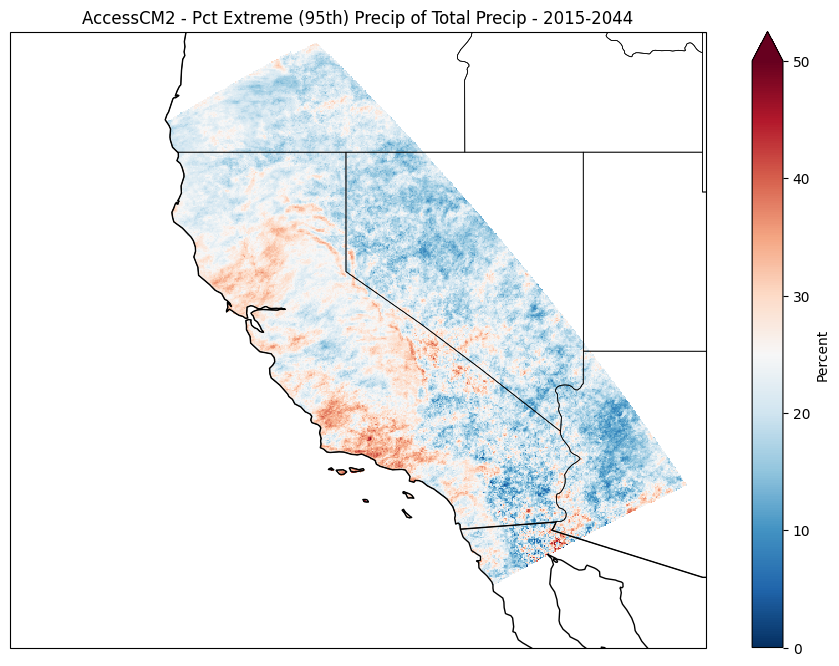

In [86]:
def map_99(netcdf_file, variable_name="total_extreme_precipitation_div_by_total_precipitation_scaled", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the 99th Percentile for PR (1950-2014) from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the pr values.
        variable_name (str): Name of the variable to plot. Defaults to "pr".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmax=50, cbar_kwargs={'label': 'Percent'})

        plt.title("AccessCM2 - Pct Extreme (95th) Precip of Total Precip - 2015-2044")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_FLOOD_PctExtreme95_01A-1_2015-2044_ACCESS.nc"  # Path to the NetCDF file with the tasmax difference

map_99(netcdf_file_path)

In [88]:
import xarray as xr
# Optional: For setting up a Dask client for better monitoring and control
# from dask.distributed import Client

def calculate_extreme_precipitation_sum_dask(
    pr_file_path,
    percentile_file_path,
    pr_variable_name='pr',
    percentile_variable_name='pr95', # Changed default to pr95 as per typical naming
    pr_chunks={'time': 'auto'},      # Dask chunks for precipitation data
    percentile_chunks={}             # Dask chunks for percentile data (often smaller, {} or 'auto' is fine)
    ):
    """
    Calculates the total precipitation from days where daily precipitation
    exceeds the 95th percentile at each lat/lon location, using Dask for out-of-core computation.

    Args:
        pr_file_path (str): Path to the NetCDF file containing daily precipitation data.
        percentile_file_path (str): Path to the NetCDF file containing the 95th percentile
                                     precipitation data.
        pr_variable_name (str, optional): Name of the precipitation variable in pr_file_path.
                                          Defaults to 'pr'.
        percentile_variable_name (str, optional): Name of the 95th percentile variable
                                                in percentile_file_path. Defaults to 'pr95'.
        pr_chunks (dict, optional): Chunking dictionary for the precipitation data.
                                   Defaults to {'time': 'auto'}.
        percentile_chunks (dict, optional): Chunking dictionary for the percentile data.
                                           Defaults to {}.

    Returns:
        xarray.DataArray: A Dask-backed DataArray containing the sum of extreme precipitation
                          at each lat/lon. Computation is triggered when writing to disk or
                          explicitly calling .compute() or .load().
                          Returns None if an error occurs.
    """
    try:
        # Open the precipitation and percentile datasets with Dask chunks
        # This makes xarray use Dask arrays, enabling out-of-core computation
        ds_pr = xr.open_dataset(pr_file_path, chunks=pr_chunks)
        ds_percentile = xr.open_dataset(percentile_file_path, chunks=percentile_chunks)

        # Extract the precipitation data and the 95th percentile data
        # Operations will now build a Dask graph
        daily_pr = ds_pr[pr_variable_name] * 86400 # This multiplication is also lazy
        percentile_95 = ds_percentile[percentile_variable_name]

        # Ensure that the percentile data can be broadcasted to the daily data.
        # If percentile_95 is small, you could .load() it into memory here
        # to potentially speed up the comparison, but it's often fine as a Dask array.
        # e.g., if ds_percentile.nbytes < some_threshold: percentile_95 = percentile_95.load()

        if 'time' in percentile_95.dims and percentile_95.sizes['time'] == 1:
            percentile_95 = percentile_95.squeeze('time', drop=True)
        elif 'time' in percentile_95.dims and percentile_95.sizes['time'] > 1:
            print("Warning: Percentile data appears to have a time dimension > 1. "
                  "This usually means it's a daily varying percentile. "
                  "Ensure this is the intended behavior. "
                  "If it's a single percentile map, it should not have a time dimension or be of size 1.")

        # Identify days where daily precipitation is above the 95th percentile
        extreme_days_mask = daily_pr > percentile_95 # Lazy operation

        # Use the mask to select only the precipitation values on extreme days
        extreme_pr = daily_pr.where(extreme_days_mask) # Lazy operation

        # Sum the precipitation from these extreme days along the 'time' dimension
        # skipna=True is important. This is still a lazy Dask operation.
        total_extreme_pr = extreme_pr.sum(dim='time', skipna=True)

        # It's good practice to give the output DataArray a name
        total_extreme_pr.name = "total_extreme_precipitation"
        total_extreme_pr.attrs['long_name'] = 'Total precipitation from days > 95th percentile (Dask)'
        if 'units' in daily_pr.attrs:
            # Assuming units of daily_pr after multiplication are mm/day equivalent
             total_extreme_pr.attrs['units'] = daily_pr.attrs.get('units_after_scaling', 'mm') # or appropriate unit
        else:
            total_extreme_pr.attrs['units'] = 'mm' # Placeholder


        # Datasets can be closed. Dask operations on arrays will still work if the data
        # needed for computation has been described in the task graph.
        # However, ensure computations that need to read metadata or re-read data chunks
        # are defined before closing if not using .persist() or .compute() earlier.
        # For simple sequential operations like this, closing here is usually fine.
        ds_pr.close()
        ds_percentile.close()

        return total_extreme_pr

    except FileNotFoundError:
        print(f"Error: One or both NetCDF files not found.")
        print(f"Precipitation file: {pr_file_path}")
        print(f"Percentile file: {percentile_file_path}")
        return None
    except KeyError as e:
        print(f"Error: Variable not found in NetCDF file. Details: {e}")
        print("Please ensure 'pr_variable_name' and 'percentile_variable_name' are correct.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # Optional: Initialize a Dask client to monitor computations
    # client = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB') # Customize as needed
    # print(f"Dask dashboard link: {client.dashboard_link}")

    # --- Configuration ---
    precipitation_filepath = 'pr.ACCESS-CM2.ssp370.r1i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc'
    percentile_filepath = 'VCP_FLOOD_PR_95pct_1950-2014_VWD_ACCESS.nc'

    precip_var_name = 'pr'
    # The user's original main block explicitly uses 'pr' for the percentile variable name.
    # The function default is 'pr95', but this will override it.
    percentile_var_name = 'pr'

    # Dask chunking configuration (tune based on your data and memory)
    # 'auto' often works well. For time series, chunking time is common.
    # If lat/lon are very large, you might chunk them too e.g., {'time': 100, 'lat': 10, 'lon': 10}
    precip_chunks_config = {'time': 'auto'} # Let Dask/xarray decide chunking for time dimension
    percentile_chunks_config = {} # For smaller percentile files, default chunking or no chunking is often fine.
                                   # Or use 'auto' if it also could be large.

    # --- Calculation ---
    print("Starting calculation with Dask...")
    extreme_precipitation_sum = calculate_extreme_precipitation_sum_dask(
        precipitation_filepath,
        percentile_filepath,
        pr_variable_name=precip_var_name,
        percentile_variable_name=percentile_var_name,
        pr_chunks=precip_chunks_config,
        percentile_chunks=percentile_chunks_config
    )

    # --- Output ---
    if extreme_precipitation_sum is not None:
        print("\nSuccessfully defined Dask computation for the sum of precipitation on extreme days.")
        print("The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().")
        print(extreme_precipitation_sum) # This will show the Dask array structure, not values

        # --- Save the result to a new NetCDF file ---
        # This is where Dask will perform the actual computation and write to disk.
        output_filepath = 'VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2045-2074_ACCESS.nc'
        print(f"\nAttempting to save results to: {output_filepath}")
        try:
            # When saving, Dask computes the result and writes it.
            # For very large outputs, ensure you have disk space.
            # You can also specify encoding for compression, etc.
            extreme_precipitation_sum.to_netcdf(output_filepath)
            print(f"Results successfully saved to: {output_filepath}")
        except Exception as e:
            print(f"\nError saving results to NetCDF: {e}")
            print("This error might have occurred during Dask computation or file writing.")

    # Optional: Close the Dask client if you initialized one
    # if 'client' in locals():
    # client.close()

Starting calculation with Dask...

Successfully defined Dask computation for the sum of precipitation on extreme days.
The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().
<xarray.DataArray 'total_extreme_precipitation' (lat: 495, lon: 559)> Size: 2MB
dask.array<sum-aggregate, shape=(495, 559), dtype=float64, chunksize=(495, 559), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B ...
Attributes:
    long_name:  Total precipitation from days > 95th percentile (Dask)
    units:      mm

Attempting to save results to: VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2045-2074_ACCESS.nc
Results successfully saved to: VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2045-2074_ACCESS.nc


In [90]:
def calculate_total_precipitation_dask(
    pr_file_path,
    pr_variable_name='pr',
    pr_chunks={'time': 'auto'}
    ):
    """
    Calculates the total precipitation at each lat/lon location,
    using Dask for out-of-core computation.

    Args:
        pr_file_path (str): Path to the NetCDF file containing daily precipitation data.
        pr_variable_name (str, optional): Name of the precipitation variable in pr_file_path.
                                          Defaults to 'pr'.
        pr_chunks (dict, optional): Chunking dictionary for the precipitation data.
                                    Defaults to {'time': 'auto'}.

    Returns:
        xarray.DataArray: A Dask-backed DataArray containing the sum of precipitation
                          at each lat/lon. Computation is triggered when writing to disk or
                          explicitly calling .compute() or .load().
                          Returns None if an error occurs.
    """
    try:
        # Open the precipitation dataset with Dask chunks
        ds_pr = xr.open_dataset(pr_file_path, chunks=pr_chunks)

        # Extract the precipitation data
        # Operations will now build a Dask graph
        daily_pr = ds_pr[pr_variable_name]

        # Optional: If your precipitation data is not already in mm/day
        # and needs conversion (e.g., from kg m-2 s-1), apply it here.
        # For example, if original units are kg m-2 s-1 (flux)
        # daily_pr_mm_day = daily_pr * 86400 # Convert to mm/day
        # If it's already in mm/day or a similar daily total, no conversion needed.
        # For this example, we'll assume daily_pr is already in appropriate daily units (e.g., mm)
        # or if it was flux, the user would handle the conversion as needed.
        # The original code had `* 86400`, so we'll keep that behavior for now
        # if the user expects it. If the input 'pr' is already daily totals,
        # this multiplication would be incorrect.
        # Let's assume the multiplication is to convert from flux to total daily amount.
        daily_pr_converted = daily_pr * 86400 # This multiplication is also lazy
        daily_pr_converted.attrs['units_after_scaling'] = 'mm' # Example unit after scaling

        # Sum the precipitation along the 'time' dimension
        # skipna=True is important. This is still a lazy Dask operation.
        total_pr = daily_pr_converted.sum(dim='time', skipna=True)

        # It's good practice to give the output DataArray a name and attributes
        total_pr.name = "total_precipitation"
        total_pr.attrs['long_name'] = 'Total precipitation (Dask)'
        if 'units_after_scaling' in daily_pr_converted.attrs:
             total_pr.attrs['units'] = daily_pr_converted.attrs['units_after_scaling']
        elif 'units' in daily_pr.attrs:
            total_pr.attrs['units'] = daily_pr.attrs['units'] # Or sum of daily units
        else:
            total_pr.attrs['units'] = 'mm' # Placeholder

        ds_pr.close()

        return total_pr

    except FileNotFoundError:
        print(f"Error: Precipitation NetCDF file not found.")
        print(f"Precipitation file: {pr_file_path}")
        return None
    except KeyError as e:
        print(f"Error: Variable '{pr_variable_name}' not found in NetCDF file. Details: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # Optional: Initialize a Dask client to monitor computations
    # client = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB') # Customize as needed
    # print(f"Dask dashboard link: {client.dashboard_link}")

    # --- Configuration ---
    precipitation_filepath = 'pr.ACCESS-CM2.ssp370.r1i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc'
    precip_var_name = 'pr'

    # Dask chunking configuration
    precip_chunks_config = {'time': 'auto'}

    # --- Calculation ---
    print("Starting calculation of total precipitation with Dask...")
    total_precipitation_sum = calculate_total_precipitation_dask(
        precipitation_filepath,
        pr_variable_name=precip_var_name,
        pr_chunks=precip_chunks_config
    )

    # --- Output ---
    if total_precipitation_sum is not None:
        print("\nSuccessfully defined Dask computation for the total precipitation.")
        print("The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().")
        print(total_precipitation_sum)

        # --- Save the result to a new NetCDF file ---
        output_filepath = 'VCP_FLOOD_PR_95pct_VWDTotalPrecip_2045-2074_ACCESS.nc' # Changed output filename
        print(f"\nAttempting to save results to: {output_filepath}")
        try:
            total_precipitation_sum.to_netcdf(output_filepath)
            print(f"Results successfully saved to: {output_filepath}")
        except Exception as e:
            print(f"\nError saving results to NetCDF: {e}")
            print("This error might have occurred during Dask computation or file writing.")

    # Optional: Close the Dask client if you initialized one
    # if 'client' in locals() and client: # Check if client exists and is not None
    #     client.close()

Starting calculation of total precipitation with Dask...

Successfully defined Dask computation for the total precipitation.
The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().
<xarray.DataArray 'total_precipitation' (lat: 495, lon: 559)> Size: 2MB
dask.array<sum-aggregate, shape=(495, 559), dtype=float64, chunksize=(495, 559), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon      (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
Attributes:
    long_name:  Total precipitation (Dask)
    units:      mm

Attempting to save results to: VCP_FLOOD_PR_95pct_VWDTotalPrecip_2045-2074_ACCESS.nc
Results successfully saved to: VCP_FLOOD_PR_95pct_VWDTotalPrecip_2045-2074_ACCESS.nc


In [94]:
def multiply_and_divide_netcdfs(ext_filepath, tot_filepath, output_filepath,
                                ext_var_name='pr', tot_var_name='pr'):
    """
    Opens ext.nc, multiplies its data variable by 100,
    opens tot.nc, and divides the result by tot.nc's data variable.
    Saves the final result to output_filepath.

    Args:
        ext_filepath (str): Path to the 'ext.nc' NetCDF file.
        tot_filepath (str): Path to the 'tot.nc' NetCDF file.
        output_filepath (str): Path to save the resulting NetCDF file.
        ext_var_name (str, optional): Name of the variable in ext.nc.
                                      If None, uses the first data variable.
        tot_var_name (str, optional): Name of the variable in tot.nc.
                                      If None, uses the first data variable.

    Returns:
        xarray.DataArray: The resulting DataArray, or None if an error occurs.
    """
    try:
        # Open the datasets
        ds_ext = xr.open_dataset(ext_filepath)
        ds_tot = xr.open_dataset(tot_filepath)

        # Determine variable names if not provided
        if ext_var_name is None:
            ext_var_name = get_first_data_variable_name(ds_ext)
            print(f"Using inferred variable '{ext_var_name}' from '{ext_filepath}'")
        if tot_var_name is None:
            tot_var_name = get_first_data_variable_name(ds_tot)
            print(f"Using inferred variable '{tot_var_name}' from '{tot_filepath}'")

        # Extract the DataArrays
        ext_data = ds_ext[ext_var_name]
        tot_data = ds_tot[tot_var_name]

        # Perform the calculation: (ext_data * 100) / tot_data
        print(f"\nPerforming operation: ({ext_var_name} * 100) / {tot_var_name}")
        
        scaled_ext_data = ext_data * 100
        result_data = scaled_ext_data / tot_data

        # Handle potential division by zero explicitly if you want something other than inf/NaN
        # For example, to set results to NaN where tot_data is zero:
        # result_data = xr.where(tot_data == 0, np.nan, scaled_ext_data / tot_data)
        # Xarray by default will produce `inf` or `NaN` which is often acceptable.

        # Assign a name and attributes to the result for clarity in the output file
        result_data.name = f"{ext_var_name}_div_by_{tot_var_name}_scaled"
        result_data.attrs['long_name'] = (f"({ext_var_name} * 100) / {tot_var_name}")
        result_data.attrs['units'] = f"({ext_data.attrs.get('units', 'unknown')} * 100) / {tot_data.attrs.get('units', 'unknown')}"
        result_data.attrs['operation_description'] = (
            f"Data from variable '{ext_var_name}' in '{ext_filepath}' was multiplied by 100, "
            f"then divided by data from variable '{tot_var_name}' in '{tot_filepath}'."
        )


        # Save the result to a new NetCDF file
        result_data.to_netcdf(output_filepath)
        print(f"\nResult successfully saved to: {output_filepath}")

        # Close the datasets
        ds_ext.close()
        ds_tot.close()

        return result_data

    except FileNotFoundError as e:
        print(f"Error: File not found. Details: {e}")
        return None
    except KeyError as e:
        print(f"Error: Variable not found in NetCDF file. Details: {e}")
        print("Please ensure 'ext_var_name' and 'tot_var_name' are correct if you specified them.")
        return None
    except ValueError as e: # For issues like no data variables
        print(f"Error: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # --- Configuration ---
    # Replace with the actual paths to your files
    ext_netcdf_file = 'VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2045-2074_ACCESS.nc'
    tot_netcdf_file = 'VCP_FLOOD_PR_95pct_VWDTotalPrecip_2045-2074_ACCESS.nc'
    output_netcdf_file = 'VCP_FLOOD_PctExtreme95_01B-1_2045-2074_ACCESS.nc'

    # Optional: Specify variable names if you know them and want to be explicit,
    # or if the files have multiple data variables and you don't want the first one.
    # If set to None, the script will try to use the first data variable found.
    ext_variable = 'total_extreme_precipitation'  # e.g., 'precipitation_flux' or 'extreme_sum'
    tot_variable = 'total_precipitation'  # e.g., 'total_precipitation'

    # --- Perform Calculation ---
    calculated_result = multiply_and_divide_netcdfs(
        ext_netcdf_file,
        tot_netcdf_file,
        output_netcdf_file,
        ext_var_name=ext_variable,
        tot_var_name=tot_variable
    )

    if calculated_result is not None:
        print("\n--- Result DataArray ---")
        print(calculated_result)
        # You can further analyze or plot 'calculated_result' here if needed
        # For example:
        # import matplotlib.pyplot as plt
        # if 'lat' in calculated_result.dims and 'lon' in calculated_result.dims:
        #     if len(calculated_result.dims) == 2: # Simple 2D plot
        #         calculated_result.plot()
        #         plt.show()
        #     elif 'time' in calculated_result.dims and calculated_result.sizes['time'] > 0: # Plot first time step of 3D data
        #         calculated_result.isel(time=0).plot()
        #         plt.show()


Performing operation: (total_extreme_precipitation * 100) / total_precipitation

Result successfully saved to: VCP_FLOOD_PctExtreme95_01B-1_2045-2074_ACCESS.nc

--- Result DataArray ---
<xarray.DataArray 'total_extreme_precipitation_div_by_total_precipitation_scaled' (
                                                                                   lat: 495,
                                                                                   lon: 559)> Size: 2MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B ...
Attributes:
    long_name:              (total_extreme_pr

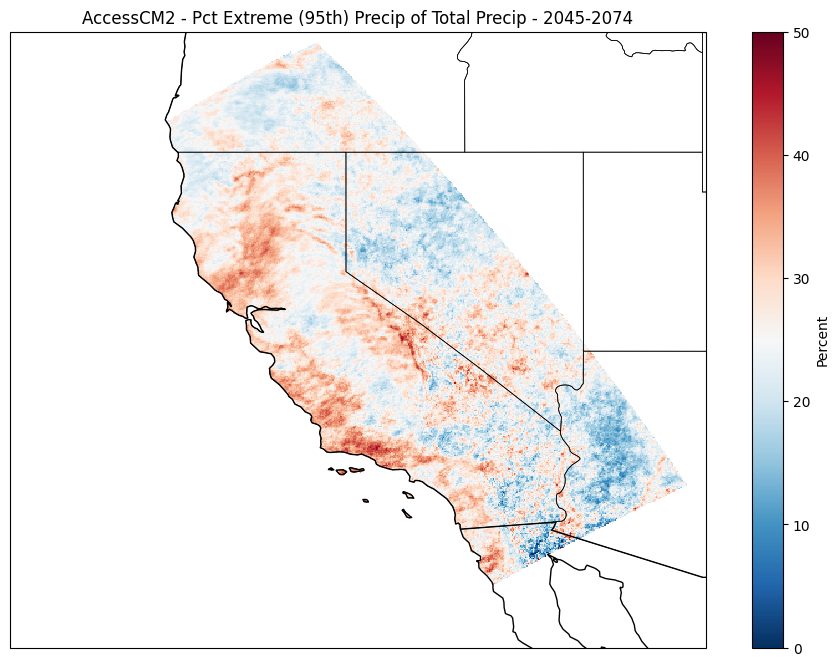

In [96]:
def map_99(netcdf_file, variable_name="total_extreme_precipitation_div_by_total_precipitation_scaled", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the 99th Percentile for PR (1950-2014) from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the pr values.
        variable_name (str): Name of the variable to plot. Defaults to "pr".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmax=50, cbar_kwargs={'label': 'Percent'})

        plt.title("AccessCM2 - Pct Extreme (95th) Precip of Total Precip - 2045-2074")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_FLOOD_PctExtreme95_01B-1_2045-2074_ACCESS.nc"  # Path to the NetCDF file with the tasmax difference

map_99(netcdf_file_path)

In [ ]:
# - Earth3 - Pct Precip on VWD / Total Precip

In [122]:
import xarray as xr
# Optional: For setting up a Dask client for better monitoring and control
# from dask.distributed import Client

def calculate_extreme_precipitation_sum_dask(
    pr_file_path,
    percentile_file_path,
    pr_variable_name='pr',
    percentile_variable_name='pr95', # Changed default to pr95 as per typical naming
    pr_chunks={'time': 'auto'},      # Dask chunks for precipitation data
    percentile_chunks={}             # Dask chunks for percentile data (often smaller, {} or 'auto' is fine)
    ):
    """
    Calculates the total precipitation from days where daily precipitation
    exceeds the 95th percentile at each lat/lon location, using Dask for out-of-core computation.

    Args:
        pr_file_path (str): Path to the NetCDF file containing daily precipitation data.
        percentile_file_path (str): Path to the NetCDF file containing the 95th percentile
                                     precipitation data.
        pr_variable_name (str, optional): Name of the precipitation variable in pr_file_path.
                                          Defaults to 'pr'.
        percentile_variable_name (str, optional): Name of the 95th percentile variable
                                                in percentile_file_path. Defaults to 'pr95'.
        pr_chunks (dict, optional): Chunking dictionary for the precipitation data.
                                   Defaults to {'time': 'auto'}.
        percentile_chunks (dict, optional): Chunking dictionary for the percentile data.
                                           Defaults to {}.

    Returns:
        xarray.DataArray: A Dask-backed DataArray containing the sum of extreme precipitation
                          at each lat/lon. Computation is triggered when writing to disk or
                          explicitly calling .compute() or .load().
                          Returns None if an error occurs.
    """
    try:
        # Open the precipitation and percentile datasets with Dask chunks
        # This makes xarray use Dask arrays, enabling out-of-core computation
        ds_pr = xr.open_dataset(pr_file_path, chunks=pr_chunks)
        ds_percentile = xr.open_dataset(percentile_file_path, chunks=percentile_chunks)

        # Extract the precipitation data and the 95th percentile data
        # Operations will now build a Dask graph
        daily_pr = ds_pr[pr_variable_name] * 86400 # This multiplication is also lazy
        percentile_95 = ds_percentile[percentile_variable_name]

        # Ensure that the percentile data can be broadcasted to the daily data.
        # If percentile_95 is small, you could .load() it into memory here
        # to potentially speed up the comparison, but it's often fine as a Dask array.
        # e.g., if ds_percentile.nbytes < some_threshold: percentile_95 = percentile_95.load()

        if 'time' in percentile_95.dims and percentile_95.sizes['time'] == 1:
            percentile_95 = percentile_95.squeeze('time', drop=True)
        elif 'time' in percentile_95.dims and percentile_95.sizes['time'] > 1:
            print("Warning: Percentile data appears to have a time dimension > 1. "
                  "This usually means it's a daily varying percentile. "
                  "Ensure this is the intended behavior. "
                  "If it's a single percentile map, it should not have a time dimension or be of size 1.")

        # Identify days where daily precipitation is above the 95th percentile
        extreme_days_mask = daily_pr > percentile_95 # Lazy operation

        # Use the mask to select only the precipitation values on extreme days
        extreme_pr = daily_pr.where(extreme_days_mask) # Lazy operation

        # Sum the precipitation from these extreme days along the 'time' dimension
        # skipna=True is important. This is still a lazy Dask operation.
        total_extreme_pr = extreme_pr.sum(dim='time', skipna=True)

        # It's good practice to give the output DataArray a name
        total_extreme_pr.name = "total_extreme_precipitation"
        total_extreme_pr.attrs['long_name'] = 'Total precipitation from days > 95th percentile (Dask)'
        if 'units' in daily_pr.attrs:
            # Assuming units of daily_pr after multiplication are mm/day equivalent
             total_extreme_pr.attrs['units'] = daily_pr.attrs.get('units_after_scaling', 'mm') # or appropriate unit
        else:
            total_extreme_pr.attrs['units'] = 'mm' # Placeholder


        # Datasets can be closed. Dask operations on arrays will still work if the data
        # needed for computation has been described in the task graph.
        # However, ensure computations that need to read metadata or re-read data chunks
        # are defined before closing if not using .persist() or .compute() earlier.
        # For simple sequential operations like this, closing here is usually fine.
        ds_pr.close()
        ds_percentile.close()

        return total_extreme_pr

    except FileNotFoundError:
        print(f"Error: One or both NetCDF files not found.")
        print(f"Precipitation file: {pr_file_path}")
        print(f"Percentile file: {percentile_file_path}")
        return None
    except KeyError as e:
        print(f"Error: Variable not found in NetCDF file. Details: {e}")
        print("Please ensure 'pr_variable_name' and 'percentile_variable_name' are correct.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # Optional: Initialize a Dask client to monitor computations
    # client = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB') # Customize as needed
    # print(f"Dask dashboard link: {client.dashboard_link}")

    # --- Configuration ---
    precipitation_filepath = 'pr.EC-Earth3.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc'
    percentile_filepath = 'VCP_FLOOD_PR_95pct_1950-2014_VWD_Earth3.nc'

    precip_var_name = 'pr'
    # The user's original main block explicitly uses 'pr' for the percentile variable name.
    # The function default is 'pr95', but this will override it.
    percentile_var_name = 'pr'

    # Dask chunking configuration (tune based on your data and memory)
    # 'auto' often works well. For time series, chunking time is common.
    # If lat/lon are very large, you might chunk them too e.g., {'time': 100, 'lat': 10, 'lon': 10}
    precip_chunks_config = {'time': 'auto'} # Let Dask/xarray decide chunking for time dimension
    percentile_chunks_config = {} # For smaller percentile files, default chunking or no chunking is often fine.
                                   # Or use 'auto' if it also could be large.

    # --- Calculation ---
    print("Starting calculation with Dask...")
    extreme_precipitation_sum = calculate_extreme_precipitation_sum_dask(
        precipitation_filepath,
        percentile_filepath,
        pr_variable_name=precip_var_name,
        percentile_variable_name=percentile_var_name,
        pr_chunks=precip_chunks_config,
        percentile_chunks=percentile_chunks_config
    )

    # --- Output ---
    if extreme_precipitation_sum is not None:
        print("\nSuccessfully defined Dask computation for the sum of precipitation on extreme days.")
        print("The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().")
        print(extreme_precipitation_sum) # This will show the Dask array structure, not values

        # --- Save the result to a new NetCDF file ---
        # This is where Dask will perform the actual computation and write to disk.
        output_filepath = 'VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2015-2044_Earth3.nc'
        print(f"\nAttempting to save results to: {output_filepath}")
        try:
            # When saving, Dask computes the result and writes it.
            # For very large outputs, ensure you have disk space.
            # You can also specify encoding for compression, etc.
            extreme_precipitation_sum.to_netcdf(output_filepath)
            print(f"Results successfully saved to: {output_filepath}")
        except Exception as e:
            print(f"\nError saving results to NetCDF: {e}")
            print("This error might have occurred during Dask computation or file writing.")

    # Optional: Close the Dask client if you initialized one
    # if 'client' in locals():
    # client.close()

Starting calculation with Dask...

Successfully defined Dask computation for the sum of precipitation on extreme days.
The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().
<xarray.DataArray 'total_extreme_precipitation' (lat: 495, lon: 559)> Size: 2MB
dask.array<sum-aggregate, shape=(495, 559), dtype=float64, chunksize=(495, 559), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B ...
Attributes:
    long_name:  Total precipitation from days > 95th percentile (Dask)
    units:      mm

Attempting to save results to: VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2015-2044_Earth3.nc
Results successfully saved to: VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2015-2044_Earth3.nc


In [123]:
def calculate_total_precipitation_dask(
    pr_file_path,
    pr_variable_name='pr',
    pr_chunks={'time': 'auto'}
    ):
    """
    Calculates the total precipitation at each lat/lon location,
    using Dask for out-of-core computation.

    Args:
        pr_file_path (str): Path to the NetCDF file containing daily precipitation data.
        pr_variable_name (str, optional): Name of the precipitation variable in pr_file_path.
                                          Defaults to 'pr'.
        pr_chunks (dict, optional): Chunking dictionary for the precipitation data.
                                    Defaults to {'time': 'auto'}.

    Returns:
        xarray.DataArray: A Dask-backed DataArray containing the sum of precipitation
                          at each lat/lon. Computation is triggered when writing to disk or
                          explicitly calling .compute() or .load().
                          Returns None if an error occurs.
    """
    try:
        # Open the precipitation dataset with Dask chunks
        ds_pr = xr.open_dataset(pr_file_path, chunks=pr_chunks)

        # Extract the precipitation data
        # Operations will now build a Dask graph
        daily_pr = ds_pr[pr_variable_name]

        # Optional: If your precipitation data is not already in mm/day
        # and needs conversion (e.g., from kg m-2 s-1), apply it here.
        # For example, if original units are kg m-2 s-1 (flux)
        # daily_pr_mm_day = daily_pr * 86400 # Convert to mm/day
        # If it's already in mm/day or a similar daily total, no conversion needed.
        # For this example, we'll assume daily_pr is already in appropriate daily units (e.g., mm)
        # or if it was flux, the user would handle the conversion as needed.
        # The original code had `* 86400`, so we'll keep that behavior for now
        # if the user expects it. If the input 'pr' is already daily totals,
        # this multiplication would be incorrect.
        # Let's assume the multiplication is to convert from flux to total daily amount.
        daily_pr_converted = daily_pr * 86400 # This multiplication is also lazy
        daily_pr_converted.attrs['units_after_scaling'] = 'mm' # Example unit after scaling

        # Sum the precipitation along the 'time' dimension
        # skipna=True is important. This is still a lazy Dask operation.
        total_pr = daily_pr_converted.sum(dim='time', skipna=True)

        # It's good practice to give the output DataArray a name and attributes
        total_pr.name = "total_precipitation"
        total_pr.attrs['long_name'] = 'Total precipitation (Dask)'
        if 'units_after_scaling' in daily_pr_converted.attrs:
             total_pr.attrs['units'] = daily_pr_converted.attrs['units_after_scaling']
        elif 'units' in daily_pr.attrs:
            total_pr.attrs['units'] = daily_pr.attrs['units'] # Or sum of daily units
        else:
            total_pr.attrs['units'] = 'mm' # Placeholder

        ds_pr.close()

        return total_pr

    except FileNotFoundError:
        print(f"Error: Precipitation NetCDF file not found.")
        print(f"Precipitation file: {pr_file_path}")
        return None
    except KeyError as e:
        print(f"Error: Variable '{pr_variable_name}' not found in NetCDF file. Details: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # Optional: Initialize a Dask client to monitor computations
    # client = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB') # Customize as needed
    # print(f"Dask dashboard link: {client.dashboard_link}")

    # --- Configuration ---
    precipitation_filepath = 'pr.EC-Earth3.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc'
    precip_var_name = 'pr'

    # Dask chunking configuration
    precip_chunks_config = {'time': 'auto'}

    # --- Calculation ---
    print("Starting calculation of total precipitation with Dask...")
    total_precipitation_sum = calculate_total_precipitation_dask(
        precipitation_filepath,
        pr_variable_name=precip_var_name,
        pr_chunks=precip_chunks_config
    )

    # --- Output ---
    if total_precipitation_sum is not None:
        print("\nSuccessfully defined Dask computation for the total precipitation.")
        print("The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().")
        print(total_precipitation_sum)

        # --- Save the result to a new NetCDF file ---
        output_filepath = 'VCP_FLOOD_PR_95pct_VWDTotalPrecip_2015-2044_Earth3.nc' # Changed output filename
        print(f"\nAttempting to save results to: {output_filepath}")
        try:
            total_precipitation_sum.to_netcdf(output_filepath)
            print(f"Results successfully saved to: {output_filepath}")
        except Exception as e:
            print(f"\nError saving results to NetCDF: {e}")
            print("This error might have occurred during Dask computation or file writing.")

    # Optional: Close the Dask client if you initialized one
    # if 'client' in locals() and client: # Check if client exists and is not None
    #     client.close()

Starting calculation of total precipitation with Dask...

Successfully defined Dask computation for the total precipitation.
The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().
<xarray.DataArray 'total_precipitation' (lat: 495, lon: 559)> Size: 2MB
dask.array<sum-aggregate, shape=(495, 559), dtype=float64, chunksize=(495, 559), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon      (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
Attributes:
    long_name:  Total precipitation (Dask)
    units:      mm

Attempting to save results to: VCP_FLOOD_PR_95pct_VWDTotalPrecip_2015-2044_Earth3.nc
Results successfully saved to: VCP_FLOOD_PR_95pct_VWDTotalPrecip_2015-2044_Earth3.nc


In [124]:
def multiply_and_divide_netcdfs(ext_filepath, tot_filepath, output_filepath,
                                ext_var_name='pr', tot_var_name='pr'):
    """
    Opens ext.nc, multiplies its data variable by 100,
    opens tot.nc, and divides the result by tot.nc's data variable.
    Saves the final result to output_filepath.

    Args:
        ext_filepath (str): Path to the 'ext.nc' NetCDF file.
        tot_filepath (str): Path to the 'tot.nc' NetCDF file.
        output_filepath (str): Path to save the resulting NetCDF file.
        ext_var_name (str, optional): Name of the variable in ext.nc.
                                      If None, uses the first data variable.
        tot_var_name (str, optional): Name of the variable in tot.nc.
                                      If None, uses the first data variable.

    Returns:
        xarray.DataArray: The resulting DataArray, or None if an error occurs.
    """
    try:
        # Open the datasets
        ds_ext = xr.open_dataset(ext_filepath)
        ds_tot = xr.open_dataset(tot_filepath)

        # Determine variable names if not provided
        if ext_var_name is None:
            ext_var_name = get_first_data_variable_name(ds_ext)
            print(f"Using inferred variable '{ext_var_name}' from '{ext_filepath}'")
        if tot_var_name is None:
            tot_var_name = get_first_data_variable_name(ds_tot)
            print(f"Using inferred variable '{tot_var_name}' from '{tot_filepath}'")

        # Extract the DataArrays
        ext_data = ds_ext[ext_var_name]
        tot_data = ds_tot[tot_var_name]

        # Perform the calculation: (ext_data * 100) / tot_data
        print(f"\nPerforming operation: ({ext_var_name} * 100) / {tot_var_name}")
        
        scaled_ext_data = ext_data * 100
        result_data = scaled_ext_data / tot_data

        # Handle potential division by zero explicitly if you want something other than inf/NaN
        # For example, to set results to NaN where tot_data is zero:
        # result_data = xr.where(tot_data == 0, np.nan, scaled_ext_data / tot_data)
        # Xarray by default will produce `inf` or `NaN` which is often acceptable.

        # Assign a name and attributes to the result for clarity in the output file
        result_data.name = f"{ext_var_name}_div_by_{tot_var_name}_scaled"
        result_data.attrs['long_name'] = (f"({ext_var_name} * 100) / {tot_var_name}")
        result_data.attrs['units'] = f"({ext_data.attrs.get('units', 'unknown')} * 100) / {tot_data.attrs.get('units', 'unknown')}"
        result_data.attrs['operation_description'] = (
            f"Data from variable '{ext_var_name}' in '{ext_filepath}' was multiplied by 100, "
            f"then divided by data from variable '{tot_var_name}' in '{tot_filepath}'."
        )


        # Save the result to a new NetCDF file
        result_data.to_netcdf(output_filepath)
        print(f"\nResult successfully saved to: {output_filepath}")

        # Close the datasets
        ds_ext.close()
        ds_tot.close()

        return result_data

    except FileNotFoundError as e:
        print(f"Error: File not found. Details: {e}")
        return None
    except KeyError as e:
        print(f"Error: Variable not found in NetCDF file. Details: {e}")
        print("Please ensure 'ext_var_name' and 'tot_var_name' are correct if you specified them.")
        return None
    except ValueError as e: # For issues like no data variables
        print(f"Error: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # --- Configuration ---
    # Replace with the actual paths to your files
    ext_netcdf_file = 'VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2015-2044_Earth3.nc'
    tot_netcdf_file = 'VCP_FLOOD_PR_95pct_VWDTotalPrecip_2015-2044_Earth3.nc'
    output_netcdf_file = 'VCP_FLOOD_PctExtreme95_01A-2_2015-2044_Earth3.nc'

    # Optional: Specify variable names if you know them and want to be explicit,
    # or if the files have multiple data variables and you don't want the first one.
    # If set to None, the script will try to use the first data variable found.
    ext_variable = 'total_extreme_precipitation'  # e.g., 'precipitation_flux' or 'extreme_sum'
    tot_variable = 'total_precipitation'  # e.g., 'total_precipitation'

    # --- Perform Calculation ---
    calculated_result = multiply_and_divide_netcdfs(
        ext_netcdf_file,
        tot_netcdf_file,
        output_netcdf_file,
        ext_var_name=ext_variable,
        tot_var_name=tot_variable
    )

    if calculated_result is not None:
        print("\n--- Result DataArray ---")
        print(calculated_result)
        # You can further analyze or plot 'calculated_result' here if needed
        # For example:
        # import matplotlib.pyplot as plt
        # if 'lat' in calculated_result.dims and 'lon' in calculated_result.dims:
        #     if len(calculated_result.dims) == 2: # Simple 2D plot
        #         calculated_result.plot()
        #         plt.show()
        #     elif 'time' in calculated_result.dims and calculated_result.sizes['time'] > 0: # Plot first time step of 3D data
        #         calculated_result.isel(time=0).plot()
        #         plt.show()


Performing operation: (total_extreme_precipitation * 100) / total_precipitation

Result successfully saved to: VCP_FLOOD_PctExtreme95_01A-2_2015-2044_Earth3.nc

--- Result DataArray ---
<xarray.DataArray 'total_extreme_precipitation_div_by_total_precipitation_scaled' (
                                                                                   lat: 495,
                                                                                   lon: 559)> Size: 2MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B ...
Attributes:
    long_name:              (total_extreme_pr

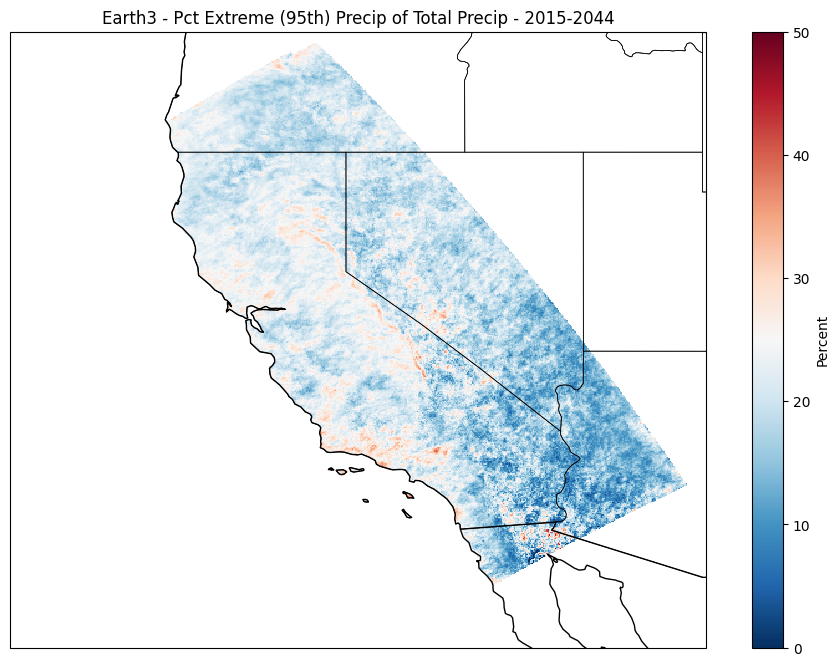

In [125]:
def map_99(netcdf_file, variable_name="total_extreme_precipitation_div_by_total_precipitation_scaled", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the 99th Percentile for PR (1950-2014) from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the pr values.
        variable_name (str): Name of the variable to plot. Defaults to "pr".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmax=50, cbar_kwargs={'label': 'Percent'})

        plt.title("Earth3 - Pct Extreme (95th) Precip of Total Precip - 2015-2044")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_FLOOD_PctExtreme95_01A-2_2015-2044_Earth3.nc"  # Path to the NetCDF file with the tasmax difference

map_99(netcdf_file_path)

In [110]:
import xarray as xr
# Optional: For setting up a Dask client for better monitoring and control
# from dask.distributed import Client

def calculate_extreme_precipitation_sum_dask(
    pr_file_path,
    percentile_file_path,
    pr_variable_name='pr',
    percentile_variable_name='pr95', # Changed default to pr95 as per typical naming
    pr_chunks={'time': 'auto'},      # Dask chunks for precipitation data
    percentile_chunks={}             # Dask chunks for percentile data (often smaller, {} or 'auto' is fine)
    ):
    """
    Calculates the total precipitation from days where daily precipitation
    exceeds the 95th percentile at each lat/lon location, using Dask for out-of-core computation.

    Args:
        pr_file_path (str): Path to the NetCDF file containing daily precipitation data.
        percentile_file_path (str): Path to the NetCDF file containing the 95th percentile
                                     precipitation data.
        pr_variable_name (str, optional): Name of the precipitation variable in pr_file_path.
                                          Defaults to 'pr'.
        percentile_variable_name (str, optional): Name of the 95th percentile variable
                                                in percentile_file_path. Defaults to 'pr95'.
        pr_chunks (dict, optional): Chunking dictionary for the precipitation data.
                                   Defaults to {'time': 'auto'}.
        percentile_chunks (dict, optional): Chunking dictionary for the percentile data.
                                           Defaults to {}.

    Returns:
        xarray.DataArray: A Dask-backed DataArray containing the sum of extreme precipitation
                          at each lat/lon. Computation is triggered when writing to disk or
                          explicitly calling .compute() or .load().
                          Returns None if an error occurs.
    """
    try:
        # Open the precipitation and percentile datasets with Dask chunks
        # This makes xarray use Dask arrays, enabling out-of-core computation
        ds_pr = xr.open_dataset(pr_file_path, chunks=pr_chunks)
        ds_percentile = xr.open_dataset(percentile_file_path, chunks=percentile_chunks)

        # Extract the precipitation data and the 95th percentile data
        # Operations will now build a Dask graph
        daily_pr = ds_pr[pr_variable_name] * 86400 # This multiplication is also lazy
        percentile_95 = ds_percentile[percentile_variable_name]

        # Ensure that the percentile data can be broadcasted to the daily data.
        # If percentile_95 is small, you could .load() it into memory here
        # to potentially speed up the comparison, but it's often fine as a Dask array.
        # e.g., if ds_percentile.nbytes < some_threshold: percentile_95 = percentile_95.load()

        if 'time' in percentile_95.dims and percentile_95.sizes['time'] == 1:
            percentile_95 = percentile_95.squeeze('time', drop=True)
        elif 'time' in percentile_95.dims and percentile_95.sizes['time'] > 1:
            print("Warning: Percentile data appears to have a time dimension > 1. "
                  "This usually means it's a daily varying percentile. "
                  "Ensure this is the intended behavior. "
                  "If it's a single percentile map, it should not have a time dimension or be of size 1.")

        # Identify days where daily precipitation is above the 95th percentile
        extreme_days_mask = daily_pr > percentile_95 # Lazy operation

        # Use the mask to select only the precipitation values on extreme days
        extreme_pr = daily_pr.where(extreme_days_mask) # Lazy operation

        # Sum the precipitation from these extreme days along the 'time' dimension
        # skipna=True is important. This is still a lazy Dask operation.
        total_extreme_pr = extreme_pr.sum(dim='time', skipna=True)

        # It's good practice to give the output DataArray a name
        total_extreme_pr.name = "total_extreme_precipitation"
        total_extreme_pr.attrs['long_name'] = 'Total precipitation from days > 95th percentile (Dask)'
        if 'units' in daily_pr.attrs:
            # Assuming units of daily_pr after multiplication are mm/day equivalent
             total_extreme_pr.attrs['units'] = daily_pr.attrs.get('units_after_scaling', 'mm') # or appropriate unit
        else:
            total_extreme_pr.attrs['units'] = 'mm' # Placeholder


        # Datasets can be closed. Dask operations on arrays will still work if the data
        # needed for computation has been described in the task graph.
        # However, ensure computations that need to read metadata or re-read data chunks
        # are defined before closing if not using .persist() or .compute() earlier.
        # For simple sequential operations like this, closing here is usually fine.
        ds_pr.close()
        ds_percentile.close()

        return total_extreme_pr

    except FileNotFoundError:
        print(f"Error: One or both NetCDF files not found.")
        print(f"Precipitation file: {pr_file_path}")
        print(f"Percentile file: {percentile_file_path}")
        return None
    except KeyError as e:
        print(f"Error: Variable not found in NetCDF file. Details: {e}")
        print("Please ensure 'pr_variable_name' and 'percentile_variable_name' are correct.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # Optional: Initialize a Dask client to monitor computations
    # client = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB') # Customize as needed
    # print(f"Dask dashboard link: {client.dashboard_link}")

    # --- Configuration ---
    precipitation_filepath = 'pr.EC-Earth3.ssp370.r1i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc'
    percentile_filepath = 'VCP_FLOOD_PR_95pct_1950-2014_VWD_Earth3.nc'

    precip_var_name = 'pr'
    # The user's original main block explicitly uses 'pr' for the percentile variable name.
    # The function default is 'pr95', but this will override it.
    percentile_var_name = 'pr'

    # Dask chunking configuration (tune based on your data and memory)
    # 'auto' often works well. For time series, chunking time is common.
    # If lat/lon are very large, you might chunk them too e.g., {'time': 100, 'lat': 10, 'lon': 10}
    precip_chunks_config = {'time': 'auto'} # Let Dask/xarray decide chunking for time dimension
    percentile_chunks_config = {} # For smaller percentile files, default chunking or no chunking is often fine.
                                   # Or use 'auto' if it also could be large.

    # --- Calculation ---
    print("Starting calculation with Dask...")
    extreme_precipitation_sum = calculate_extreme_precipitation_sum_dask(
        precipitation_filepath,
        percentile_filepath,
        pr_variable_name=precip_var_name,
        percentile_variable_name=percentile_var_name,
        pr_chunks=precip_chunks_config,
        percentile_chunks=percentile_chunks_config
    )

    # --- Output ---
    if extreme_precipitation_sum is not None:
        print("\nSuccessfully defined Dask computation for the sum of precipitation on extreme days.")
        print("The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().")
        print(extreme_precipitation_sum) # This will show the Dask array structure, not values

        # --- Save the result to a new NetCDF file ---
        # This is where Dask will perform the actual computation and write to disk.
        output_filepath = 'VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2045-2074_Earth3.nc'
        print(f"\nAttempting to save results to: {output_filepath}")
        try:
            # When saving, Dask computes the result and writes it.
            # For very large outputs, ensure you have disk space.
            # You can also specify encoding for compression, etc.
            extreme_precipitation_sum.to_netcdf(output_filepath)
            print(f"Results successfully saved to: {output_filepath}")
        except Exception as e:
            print(f"\nError saving results to NetCDF: {e}")
            print("This error might have occurred during Dask computation or file writing.")

    # Optional: Close the Dask client if you initialized one
    # if 'client' in locals():
    # client.close()

Starting calculation with Dask...

Successfully defined Dask computation for the sum of precipitation on extreme days.
The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().
<xarray.DataArray 'total_extreme_precipitation' (lat: 495, lon: 559)> Size: 2MB
dask.array<sum-aggregate, shape=(495, 559), dtype=float64, chunksize=(495, 559), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B ...
Attributes:
    long_name:  Total precipitation from days > 95th percentile (Dask)
    units:      mm

Attempting to save results to: VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2045-2074_Earth3.nc
Results successfully saved to: VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2045-2074_Earth3.nc


In [112]:
def calculate_total_precipitation_dask(
    pr_file_path,
    pr_variable_name='pr',
    pr_chunks={'time': 'auto'}
    ):
    """
    Calculates the total precipitation at each lat/lon location,
    using Dask for out-of-core computation.

    Args:
        pr_file_path (str): Path to the NetCDF file containing daily precipitation data.
        pr_variable_name (str, optional): Name of the precipitation variable in pr_file_path.
                                          Defaults to 'pr'.
        pr_chunks (dict, optional): Chunking dictionary for the precipitation data.
                                    Defaults to {'time': 'auto'}.

    Returns:
        xarray.DataArray: A Dask-backed DataArray containing the sum of precipitation
                          at each lat/lon. Computation is triggered when writing to disk or
                          explicitly calling .compute() or .load().
                          Returns None if an error occurs.
    """
    try:
        # Open the precipitation dataset with Dask chunks
        ds_pr = xr.open_dataset(pr_file_path, chunks=pr_chunks)

        # Extract the precipitation data
        # Operations will now build a Dask graph
        daily_pr = ds_pr[pr_variable_name]

        # Optional: If your precipitation data is not already in mm/day
        # and needs conversion (e.g., from kg m-2 s-1), apply it here.
        # For example, if original units are kg m-2 s-1 (flux)
        # daily_pr_mm_day = daily_pr * 86400 # Convert to mm/day
        # If it's already in mm/day or a similar daily total, no conversion needed.
        # For this example, we'll assume daily_pr is already in appropriate daily units (e.g., mm)
        # or if it was flux, the user would handle the conversion as needed.
        # The original code had `* 86400`, so we'll keep that behavior for now
        # if the user expects it. If the input 'pr' is already daily totals,
        # this multiplication would be incorrect.
        # Let's assume the multiplication is to convert from flux to total daily amount.
        daily_pr_converted = daily_pr * 86400 # This multiplication is also lazy
        daily_pr_converted.attrs['units_after_scaling'] = 'mm' # Example unit after scaling

        # Sum the precipitation along the 'time' dimension
        # skipna=True is important. This is still a lazy Dask operation.
        total_pr = daily_pr_converted.sum(dim='time', skipna=True)

        # It's good practice to give the output DataArray a name and attributes
        total_pr.name = "total_precipitation"
        total_pr.attrs['long_name'] = 'Total precipitation (Dask)'
        if 'units_after_scaling' in daily_pr_converted.attrs:
             total_pr.attrs['units'] = daily_pr_converted.attrs['units_after_scaling']
        elif 'units' in daily_pr.attrs:
            total_pr.attrs['units'] = daily_pr.attrs['units'] # Or sum of daily units
        else:
            total_pr.attrs['units'] = 'mm' # Placeholder

        ds_pr.close()

        return total_pr

    except FileNotFoundError:
        print(f"Error: Precipitation NetCDF file not found.")
        print(f"Precipitation file: {pr_file_path}")
        return None
    except KeyError as e:
        print(f"Error: Variable '{pr_variable_name}' not found in NetCDF file. Details: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # Optional: Initialize a Dask client to monitor computations
    # client = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB') # Customize as needed
    # print(f"Dask dashboard link: {client.dashboard_link}")

    # --- Configuration ---
    precipitation_filepath = 'pr.EC-Earth3.ssp370.r1i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc'
    precip_var_name = 'pr'

    # Dask chunking configuration
    precip_chunks_config = {'time': 'auto'}

    # --- Calculation ---
    print("Starting calculation of total precipitation with Dask...")
    total_precipitation_sum = calculate_total_precipitation_dask(
        precipitation_filepath,
        pr_variable_name=precip_var_name,
        pr_chunks=precip_chunks_config
    )

    # --- Output ---
    if total_precipitation_sum is not None:
        print("\nSuccessfully defined Dask computation for the total precipitation.")
        print("The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().")
        print(total_precipitation_sum)

        # --- Save the result to a new NetCDF file ---
        output_filepath = 'VCP_FLOOD_PR_95pct_VWDTotalPrecip_2045-2074_Earth3.nc' # Changed output filename
        print(f"\nAttempting to save results to: {output_filepath}")
        try:
            total_precipitation_sum.to_netcdf(output_filepath)
            print(f"Results successfully saved to: {output_filepath}")
        except Exception as e:
            print(f"\nError saving results to NetCDF: {e}")
            print("This error might have occurred during Dask computation or file writing.")

    # Optional: Close the Dask client if you initialized one
    # if 'client' in locals() and client: # Check if client exists and is not None
    #     client.close()

Starting calculation of total precipitation with Dask...

Successfully defined Dask computation for the total precipitation.
The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().
<xarray.DataArray 'total_precipitation' (lat: 495, lon: 559)> Size: 2MB
dask.array<sum-aggregate, shape=(495, 559), dtype=float64, chunksize=(495, 559), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon      (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
Attributes:
    long_name:  Total precipitation (Dask)
    units:      mm

Attempting to save results to: VCP_FLOOD_PR_95pct_VWDTotalPrecip_2045-2074_Earth3.nc
Results successfully saved to: VCP_FLOOD_PR_95pct_VWDTotalPrecip_2045-2074_Earth3.nc


In [116]:
def multiply_and_divide_netcdfs(ext_filepath, tot_filepath, output_filepath,
                                ext_var_name='pr', tot_var_name='pr'):
    """
    Opens ext.nc, multiplies its data variable by 100,
    opens tot.nc, and divides the result by tot.nc's data variable.
    Saves the final result to output_filepath.

    Args:
        ext_filepath (str): Path to the 'ext.nc' NetCDF file.
        tot_filepath (str): Path to the 'tot.nc' NetCDF file.
        output_filepath (str): Path to save the resulting NetCDF file.
        ext_var_name (str, optional): Name of the variable in ext.nc.
                                      If None, uses the first data variable.
        tot_var_name (str, optional): Name of the variable in tot.nc.
                                      If None, uses the first data variable.

    Returns:
        xarray.DataArray: The resulting DataArray, or None if an error occurs.
    """
    try:
        # Open the datasets
        ds_ext = xr.open_dataset(ext_filepath)
        ds_tot = xr.open_dataset(tot_filepath)

        # Determine variable names if not provided
        if ext_var_name is None:
            ext_var_name = get_first_data_variable_name(ds_ext)
            print(f"Using inferred variable '{ext_var_name}' from '{ext_filepath}'")
        if tot_var_name is None:
            tot_var_name = get_first_data_variable_name(ds_tot)
            print(f"Using inferred variable '{tot_var_name}' from '{tot_filepath}'")

        # Extract the DataArrays
        ext_data = ds_ext[ext_var_name]
        tot_data = ds_tot[tot_var_name]

        # Perform the calculation: (ext_data * 100) / tot_data
        print(f"\nPerforming operation: ({ext_var_name} * 100) / {tot_var_name}")
        
        scaled_ext_data = ext_data * 100
        result_data = scaled_ext_data / tot_data

        # Handle potential division by zero explicitly if you want something other than inf/NaN
        # For example, to set results to NaN where tot_data is zero:
        # result_data = xr.where(tot_data == 0, np.nan, scaled_ext_data / tot_data)
        # Xarray by default will produce `inf` or `NaN` which is often acceptable.

        # Assign a name and attributes to the result for clarity in the output file
        result_data.name = f"{ext_var_name}_div_by_{tot_var_name}_scaled"
        result_data.attrs['long_name'] = (f"({ext_var_name} * 100) / {tot_var_name}")
        result_data.attrs['units'] = f"({ext_data.attrs.get('units', 'unknown')} * 100) / {tot_data.attrs.get('units', 'unknown')}"
        result_data.attrs['operation_description'] = (
            f"Data from variable '{ext_var_name}' in '{ext_filepath}' was multiplied by 100, "
            f"then divided by data from variable '{tot_var_name}' in '{tot_filepath}'."
        )


        # Save the result to a new NetCDF file
        result_data.to_netcdf(output_filepath)
        print(f"\nResult successfully saved to: {output_filepath}")

        # Close the datasets
        ds_ext.close()
        ds_tot.close()

        return result_data

    except FileNotFoundError as e:
        print(f"Error: File not found. Details: {e}")
        return None
    except KeyError as e:
        print(f"Error: Variable not found in NetCDF file. Details: {e}")
        print("Please ensure 'ext_var_name' and 'tot_var_name' are correct if you specified them.")
        return None
    except ValueError as e: # For issues like no data variables
        print(f"Error: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # --- Configuration ---
    # Replace with the actual paths to your files
    ext_netcdf_file = 'VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2045-2074_Earth3.nc'
    tot_netcdf_file = 'VCP_FLOOD_PR_95pct_VWDTotalPrecip_2045-2074_Earth3.nc'
    output_netcdf_file = 'VCP_FLOOD_PctExtreme95_01B-2_2045-2074_Earth3.nc'

    # Optional: Specify variable names if you know them and want to be explicit,
    # or if the files have multiple data variables and you don't want the first one.
    # If set to None, the script will try to use the first data variable found.
    ext_variable = 'total_extreme_precipitation'  # e.g., 'precipitation_flux' or 'extreme_sum'
    tot_variable = 'total_precipitation'  # e.g., 'total_precipitation'

    # --- Perform Calculation ---
    calculated_result = multiply_and_divide_netcdfs(
        ext_netcdf_file,
        tot_netcdf_file,
        output_netcdf_file,
        ext_var_name=ext_variable,
        tot_var_name=tot_variable
    )

    if calculated_result is not None:
        print("\n--- Result DataArray ---")
        print(calculated_result)
        # You can further analyze or plot 'calculated_result' here if needed
        # For example:
        # import matplotlib.pyplot as plt
        # if 'lat' in calculated_result.dims and 'lon' in calculated_result.dims:
        #     if len(calculated_result.dims) == 2: # Simple 2D plot
        #         calculated_result.plot()
        #         plt.show()
        #     elif 'time' in calculated_result.dims and calculated_result.sizes['time'] > 0: # Plot first time step of 3D data
        #         calculated_result.isel(time=0).plot()
        #         plt.show()


Performing operation: (total_extreme_precipitation * 100) / total_precipitation

Result successfully saved to: VCP_FLOOD_PctExtreme95_01B-2_2045-2074_Earth3.nc

--- Result DataArray ---
<xarray.DataArray 'total_extreme_precipitation_div_by_total_precipitation_scaled' (
                                                                                   lat: 495,
                                                                                   lon: 559)> Size: 2MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B ...
Attributes:
    long_name:              (total_extreme_pr

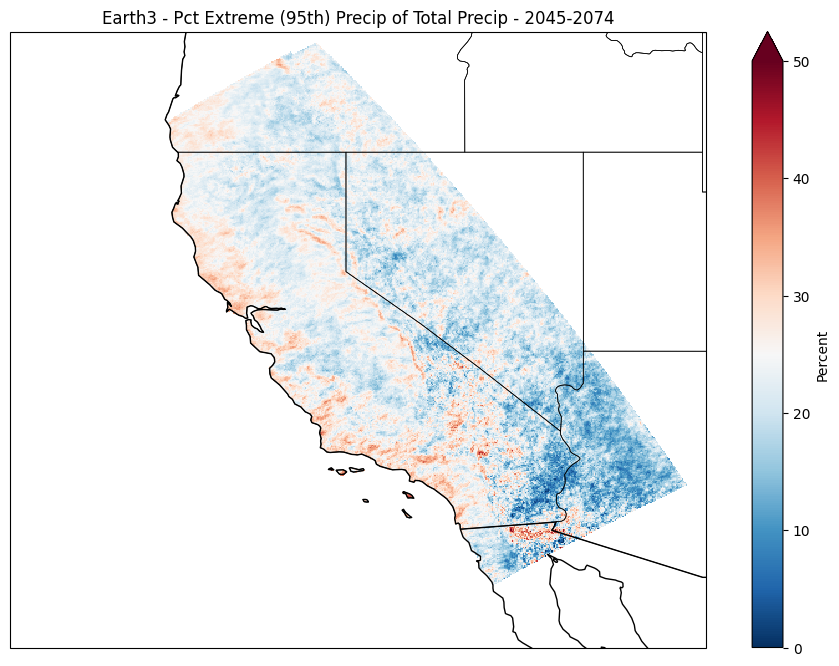

In [120]:
def map_99(netcdf_file, variable_name="total_extreme_precipitation_div_by_total_precipitation_scaled", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the 99th Percentile for PR (1950-2014) from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the pr values.
        variable_name (str): Name of the variable to plot. Defaults to "pr".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmax=50, cbar_kwargs={'label': 'Percent'})

        plt.title("Earth3 - Pct Extreme (95th) Precip of Total Precip - 2045-2074")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_FLOOD_PctExtreme95_01B-2_2045-2074_Earth3.nc"  # Path to the NetCDF file with the tasmax difference

map_99(netcdf_file_path)

In [ ]:
# - FGOALS CM2 - Pct Precip on VWD / Total Precip

In [130]:
import xarray as xr
# Optional: For setting up a Dask client for better monitoring and control
# from dask.distributed import Client

def calculate_extreme_precipitation_sum_dask(
    pr_file_path,
    percentile_file_path,
    pr_variable_name='pr',
    percentile_variable_name='pr95', # Changed default to pr95 as per typical naming
    pr_chunks={'time': 'auto'},      # Dask chunks for precipitation data
    percentile_chunks={}             # Dask chunks for percentile data (often smaller, {} or 'auto' is fine)
    ):
    """
    Calculates the total precipitation from days where daily precipitation
    exceeds the 95th percentile at each lat/lon location, using Dask for out-of-core computation.

    Args:
        pr_file_path (str): Path to the NetCDF file containing daily precipitation data.
        percentile_file_path (str): Path to the NetCDF file containing the 95th percentile
                                     precipitation data.
        pr_variable_name (str, optional): Name of the precipitation variable in pr_file_path.
                                          Defaults to 'pr'.
        percentile_variable_name (str, optional): Name of the 95th percentile variable
                                                in percentile_file_path. Defaults to 'pr95'.
        pr_chunks (dict, optional): Chunking dictionary for the precipitation data.
                                   Defaults to {'time': 'auto'}.
        percentile_chunks (dict, optional): Chunking dictionary for the percentile data.
                                           Defaults to {}.

    Returns:
        xarray.DataArray: A Dask-backed DataArray containing the sum of extreme precipitation
                          at each lat/lon. Computation is triggered when writing to disk or
                          explicitly calling .compute() or .load().
                          Returns None if an error occurs.
    """
    try:
        # Open the precipitation and percentile datasets with Dask chunks
        # This makes xarray use Dask arrays, enabling out-of-core computation
        ds_pr = xr.open_dataset(pr_file_path, chunks=pr_chunks)
        ds_percentile = xr.open_dataset(percentile_file_path, chunks=percentile_chunks)

        # Extract the precipitation data and the 95th percentile data
        # Operations will now build a Dask graph
        daily_pr = ds_pr[pr_variable_name] * 86400 # This multiplication is also lazy
        percentile_95 = ds_percentile[percentile_variable_name]

        # Ensure that the percentile data can be broadcasted to the daily data.
        # If percentile_95 is small, you could .load() it into memory here
        # to potentially speed up the comparison, but it's often fine as a Dask array.
        # e.g., if ds_percentile.nbytes < some_threshold: percentile_95 = percentile_95.load()

        if 'time' in percentile_95.dims and percentile_95.sizes['time'] == 1:
            percentile_95 = percentile_95.squeeze('time', drop=True)
        elif 'time' in percentile_95.dims and percentile_95.sizes['time'] > 1:
            print("Warning: Percentile data appears to have a time dimension > 1. "
                  "This usually means it's a daily varying percentile. "
                  "Ensure this is the intended behavior. "
                  "If it's a single percentile map, it should not have a time dimension or be of size 1.")

        # Identify days where daily precipitation is above the 95th percentile
        extreme_days_mask = daily_pr > percentile_95 # Lazy operation

        # Use the mask to select only the precipitation values on extreme days
        extreme_pr = daily_pr.where(extreme_days_mask) # Lazy operation

        # Sum the precipitation from these extreme days along the 'time' dimension
        # skipna=True is important. This is still a lazy Dask operation.
        total_extreme_pr = extreme_pr.sum(dim='time', skipna=True)

        # It's good practice to give the output DataArray a name
        total_extreme_pr.name = "total_extreme_precipitation"
        total_extreme_pr.attrs['long_name'] = 'Total precipitation from days > 95th percentile (Dask)'
        if 'units' in daily_pr.attrs:
            # Assuming units of daily_pr after multiplication are mm/day equivalent
             total_extreme_pr.attrs['units'] = daily_pr.attrs.get('units_after_scaling', 'mm') # or appropriate unit
        else:
            total_extreme_pr.attrs['units'] = 'mm' # Placeholder


        # Datasets can be closed. Dask operations on arrays will still work if the data
        # needed for computation has been described in the task graph.
        # However, ensure computations that need to read metadata or re-read data chunks
        # are defined before closing if not using .persist() or .compute() earlier.
        # For simple sequential operations like this, closing here is usually fine.
        ds_pr.close()
        ds_percentile.close()

        return total_extreme_pr

    except FileNotFoundError:
        print(f"Error: One or both NetCDF files not found.")
        print(f"Precipitation file: {pr_file_path}")
        print(f"Percentile file: {percentile_file_path}")
        return None
    except KeyError as e:
        print(f"Error: Variable not found in NetCDF file. Details: {e}")
        print("Please ensure 'pr_variable_name' and 'percentile_variable_name' are correct.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # Optional: Initialize a Dask client to monitor computations
    # client = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB') # Customize as needed
    # print(f"Dask dashboard link: {client.dashboard_link}")

    # --- Configuration ---
    precipitation_filepath = 'pr.FGOALS-g3.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc'
    percentile_filepath = 'VCP_FLOOD_PR_95pct_1950-2014_VWD_FGOALS.nc'

    precip_var_name = 'pr'
    # The user's original main block explicitly uses 'pr' for the percentile variable name.
    # The function default is 'pr95', but this will override it.
    percentile_var_name = 'pr'

    # Dask chunking configuration (tune based on your data and memory)
    # 'auto' often works well. For time series, chunking time is common.
    # If lat/lon are very large, you might chunk them too e.g., {'time': 100, 'lat': 10, 'lon': 10}
    precip_chunks_config = {'time': 'auto'} # Let Dask/xarray decide chunking for time dimension
    percentile_chunks_config = {} # For smaller percentile files, default chunking or no chunking is often fine.
                                   # Or use 'auto' if it also could be large.

    # --- Calculation ---
    print("Starting calculation with Dask...")
    extreme_precipitation_sum = calculate_extreme_precipitation_sum_dask(
        precipitation_filepath,
        percentile_filepath,
        pr_variable_name=precip_var_name,
        percentile_variable_name=percentile_var_name,
        pr_chunks=precip_chunks_config,
        percentile_chunks=percentile_chunks_config
    )

    # --- Output ---
    if extreme_precipitation_sum is not None:
        print("\nSuccessfully defined Dask computation for the sum of precipitation on extreme days.")
        print("The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().")
        print(extreme_precipitation_sum) # This will show the Dask array structure, not values

        # --- Save the result to a new NetCDF file ---
        # This is where Dask will perform the actual computation and write to disk.
        output_filepath = 'VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2015-2044_FGOALS.nc'
        print(f"\nAttempting to save results to: {output_filepath}")
        try:
            # When saving, Dask computes the result and writes it.
            # For very large outputs, ensure you have disk space.
            # You can also specify encoding for compression, etc.
            extreme_precipitation_sum.to_netcdf(output_filepath)
            print(f"Results successfully saved to: {output_filepath}")
        except Exception as e:
            print(f"\nError saving results to NetCDF: {e}")
            print("This error might have occurred during Dask computation or file writing.")

    # Optional: Close the Dask client if you initialized one
    # if 'client' in locals():
    # client.close()

Starting calculation with Dask...

Successfully defined Dask computation for the sum of precipitation on extreme days.
The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().
<xarray.DataArray 'total_extreme_precipitation' (lat: 495, lon: 559)> Size: 2MB
dask.array<sum-aggregate, shape=(495, 559), dtype=float64, chunksize=(495, 559), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B ...
Attributes:
    long_name:  Total precipitation from days > 95th percentile (Dask)
    units:      mm

Attempting to save results to: VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2015-2044_FGOALS.nc
Results successfully saved to: VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2015-2044_FGOALS.nc


In [132]:
def calculate_total_precipitation_dask(
    pr_file_path,
    pr_variable_name='pr',
    pr_chunks={'time': 'auto'}
    ):
    """
    Calculates the total precipitation at each lat/lon location,
    using Dask for out-of-core computation.

    Args:
        pr_file_path (str): Path to the NetCDF file containing daily precipitation data.
        pr_variable_name (str, optional): Name of the precipitation variable in pr_file_path.
                                          Defaults to 'pr'.
        pr_chunks (dict, optional): Chunking dictionary for the precipitation data.
                                    Defaults to {'time': 'auto'}.

    Returns:
        xarray.DataArray: A Dask-backed DataArray containing the sum of precipitation
                          at each lat/lon. Computation is triggered when writing to disk or
                          explicitly calling .compute() or .load().
                          Returns None if an error occurs.
    """
    try:
        # Open the precipitation dataset with Dask chunks
        ds_pr = xr.open_dataset(pr_file_path, chunks=pr_chunks)

        # Extract the precipitation data
        # Operations will now build a Dask graph
        daily_pr = ds_pr[pr_variable_name]

        # Optional: If your precipitation data is not already in mm/day
        # and needs conversion (e.g., from kg m-2 s-1), apply it here.
        # For example, if original units are kg m-2 s-1 (flux)
        # daily_pr_mm_day = daily_pr * 86400 # Convert to mm/day
        # If it's already in mm/day or a similar daily total, no conversion needed.
        # For this example, we'll assume daily_pr is already in appropriate daily units (e.g., mm)
        # or if it was flux, the user would handle the conversion as needed.
        # The original code had `* 86400`, so we'll keep that behavior for now
        # if the user expects it. If the input 'pr' is already daily totals,
        # this multiplication would be incorrect.
        # Let's assume the multiplication is to convert from flux to total daily amount.
        daily_pr_converted = daily_pr * 86400 # This multiplication is also lazy
        daily_pr_converted.attrs['units_after_scaling'] = 'mm' # Example unit after scaling

        # Sum the precipitation along the 'time' dimension
        # skipna=True is important. This is still a lazy Dask operation.
        total_pr = daily_pr_converted.sum(dim='time', skipna=True)

        # It's good practice to give the output DataArray a name and attributes
        total_pr.name = "total_precipitation"
        total_pr.attrs['long_name'] = 'Total precipitation (Dask)'
        if 'units_after_scaling' in daily_pr_converted.attrs:
             total_pr.attrs['units'] = daily_pr_converted.attrs['units_after_scaling']
        elif 'units' in daily_pr.attrs:
            total_pr.attrs['units'] = daily_pr.attrs['units'] # Or sum of daily units
        else:
            total_pr.attrs['units'] = 'mm' # Placeholder

        ds_pr.close()

        return total_pr

    except FileNotFoundError:
        print(f"Error: Precipitation NetCDF file not found.")
        print(f"Precipitation file: {pr_file_path}")
        return None
    except KeyError as e:
        print(f"Error: Variable '{pr_variable_name}' not found in NetCDF file. Details: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # Optional: Initialize a Dask client to monitor computations
    # client = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB') # Customize as needed
    # print(f"Dask dashboard link: {client.dashboard_link}")

    # --- Configuration ---
    precipitation_filepath = 'pr.FGOALS-g3.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc'
    precip_var_name = 'pr'

    # Dask chunking configuration
    precip_chunks_config = {'time': 'auto'}

    # --- Calculation ---
    print("Starting calculation of total precipitation with Dask...")
    total_precipitation_sum = calculate_total_precipitation_dask(
        precipitation_filepath,
        pr_variable_name=precip_var_name,
        pr_chunks=precip_chunks_config
    )

    # --- Output ---
    if total_precipitation_sum is not None:
        print("\nSuccessfully defined Dask computation for the total precipitation.")
        print("The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().")
        print(total_precipitation_sum)

        # --- Save the result to a new NetCDF file ---
        output_filepath = 'VCP_FLOOD_PR_95pct_VWDTotalPrecip_2015-2044_FGOALS.nc' # Changed output filename
        print(f"\nAttempting to save results to: {output_filepath}")
        try:
            total_precipitation_sum.to_netcdf(output_filepath)
            print(f"Results successfully saved to: {output_filepath}")
        except Exception as e:
            print(f"\nError saving results to NetCDF: {e}")
            print("This error might have occurred during Dask computation or file writing.")

    # Optional: Close the Dask client if you initialized one
    # if 'client' in locals() and client: # Check if client exists and is not None
    #     client.close()

Starting calculation of total precipitation with Dask...

Successfully defined Dask computation for the total precipitation.
The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().
<xarray.DataArray 'total_precipitation' (lat: 495, lon: 559)> Size: 2MB
dask.array<sum-aggregate, shape=(495, 559), dtype=float64, chunksize=(495, 559), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon      (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
Attributes:
    long_name:  Total precipitation (Dask)
    units:      mm

Attempting to save results to: VCP_FLOOD_PR_95pct_VWDTotalPrecip_2015-2044_FGOALS.nc
Results successfully saved to: VCP_FLOOD_PR_95pct_VWDTotalPrecip_2015-2044_FGOALS.nc


In [134]:
def multiply_and_divide_netcdfs(ext_filepath, tot_filepath, output_filepath,
                                ext_var_name='pr', tot_var_name='pr'):
    """
    Opens ext.nc, multiplies its data variable by 100,
    opens tot.nc, and divides the result by tot.nc's data variable.
    Saves the final result to output_filepath.

    Args:
        ext_filepath (str): Path to the 'ext.nc' NetCDF file.
        tot_filepath (str): Path to the 'tot.nc' NetCDF file.
        output_filepath (str): Path to save the resulting NetCDF file.
        ext_var_name (str, optional): Name of the variable in ext.nc.
                                      If None, uses the first data variable.
        tot_var_name (str, optional): Name of the variable in tot.nc.
                                      If None, uses the first data variable.

    Returns:
        xarray.DataArray: The resulting DataArray, or None if an error occurs.
    """
    try:
        # Open the datasets
        ds_ext = xr.open_dataset(ext_filepath)
        ds_tot = xr.open_dataset(tot_filepath)

        # Determine variable names if not provided
        if ext_var_name is None:
            ext_var_name = get_first_data_variable_name(ds_ext)
            print(f"Using inferred variable '{ext_var_name}' from '{ext_filepath}'")
        if tot_var_name is None:
            tot_var_name = get_first_data_variable_name(ds_tot)
            print(f"Using inferred variable '{tot_var_name}' from '{tot_filepath}'")

        # Extract the DataArrays
        ext_data = ds_ext[ext_var_name]
        tot_data = ds_tot[tot_var_name]

        # Perform the calculation: (ext_data * 100) / tot_data
        print(f"\nPerforming operation: ({ext_var_name} * 100) / {tot_var_name}")
        
        scaled_ext_data = ext_data * 100
        result_data = scaled_ext_data / tot_data

        # Handle potential division by zero explicitly if you want something other than inf/NaN
        # For example, to set results to NaN where tot_data is zero:
        # result_data = xr.where(tot_data == 0, np.nan, scaled_ext_data / tot_data)
        # Xarray by default will produce `inf` or `NaN` which is often acceptable.

        # Assign a name and attributes to the result for clarity in the output file
        result_data.name = f"{ext_var_name}_div_by_{tot_var_name}_scaled"
        result_data.attrs['long_name'] = (f"({ext_var_name} * 100) / {tot_var_name}")
        result_data.attrs['units'] = f"({ext_data.attrs.get('units', 'unknown')} * 100) / {tot_data.attrs.get('units', 'unknown')}"
        result_data.attrs['operation_description'] = (
            f"Data from variable '{ext_var_name}' in '{ext_filepath}' was multiplied by 100, "
            f"then divided by data from variable '{tot_var_name}' in '{tot_filepath}'."
        )


        # Save the result to a new NetCDF file
        result_data.to_netcdf(output_filepath)
        print(f"\nResult successfully saved to: {output_filepath}")

        # Close the datasets
        ds_ext.close()
        ds_tot.close()

        return result_data

    except FileNotFoundError as e:
        print(f"Error: File not found. Details: {e}")
        return None
    except KeyError as e:
        print(f"Error: Variable not found in NetCDF file. Details: {e}")
        print("Please ensure 'ext_var_name' and 'tot_var_name' are correct if you specified them.")
        return None
    except ValueError as e: # For issues like no data variables
        print(f"Error: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # --- Configuration ---
    # Replace with the actual paths to your files
    ext_netcdf_file = 'VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2015-2044_FGOALS.nc'
    tot_netcdf_file = 'VCP_FLOOD_PR_95pct_VWDTotalPrecip_2015-2044_FGOALS.nc'
    output_netcdf_file = 'VCP_FLOOD_PctExtreme95_01A-3_2015-2044_FGOALS.nc'

    # Optional: Specify variable names if you know them and want to be explicit,
    # or if the files have multiple data variables and you don't want the first one.
    # If set to None, the script will try to use the first data variable found.
    ext_variable = 'total_extreme_precipitation'  # e.g., 'precipitation_flux' or 'extreme_sum'
    tot_variable = 'total_precipitation'  # e.g., 'total_precipitation'

    # --- Perform Calculation ---
    calculated_result = multiply_and_divide_netcdfs(
        ext_netcdf_file,
        tot_netcdf_file,
        output_netcdf_file,
        ext_var_name=ext_variable,
        tot_var_name=tot_variable
    )

    if calculated_result is not None:
        print("\n--- Result DataArray ---")
        print(calculated_result)
        # You can further analyze or plot 'calculated_result' here if needed
        # For example:
        # import matplotlib.pyplot as plt
        # if 'lat' in calculated_result.dims and 'lon' in calculated_result.dims:
        #     if len(calculated_result.dims) == 2: # Simple 2D plot
        #         calculated_result.plot()
        #         plt.show()
        #     elif 'time' in calculated_result.dims and calculated_result.sizes['time'] > 0: # Plot first time step of 3D data
        #         calculated_result.isel(time=0).plot()
        #         plt.show()


Performing operation: (total_extreme_precipitation * 100) / total_precipitation

Result successfully saved to: VCP_FLOOD_PctExtreme95_01A-3_2015-2044_FGOALS.nc

--- Result DataArray ---
<xarray.DataArray 'total_extreme_precipitation_div_by_total_precipitation_scaled' (
                                                                                   lat: 495,
                                                                                   lon: 559)> Size: 2MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B ...
Attributes:
    long_name:              (total_extreme_pr

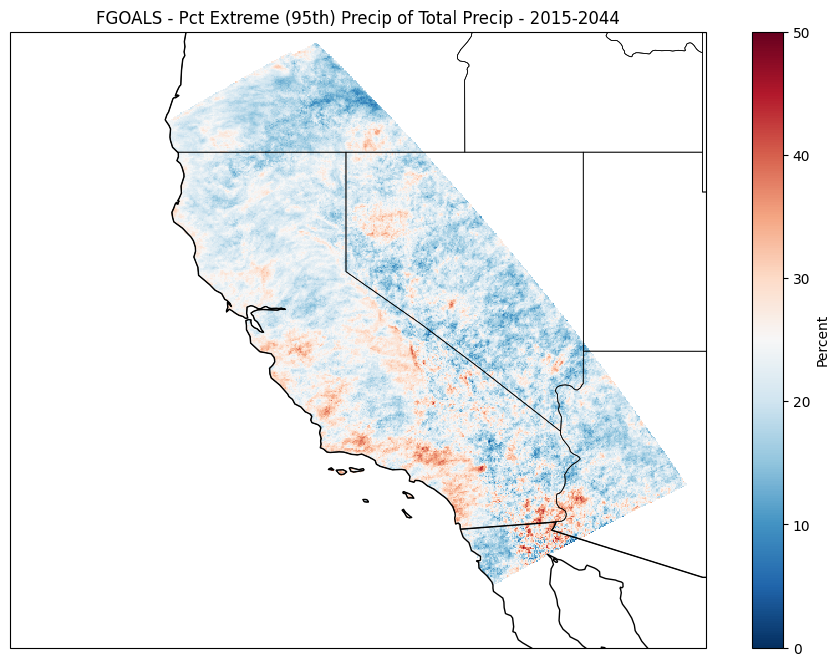

In [146]:
def map_99(netcdf_file, variable_name="total_extreme_precipitation_div_by_total_precipitation_scaled", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the 99th Percentile for PR (1950-2014) from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the pr values.
        variable_name (str): Name of the variable to plot. Defaults to "pr".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmax=50, cbar_kwargs={'label': 'Percent'})

        plt.title("FGOALS - Pct Extreme (95th) Precip of Total Precip - 2015-2044")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_FLOOD_PctExtreme95_01A-3_2015-2044_FGOALS.nc"  # Path to the NetCDF file with the tasmax difference

map_99(netcdf_file_path)

In [138]:
import xarray as xr
# Optional: For setting up a Dask client for better monitoring and control
# from dask.distributed import Client

def calculate_extreme_precipitation_sum_dask(
    pr_file_path,
    percentile_file_path,
    pr_variable_name='pr',
    percentile_variable_name='pr95', # Changed default to pr95 as per typical naming
    pr_chunks={'time': 'auto'},      # Dask chunks for precipitation data
    percentile_chunks={}             # Dask chunks for percentile data (often smaller, {} or 'auto' is fine)
    ):
    """
    Calculates the total precipitation from days where daily precipitation
    exceeds the 95th percentile at each lat/lon location, using Dask for out-of-core computation.

    Args:
        pr_file_path (str): Path to the NetCDF file containing daily precipitation data.
        percentile_file_path (str): Path to the NetCDF file containing the 95th percentile
                                     precipitation data.
        pr_variable_name (str, optional): Name of the precipitation variable in pr_file_path.
                                          Defaults to 'pr'.
        percentile_variable_name (str, optional): Name of the 95th percentile variable
                                                in percentile_file_path. Defaults to 'pr95'.
        pr_chunks (dict, optional): Chunking dictionary for the precipitation data.
                                   Defaults to {'time': 'auto'}.
        percentile_chunks (dict, optional): Chunking dictionary for the percentile data.
                                           Defaults to {}.

    Returns:
        xarray.DataArray: A Dask-backed DataArray containing the sum of extreme precipitation
                          at each lat/lon. Computation is triggered when writing to disk or
                          explicitly calling .compute() or .load().
                          Returns None if an error occurs.
    """
    try:
        # Open the precipitation and percentile datasets with Dask chunks
        # This makes xarray use Dask arrays, enabling out-of-core computation
        ds_pr = xr.open_dataset(pr_file_path, chunks=pr_chunks)
        ds_percentile = xr.open_dataset(percentile_file_path, chunks=percentile_chunks)

        # Extract the precipitation data and the 95th percentile data
        # Operations will now build a Dask graph
        daily_pr = ds_pr[pr_variable_name] * 86400 # This multiplication is also lazy
        percentile_95 = ds_percentile[percentile_variable_name]

        # Ensure that the percentile data can be broadcasted to the daily data.
        # If percentile_95 is small, you could .load() it into memory here
        # to potentially speed up the comparison, but it's often fine as a Dask array.
        # e.g., if ds_percentile.nbytes < some_threshold: percentile_95 = percentile_95.load()

        if 'time' in percentile_95.dims and percentile_95.sizes['time'] == 1:
            percentile_95 = percentile_95.squeeze('time', drop=True)
        elif 'time' in percentile_95.dims and percentile_95.sizes['time'] > 1:
            print("Warning: Percentile data appears to have a time dimension > 1. "
                  "This usually means it's a daily varying percentile. "
                  "Ensure this is the intended behavior. "
                  "If it's a single percentile map, it should not have a time dimension or be of size 1.")

        # Identify days where daily precipitation is above the 95th percentile
        extreme_days_mask = daily_pr > percentile_95 # Lazy operation

        # Use the mask to select only the precipitation values on extreme days
        extreme_pr = daily_pr.where(extreme_days_mask) # Lazy operation

        # Sum the precipitation from these extreme days along the 'time' dimension
        # skipna=True is important. This is still a lazy Dask operation.
        total_extreme_pr = extreme_pr.sum(dim='time', skipna=True)

        # It's good practice to give the output DataArray a name
        total_extreme_pr.name = "total_extreme_precipitation"
        total_extreme_pr.attrs['long_name'] = 'Total precipitation from days > 95th percentile (Dask)'
        if 'units' in daily_pr.attrs:
            # Assuming units of daily_pr after multiplication are mm/day equivalent
             total_extreme_pr.attrs['units'] = daily_pr.attrs.get('units_after_scaling', 'mm') # or appropriate unit
        else:
            total_extreme_pr.attrs['units'] = 'mm' # Placeholder


        # Datasets can be closed. Dask operations on arrays will still work if the data
        # needed for computation has been described in the task graph.
        # However, ensure computations that need to read metadata or re-read data chunks
        # are defined before closing if not using .persist() or .compute() earlier.
        # For simple sequential operations like this, closing here is usually fine.
        ds_pr.close()
        ds_percentile.close()

        return total_extreme_pr

    except FileNotFoundError:
        print(f"Error: One or both NetCDF files not found.")
        print(f"Precipitation file: {pr_file_path}")
        print(f"Percentile file: {percentile_file_path}")
        return None
    except KeyError as e:
        print(f"Error: Variable not found in NetCDF file. Details: {e}")
        print("Please ensure 'pr_variable_name' and 'percentile_variable_name' are correct.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # Optional: Initialize a Dask client to monitor computations
    # client = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB') # Customize as needed
    # print(f"Dask dashboard link: {client.dashboard_link}")

    # --- Configuration ---
    precipitation_filepath = 'pr.FGOALS-g3.ssp370.r1i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc'
    percentile_filepath = 'VCP_FLOOD_PR_95pct_1950-2014_VWD_FGOALS.nc'

    precip_var_name = 'pr'
    # The user's original main block explicitly uses 'pr' for the percentile variable name.
    # The function default is 'pr95', but this will override it.
    percentile_var_name = 'pr'

    # Dask chunking configuration (tune based on your data and memory)
    # 'auto' often works well. For time series, chunking time is common.
    # If lat/lon are very large, you might chunk them too e.g., {'time': 100, 'lat': 10, 'lon': 10}
    precip_chunks_config = {'time': 'auto'} # Let Dask/xarray decide chunking for time dimension
    percentile_chunks_config = {} # For smaller percentile files, default chunking or no chunking is often fine.
                                   # Or use 'auto' if it also could be large.

    # --- Calculation ---
    print("Starting calculation with Dask...")
    extreme_precipitation_sum = calculate_extreme_precipitation_sum_dask(
        precipitation_filepath,
        percentile_filepath,
        pr_variable_name=precip_var_name,
        percentile_variable_name=percentile_var_name,
        pr_chunks=precip_chunks_config,
        percentile_chunks=percentile_chunks_config
    )

    # --- Output ---
    if extreme_precipitation_sum is not None:
        print("\nSuccessfully defined Dask computation for the sum of precipitation on extreme days.")
        print("The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().")
        print(extreme_precipitation_sum) # This will show the Dask array structure, not values

        # --- Save the result to a new NetCDF file ---
        # This is where Dask will perform the actual computation and write to disk.
        output_filepath = 'VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2045-2074_FGOALS.nc'
        print(f"\nAttempting to save results to: {output_filepath}")
        try:
            # When saving, Dask computes the result and writes it.
            # For very large outputs, ensure you have disk space.
            # You can also specify encoding for compression, etc.
            extreme_precipitation_sum.to_netcdf(output_filepath)
            print(f"Results successfully saved to: {output_filepath}")
        except Exception as e:
            print(f"\nError saving results to NetCDF: {e}")
            print("This error might have occurred during Dask computation or file writing.")

    # Optional: Close the Dask client if you initialized one
    # if 'client' in locals():
    # client.close()

Starting calculation with Dask...

Successfully defined Dask computation for the sum of precipitation on extreme days.
The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().
<xarray.DataArray 'total_extreme_precipitation' (lat: 495, lon: 559)> Size: 2MB
dask.array<sum-aggregate, shape=(495, 559), dtype=float64, chunksize=(495, 559), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B ...
Attributes:
    long_name:  Total precipitation from days > 95th percentile (Dask)
    units:      mm

Attempting to save results to: VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2045-2074_FGOALS.nc
Results successfully saved to: VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2045-2074_FGOALS.nc


In [140]:
def calculate_total_precipitation_dask(
    pr_file_path,
    pr_variable_name='pr',
    pr_chunks={'time': 'auto'}
    ):
    """
    Calculates the total precipitation at each lat/lon location,
    using Dask for out-of-core computation.

    Args:
        pr_file_path (str): Path to the NetCDF file containing daily precipitation data.
        pr_variable_name (str, optional): Name of the precipitation variable in pr_file_path.
                                          Defaults to 'pr'.
        pr_chunks (dict, optional): Chunking dictionary for the precipitation data.
                                    Defaults to {'time': 'auto'}.

    Returns:
        xarray.DataArray: A Dask-backed DataArray containing the sum of precipitation
                          at each lat/lon. Computation is triggered when writing to disk or
                          explicitly calling .compute() or .load().
                          Returns None if an error occurs.
    """
    try:
        # Open the precipitation dataset with Dask chunks
        ds_pr = xr.open_dataset(pr_file_path, chunks=pr_chunks)

        # Extract the precipitation data
        # Operations will now build a Dask graph
        daily_pr = ds_pr[pr_variable_name]

        # Optional: If your precipitation data is not already in mm/day
        # and needs conversion (e.g., from kg m-2 s-1), apply it here.
        # For example, if original units are kg m-2 s-1 (flux)
        # daily_pr_mm_day = daily_pr * 86400 # Convert to mm/day
        # If it's already in mm/day or a similar daily total, no conversion needed.
        # For this example, we'll assume daily_pr is already in appropriate daily units (e.g., mm)
        # or if it was flux, the user would handle the conversion as needed.
        # The original code had `* 86400`, so we'll keep that behavior for now
        # if the user expects it. If the input 'pr' is already daily totals,
        # this multiplication would be incorrect.
        # Let's assume the multiplication is to convert from flux to total daily amount.
        daily_pr_converted = daily_pr * 86400 # This multiplication is also lazy
        daily_pr_converted.attrs['units_after_scaling'] = 'mm' # Example unit after scaling

        # Sum the precipitation along the 'time' dimension
        # skipna=True is important. This is still a lazy Dask operation.
        total_pr = daily_pr_converted.sum(dim='time', skipna=True)

        # It's good practice to give the output DataArray a name and attributes
        total_pr.name = "total_precipitation"
        total_pr.attrs['long_name'] = 'Total precipitation (Dask)'
        if 'units_after_scaling' in daily_pr_converted.attrs:
             total_pr.attrs['units'] = daily_pr_converted.attrs['units_after_scaling']
        elif 'units' in daily_pr.attrs:
            total_pr.attrs['units'] = daily_pr.attrs['units'] # Or sum of daily units
        else:
            total_pr.attrs['units'] = 'mm' # Placeholder

        ds_pr.close()

        return total_pr

    except FileNotFoundError:
        print(f"Error: Precipitation NetCDF file not found.")
        print(f"Precipitation file: {pr_file_path}")
        return None
    except KeyError as e:
        print(f"Error: Variable '{pr_variable_name}' not found in NetCDF file. Details: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # Optional: Initialize a Dask client to monitor computations
    # client = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB') # Customize as needed
    # print(f"Dask dashboard link: {client.dashboard_link}")

    # --- Configuration ---
    precipitation_filepath = 'pr.FGOALS-g3.ssp370.r1i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc'
    precip_var_name = 'pr'

    # Dask chunking configuration
    precip_chunks_config = {'time': 'auto'}

    # --- Calculation ---
    print("Starting calculation of total precipitation with Dask...")
    total_precipitation_sum = calculate_total_precipitation_dask(
        precipitation_filepath,
        pr_variable_name=precip_var_name,
        pr_chunks=precip_chunks_config
    )

    # --- Output ---
    if total_precipitation_sum is not None:
        print("\nSuccessfully defined Dask computation for the total precipitation.")
        print("The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().")
        print(total_precipitation_sum)

        # --- Save the result to a new NetCDF file ---
        output_filepath = 'VCP_FLOOD_PR_95pct_VWDTotalPrecip_2045-2074_FGOALS.nc' # Changed output filename
        print(f"\nAttempting to save results to: {output_filepath}")
        try:
            total_precipitation_sum.to_netcdf(output_filepath)
            print(f"Results successfully saved to: {output_filepath}")
        except Exception as e:
            print(f"\nError saving results to NetCDF: {e}")
            print("This error might have occurred during Dask computation or file writing.")

    # Optional: Close the Dask client if you initialized one
    # if 'client' in locals() and client: # Check if client exists and is not None
    #     client.close()

Starting calculation of total precipitation with Dask...

Successfully defined Dask computation for the total precipitation.
The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().
<xarray.DataArray 'total_precipitation' (lat: 495, lon: 559)> Size: 2MB
dask.array<sum-aggregate, shape=(495, 559), dtype=float64, chunksize=(495, 559), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon      (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
Attributes:
    long_name:  Total precipitation (Dask)
    units:      mm

Attempting to save results to: VCP_FLOOD_PR_95pct_VWDTotalPrecip_2045-2074_FGOALS.nc
Results successfully saved to: VCP_FLOOD_PR_95pct_VWDTotalPrecip_2045-2074_FGOALS.nc


In [142]:
def multiply_and_divide_netcdfs(ext_filepath, tot_filepath, output_filepath,
                                ext_var_name='pr', tot_var_name='pr'):
    """
    Opens ext.nc, multiplies its data variable by 100,
    opens tot.nc, and divides the result by tot.nc's data variable.
    Saves the final result to output_filepath.

    Args:
        ext_filepath (str): Path to the 'ext.nc' NetCDF file.
        tot_filepath (str): Path to the 'tot.nc' NetCDF file.
        output_filepath (str): Path to save the resulting NetCDF file.
        ext_var_name (str, optional): Name of the variable in ext.nc.
                                      If None, uses the first data variable.
        tot_var_name (str, optional): Name of the variable in tot.nc.
                                      If None, uses the first data variable.

    Returns:
        xarray.DataArray: The resulting DataArray, or None if an error occurs.
    """
    try:
        # Open the datasets
        ds_ext = xr.open_dataset(ext_filepath)
        ds_tot = xr.open_dataset(tot_filepath)

        # Determine variable names if not provided
        if ext_var_name is None:
            ext_var_name = get_first_data_variable_name(ds_ext)
            print(f"Using inferred variable '{ext_var_name}' from '{ext_filepath}'")
        if tot_var_name is None:
            tot_var_name = get_first_data_variable_name(ds_tot)
            print(f"Using inferred variable '{tot_var_name}' from '{tot_filepath}'")

        # Extract the DataArrays
        ext_data = ds_ext[ext_var_name]
        tot_data = ds_tot[tot_var_name]

        # Perform the calculation: (ext_data * 100) / tot_data
        print(f"\nPerforming operation: ({ext_var_name} * 100) / {tot_var_name}")
        
        scaled_ext_data = ext_data * 100
        result_data = scaled_ext_data / tot_data

        # Handle potential division by zero explicitly if you want something other than inf/NaN
        # For example, to set results to NaN where tot_data is zero:
        # result_data = xr.where(tot_data == 0, np.nan, scaled_ext_data / tot_data)
        # Xarray by default will produce `inf` or `NaN` which is often acceptable.

        # Assign a name and attributes to the result for clarity in the output file
        result_data.name = f"{ext_var_name}_div_by_{tot_var_name}_scaled"
        result_data.attrs['long_name'] = (f"({ext_var_name} * 100) / {tot_var_name}")
        result_data.attrs['units'] = f"({ext_data.attrs.get('units', 'unknown')} * 100) / {tot_data.attrs.get('units', 'unknown')}"
        result_data.attrs['operation_description'] = (
            f"Data from variable '{ext_var_name}' in '{ext_filepath}' was multiplied by 100, "
            f"then divided by data from variable '{tot_var_name}' in '{tot_filepath}'."
        )


        # Save the result to a new NetCDF file
        result_data.to_netcdf(output_filepath)
        print(f"\nResult successfully saved to: {output_filepath}")

        # Close the datasets
        ds_ext.close()
        ds_tot.close()

        return result_data

    except FileNotFoundError as e:
        print(f"Error: File not found. Details: {e}")
        return None
    except KeyError as e:
        print(f"Error: Variable not found in NetCDF file. Details: {e}")
        print("Please ensure 'ext_var_name' and 'tot_var_name' are correct if you specified them.")
        return None
    except ValueError as e: # For issues like no data variables
        print(f"Error: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # --- Configuration ---
    # Replace with the actual paths to your files
    ext_netcdf_file = 'VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2045-2074_FGOALS.nc'
    tot_netcdf_file = 'VCP_FLOOD_PR_95pct_VWDTotalPrecip_2045-2074_FGOALS.nc'
    output_netcdf_file = 'VCP_FLOOD_PctExtreme95_01B-1_2045-2074_FGOALS.nc'

    # Optional: Specify variable names if you know them and want to be explicit,
    # or if the files have multiple data variables and you don't want the first one.
    # If set to None, the script will try to use the first data variable found.
    ext_variable = 'total_extreme_precipitation'  # e.g., 'precipitation_flux' or 'extreme_sum'
    tot_variable = 'total_precipitation'  # e.g., 'total_precipitation'

    # --- Perform Calculation ---
    calculated_result = multiply_and_divide_netcdfs(
        ext_netcdf_file,
        tot_netcdf_file,
        output_netcdf_file,
        ext_var_name=ext_variable,
        tot_var_name=tot_variable
    )

    if calculated_result is not None:
        print("\n--- Result DataArray ---")
        print(calculated_result)
        # You can further analyze or plot 'calculated_result' here if needed
        # For example:
        # import matplotlib.pyplot as plt
        # if 'lat' in calculated_result.dims and 'lon' in calculated_result.dims:
        #     if len(calculated_result.dims) == 2: # Simple 2D plot
        #         calculated_result.plot()
        #         plt.show()
        #     elif 'time' in calculated_result.dims and calculated_result.sizes['time'] > 0: # Plot first time step of 3D data
        #         calculated_result.isel(time=0).plot()
        #         plt.show()


Performing operation: (total_extreme_precipitation * 100) / total_precipitation

Result successfully saved to: VCP_FLOOD_PctExtreme95_01B-1_2045-2074_FGOALS.nc

--- Result DataArray ---
<xarray.DataArray 'total_extreme_precipitation_div_by_total_precipitation_scaled' (
                                                                                   lat: 495,
                                                                                   lon: 559)> Size: 2MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B ...
Attributes:
    long_name:              (total_extreme_pr

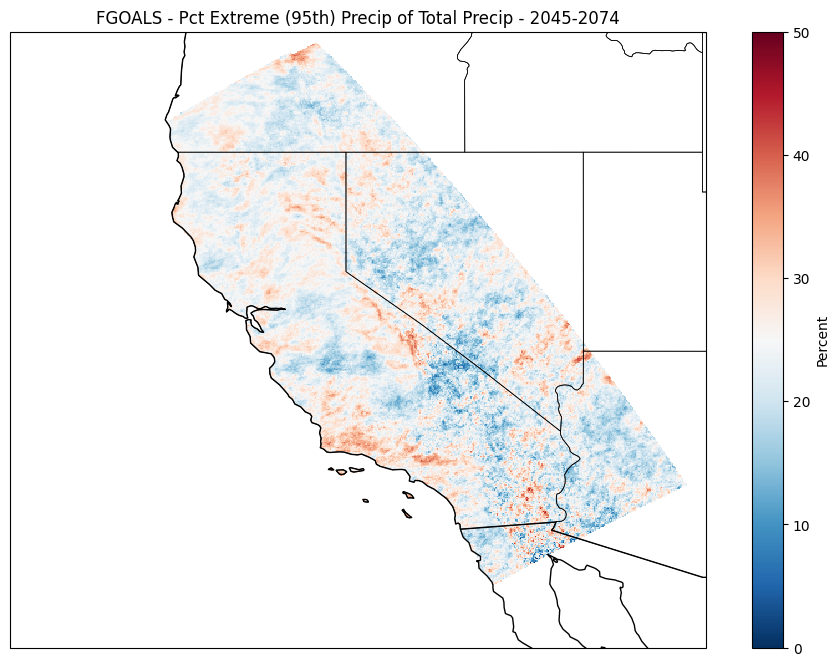

In [144]:
def map_99(netcdf_file, variable_name="total_extreme_precipitation_div_by_total_precipitation_scaled", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the 99th Percentile for PR (1950-2014) from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the pr values.
        variable_name (str): Name of the variable to plot. Defaults to "pr".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmax=50, cbar_kwargs={'label': 'Percent'})

        plt.title("FGOALS - Pct Extreme (95th) Precip of Total Precip - 2045-2074")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_FLOOD_PctExtreme95_01B-1_2045-2074_FGOALS.nc"  # Path to the NetCDF file with the tasmax difference

map_99(netcdf_file_path)

In [ ]:
# - MIROC - Pct Precip on VWD / Total Precip

In [148]:
import xarray as xr
# Optional: For setting up a Dask client for better monitoring and control
# from dask.distributed import Client

def calculate_extreme_precipitation_sum_dask(
    pr_file_path,
    percentile_file_path,
    pr_variable_name='pr',
    percentile_variable_name='pr95', # Changed default to pr95 as per typical naming
    pr_chunks={'time': 'auto'},      # Dask chunks for precipitation data
    percentile_chunks={}             # Dask chunks for percentile data (often smaller, {} or 'auto' is fine)
    ):
    """
    Calculates the total precipitation from days where daily precipitation
    exceeds the 95th percentile at each lat/lon location, using Dask for out-of-core computation.

    Args:
        pr_file_path (str): Path to the NetCDF file containing daily precipitation data.
        percentile_file_path (str): Path to the NetCDF file containing the 95th percentile
                                     precipitation data.
        pr_variable_name (str, optional): Name of the precipitation variable in pr_file_path.
                                          Defaults to 'pr'.
        percentile_variable_name (str, optional): Name of the 95th percentile variable
                                                in percentile_file_path. Defaults to 'pr95'.
        pr_chunks (dict, optional): Chunking dictionary for the precipitation data.
                                   Defaults to {'time': 'auto'}.
        percentile_chunks (dict, optional): Chunking dictionary for the percentile data.
                                           Defaults to {}.

    Returns:
        xarray.DataArray: A Dask-backed DataArray containing the sum of extreme precipitation
                          at each lat/lon. Computation is triggered when writing to disk or
                          explicitly calling .compute() or .load().
                          Returns None if an error occurs.
    """
    try:
        # Open the precipitation and percentile datasets with Dask chunks
        # This makes xarray use Dask arrays, enabling out-of-core computation
        ds_pr = xr.open_dataset(pr_file_path, chunks=pr_chunks)
        ds_percentile = xr.open_dataset(percentile_file_path, chunks=percentile_chunks)

        # Extract the precipitation data and the 95th percentile data
        # Operations will now build a Dask graph
        daily_pr = ds_pr[pr_variable_name] * 86400 # This multiplication is also lazy
        percentile_95 = ds_percentile[percentile_variable_name]

        # Ensure that the percentile data can be broadcasted to the daily data.
        # If percentile_95 is small, you could .load() it into memory here
        # to potentially speed up the comparison, but it's often fine as a Dask array.
        # e.g., if ds_percentile.nbytes < some_threshold: percentile_95 = percentile_95.load()

        if 'time' in percentile_95.dims and percentile_95.sizes['time'] == 1:
            percentile_95 = percentile_95.squeeze('time', drop=True)
        elif 'time' in percentile_95.dims and percentile_95.sizes['time'] > 1:
            print("Warning: Percentile data appears to have a time dimension > 1. "
                  "This usually means it's a daily varying percentile. "
                  "Ensure this is the intended behavior. "
                  "If it's a single percentile map, it should not have a time dimension or be of size 1.")

        # Identify days where daily precipitation is above the 95th percentile
        extreme_days_mask = daily_pr > percentile_95 # Lazy operation

        # Use the mask to select only the precipitation values on extreme days
        extreme_pr = daily_pr.where(extreme_days_mask) # Lazy operation

        # Sum the precipitation from these extreme days along the 'time' dimension
        # skipna=True is important. This is still a lazy Dask operation.
        total_extreme_pr = extreme_pr.sum(dim='time', skipna=True)

        # It's good practice to give the output DataArray a name
        total_extreme_pr.name = "total_extreme_precipitation"
        total_extreme_pr.attrs['long_name'] = 'Total precipitation from days > 95th percentile (Dask)'
        if 'units' in daily_pr.attrs:
            # Assuming units of daily_pr after multiplication are mm/day equivalent
             total_extreme_pr.attrs['units'] = daily_pr.attrs.get('units_after_scaling', 'mm') # or appropriate unit
        else:
            total_extreme_pr.attrs['units'] = 'mm' # Placeholder


        # Datasets can be closed. Dask operations on arrays will still work if the data
        # needed for computation has been described in the task graph.
        # However, ensure computations that need to read metadata or re-read data chunks
        # are defined before closing if not using .persist() or .compute() earlier.
        # For simple sequential operations like this, closing here is usually fine.
        ds_pr.close()
        ds_percentile.close()

        return total_extreme_pr

    except FileNotFoundError:
        print(f"Error: One or both NetCDF files not found.")
        print(f"Precipitation file: {pr_file_path}")
        print(f"Percentile file: {percentile_file_path}")
        return None
    except KeyError as e:
        print(f"Error: Variable not found in NetCDF file. Details: {e}")
        print("Please ensure 'pr_variable_name' and 'percentile_variable_name' are correct.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # Optional: Initialize a Dask client to monitor computations
    # client = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB') # Customize as needed
    # print(f"Dask dashboard link: {client.dashboard_link}")

    # --- Configuration ---
    precipitation_filepath = 'pr.MIROC6.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc'
    percentile_filepath = 'VCP_FLOOD_PR_95pct_1950-2014_VWD_MIROC.nc'

    precip_var_name = 'pr'
    # The user's original main block explicitly uses 'pr' for the percentile variable name.
    # The function default is 'pr95', but this will override it.
    percentile_var_name = 'pr'

    # Dask chunking configuration (tune based on your data and memory)
    # 'auto' often works well. For time series, chunking time is common.
    # If lat/lon are very large, you might chunk them too e.g., {'time': 100, 'lat': 10, 'lon': 10}
    precip_chunks_config = {'time': 'auto'} # Let Dask/xarray decide chunking for time dimension
    percentile_chunks_config = {} # For smaller percentile files, default chunking or no chunking is often fine.
                                   # Or use 'auto' if it also could be large.

    # --- Calculation ---
    print("Starting calculation with Dask...")
    extreme_precipitation_sum = calculate_extreme_precipitation_sum_dask(
        precipitation_filepath,
        percentile_filepath,
        pr_variable_name=precip_var_name,
        percentile_variable_name=percentile_var_name,
        pr_chunks=precip_chunks_config,
        percentile_chunks=percentile_chunks_config
    )

    # --- Output ---
    if extreme_precipitation_sum is not None:
        print("\nSuccessfully defined Dask computation for the sum of precipitation on extreme days.")
        print("The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().")
        print(extreme_precipitation_sum) # This will show the Dask array structure, not values

        # --- Save the result to a new NetCDF file ---
        # This is where Dask will perform the actual computation and write to disk.
        output_filepath = 'VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2015-2044_MIROC.nc'
        print(f"\nAttempting to save results to: {output_filepath}")
        try:
            # When saving, Dask computes the result and writes it.
            # For very large outputs, ensure you have disk space.
            # You can also specify encoding for compression, etc.
            extreme_precipitation_sum.to_netcdf(output_filepath)
            print(f"Results successfully saved to: {output_filepath}")
        except Exception as e:
            print(f"\nError saving results to NetCDF: {e}")
            print("This error might have occurred during Dask computation or file writing.")

    # Optional: Close the Dask client if you initialized one
    # if 'client' in locals():
    # client.close()

Starting calculation with Dask...

Successfully defined Dask computation for the sum of precipitation on extreme days.
The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().
<xarray.DataArray 'total_extreme_precipitation' (lat: 495, lon: 559)> Size: 2MB
dask.array<sum-aggregate, shape=(495, 559), dtype=float64, chunksize=(495, 559), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B ...
Attributes:
    long_name:  Total precipitation from days > 95th percentile (Dask)
    units:      mm

Attempting to save results to: VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2015-2044_MIROC.nc
Results successfully saved to: VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2015-2044_MIROC.nc


In [150]:
def calculate_total_precipitation_dask(
    pr_file_path,
    pr_variable_name='pr',
    pr_chunks={'time': 'auto'}
    ):
    """
    Calculates the total precipitation at each lat/lon location,
    using Dask for out-of-core computation.

    Args:
        pr_file_path (str): Path to the NetCDF file containing daily precipitation data.
        pr_variable_name (str, optional): Name of the precipitation variable in pr_file_path.
                                          Defaults to 'pr'.
        pr_chunks (dict, optional): Chunking dictionary for the precipitation data.
                                    Defaults to {'time': 'auto'}.

    Returns:
        xarray.DataArray: A Dask-backed DataArray containing the sum of precipitation
                          at each lat/lon. Computation is triggered when writing to disk or
                          explicitly calling .compute() or .load().
                          Returns None if an error occurs.
    """
    try:
        # Open the precipitation dataset with Dask chunks
        ds_pr = xr.open_dataset(pr_file_path, chunks=pr_chunks)

        # Extract the precipitation data
        # Operations will now build a Dask graph
        daily_pr = ds_pr[pr_variable_name]

        # Optional: If your precipitation data is not already in mm/day
        # and needs conversion (e.g., from kg m-2 s-1), apply it here.
        # For example, if original units are kg m-2 s-1 (flux)
        # daily_pr_mm_day = daily_pr * 86400 # Convert to mm/day
        # If it's already in mm/day or a similar daily total, no conversion needed.
        # For this example, we'll assume daily_pr is already in appropriate daily units (e.g., mm)
        # or if it was flux, the user would handle the conversion as needed.
        # The original code had `* 86400`, so we'll keep that behavior for now
        # if the user expects it. If the input 'pr' is already daily totals,
        # this multiplication would be incorrect.
        # Let's assume the multiplication is to convert from flux to total daily amount.
        daily_pr_converted = daily_pr * 86400 # This multiplication is also lazy
        daily_pr_converted.attrs['units_after_scaling'] = 'mm' # Example unit after scaling

        # Sum the precipitation along the 'time' dimension
        # skipna=True is important. This is still a lazy Dask operation.
        total_pr = daily_pr_converted.sum(dim='time', skipna=True)

        # It's good practice to give the output DataArray a name and attributes
        total_pr.name = "total_precipitation"
        total_pr.attrs['long_name'] = 'Total precipitation (Dask)'
        if 'units_after_scaling' in daily_pr_converted.attrs:
             total_pr.attrs['units'] = daily_pr_converted.attrs['units_after_scaling']
        elif 'units' in daily_pr.attrs:
            total_pr.attrs['units'] = daily_pr.attrs['units'] # Or sum of daily units
        else:
            total_pr.attrs['units'] = 'mm' # Placeholder

        ds_pr.close()

        return total_pr

    except FileNotFoundError:
        print(f"Error: Precipitation NetCDF file not found.")
        print(f"Precipitation file: {pr_file_path}")
        return None
    except KeyError as e:
        print(f"Error: Variable '{pr_variable_name}' not found in NetCDF file. Details: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # Optional: Initialize a Dask client to monitor computations
    # client = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB') # Customize as needed
    # print(f"Dask dashboard link: {client.dashboard_link}")

    # --- Configuration ---
    precipitation_filepath = 'pr.MIROC6.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc'
    precip_var_name = 'pr'

    # Dask chunking configuration
    precip_chunks_config = {'time': 'auto'}

    # --- Calculation ---
    print("Starting calculation of total precipitation with Dask...")
    total_precipitation_sum = calculate_total_precipitation_dask(
        precipitation_filepath,
        pr_variable_name=precip_var_name,
        pr_chunks=precip_chunks_config
    )

    # --- Output ---
    if total_precipitation_sum is not None:
        print("\nSuccessfully defined Dask computation for the total precipitation.")
        print("The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().")
        print(total_precipitation_sum)

        # --- Save the result to a new NetCDF file ---
        output_filepath = 'VCP_FLOOD_PR_95pct_VWDTotalPrecip_2015-2044_MIROC.nc' # Changed output filename
        print(f"\nAttempting to save results to: {output_filepath}")
        try:
            total_precipitation_sum.to_netcdf(output_filepath)
            print(f"Results successfully saved to: {output_filepath}")
        except Exception as e:
            print(f"\nError saving results to NetCDF: {e}")
            print("This error might have occurred during Dask computation or file writing.")

    # Optional: Close the Dask client if you initialized one
    # if 'client' in locals() and client: # Check if client exists and is not None
    #     client.close()

Starting calculation of total precipitation with Dask...

Successfully defined Dask computation for the total precipitation.
The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().
<xarray.DataArray 'total_precipitation' (lat: 495, lon: 559)> Size: 2MB
dask.array<sum-aggregate, shape=(495, 559), dtype=float64, chunksize=(495, 559), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon      (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
Attributes:
    long_name:  Total precipitation (Dask)
    units:      mm

Attempting to save results to: VCP_FLOOD_PR_95pct_VWDTotalPrecip_2015-2044_MIROC.nc
Results successfully saved to: VCP_FLOOD_PR_95pct_VWDTotalPrecip_2015-2044_MIROC.nc


In [152]:
def multiply_and_divide_netcdfs(ext_filepath, tot_filepath, output_filepath,
                                ext_var_name='pr', tot_var_name='pr'):
    """
    Opens ext.nc, multiplies its data variable by 100,
    opens tot.nc, and divides the result by tot.nc's data variable.
    Saves the final result to output_filepath.

    Args:
        ext_filepath (str): Path to the 'ext.nc' NetCDF file.
        tot_filepath (str): Path to the 'tot.nc' NetCDF file.
        output_filepath (str): Path to save the resulting NetCDF file.
        ext_var_name (str, optional): Name of the variable in ext.nc.
                                      If None, uses the first data variable.
        tot_var_name (str, optional): Name of the variable in tot.nc.
                                      If None, uses the first data variable.

    Returns:
        xarray.DataArray: The resulting DataArray, or None if an error occurs.
    """
    try:
        # Open the datasets
        ds_ext = xr.open_dataset(ext_filepath)
        ds_tot = xr.open_dataset(tot_filepath)

        # Determine variable names if not provided
        if ext_var_name is None:
            ext_var_name = get_first_data_variable_name(ds_ext)
            print(f"Using inferred variable '{ext_var_name}' from '{ext_filepath}'")
        if tot_var_name is None:
            tot_var_name = get_first_data_variable_name(ds_tot)
            print(f"Using inferred variable '{tot_var_name}' from '{tot_filepath}'")

        # Extract the DataArrays
        ext_data = ds_ext[ext_var_name]
        tot_data = ds_tot[tot_var_name]

        # Perform the calculation: (ext_data * 100) / tot_data
        print(f"\nPerforming operation: ({ext_var_name} * 100) / {tot_var_name}")
        
        scaled_ext_data = ext_data * 100
        result_data = scaled_ext_data / tot_data

        # Handle potential division by zero explicitly if you want something other than inf/NaN
        # For example, to set results to NaN where tot_data is zero:
        # result_data = xr.where(tot_data == 0, np.nan, scaled_ext_data / tot_data)
        # Xarray by default will produce `inf` or `NaN` which is often acceptable.

        # Assign a name and attributes to the result for clarity in the output file
        result_data.name = f"{ext_var_name}_div_by_{tot_var_name}_scaled"
        result_data.attrs['long_name'] = (f"({ext_var_name} * 100) / {tot_var_name}")
        result_data.attrs['units'] = f"({ext_data.attrs.get('units', 'unknown')} * 100) / {tot_data.attrs.get('units', 'unknown')}"
        result_data.attrs['operation_description'] = (
            f"Data from variable '{ext_var_name}' in '{ext_filepath}' was multiplied by 100, "
            f"then divided by data from variable '{tot_var_name}' in '{tot_filepath}'."
        )


        # Save the result to a new NetCDF file
        result_data.to_netcdf(output_filepath)
        print(f"\nResult successfully saved to: {output_filepath}")

        # Close the datasets
        ds_ext.close()
        ds_tot.close()

        return result_data

    except FileNotFoundError as e:
        print(f"Error: File not found. Details: {e}")
        return None
    except KeyError as e:
        print(f"Error: Variable not found in NetCDF file. Details: {e}")
        print("Please ensure 'ext_var_name' and 'tot_var_name' are correct if you specified them.")
        return None
    except ValueError as e: # For issues like no data variables
        print(f"Error: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # --- Configuration ---
    # Replace with the actual paths to your files
    ext_netcdf_file = 'VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2015-2044_MIROC.nc'
    tot_netcdf_file = 'VCP_FLOOD_PR_95pct_VWDTotalPrecip_2015-2044_MIROC.nc'
    output_netcdf_file = 'VCP_FLOOD_PctExtreme95_01A-4_2015-2044_MIROC.nc'

    # Optional: Specify variable names if you know them and want to be explicit,
    # or if the files have multiple data variables and you don't want the first one.
    # If set to None, the script will try to use the first data variable found.
    ext_variable = 'total_extreme_precipitation'  # e.g., 'precipitation_flux' or 'extreme_sum'
    tot_variable = 'total_precipitation'  # e.g., 'total_precipitation'

    # --- Perform Calculation ---
    calculated_result = multiply_and_divide_netcdfs(
        ext_netcdf_file,
        tot_netcdf_file,
        output_netcdf_file,
        ext_var_name=ext_variable,
        tot_var_name=tot_variable
    )

    if calculated_result is not None:
        print("\n--- Result DataArray ---")
        print(calculated_result)
        # You can further analyze or plot 'calculated_result' here if needed
        # For example:
        # import matplotlib.pyplot as plt
        # if 'lat' in calculated_result.dims and 'lon' in calculated_result.dims:
        #     if len(calculated_result.dims) == 2: # Simple 2D plot
        #         calculated_result.plot()
        #         plt.show()
        #     elif 'time' in calculated_result.dims and calculated_result.sizes['time'] > 0: # Plot first time step of 3D data
        #         calculated_result.isel(time=0).plot()
        #         plt.show()


Performing operation: (total_extreme_precipitation * 100) / total_precipitation

Result successfully saved to: VCP_FLOOD_PctExtreme95_01A-4_2015-2044_MIROC.nc

--- Result DataArray ---
<xarray.DataArray 'total_extreme_precipitation_div_by_total_precipitation_scaled' (
                                                                                   lat: 495,
                                                                                   lon: 559)> Size: 2MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B ...
Attributes:
    long_name:              (total_extreme_pre

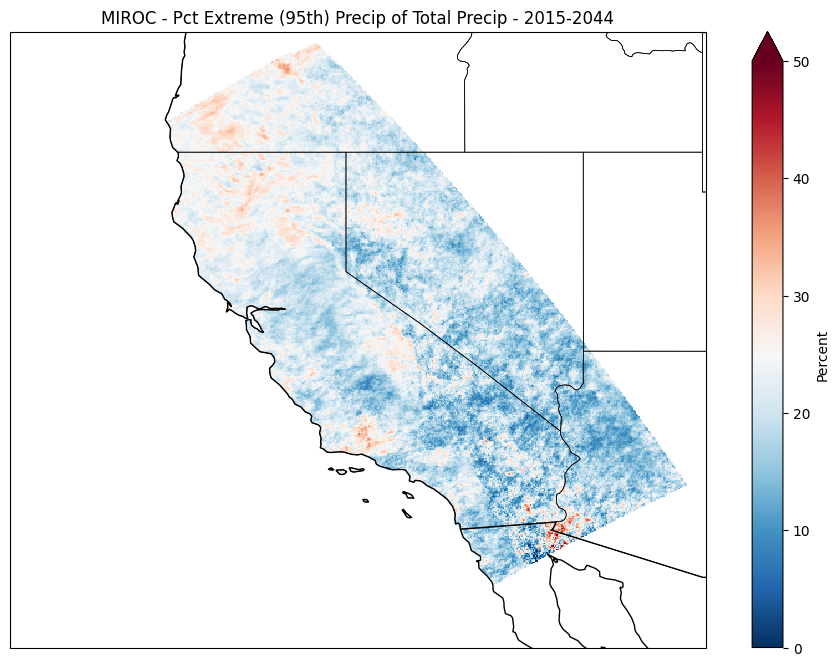

In [156]:
def map_99(netcdf_file, variable_name="total_extreme_precipitation_div_by_total_precipitation_scaled", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the 99th Percentile for PR (1950-2014) from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the pr values.
        variable_name (str): Name of the variable to plot. Defaults to "pr".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmax=50, cbar_kwargs={'label': 'Percent'})

        plt.title("MIROC - Pct Extreme (95th) Precip of Total Precip - 2015-2044")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_FLOOD_PctExtreme95_01A-4_2015-2044_MIROC.nc"  # Path to the NetCDF file with the tasmax difference

map_99(netcdf_file_path)

In [158]:
import xarray as xr
# Optional: For setting up a Dask client for better monitoring and control
# from dask.distributed import Client

def calculate_extreme_precipitation_sum_dask(
    pr_file_path,
    percentile_file_path,
    pr_variable_name='pr',
    percentile_variable_name='pr95', # Changed default to pr95 as per typical naming
    pr_chunks={'time': 'auto'},      # Dask chunks for precipitation data
    percentile_chunks={}             # Dask chunks for percentile data (often smaller, {} or 'auto' is fine)
    ):
    """
    Calculates the total precipitation from days where daily precipitation
    exceeds the 95th percentile at each lat/lon location, using Dask for out-of-core computation.

    Args:
        pr_file_path (str): Path to the NetCDF file containing daily precipitation data.
        percentile_file_path (str): Path to the NetCDF file containing the 95th percentile
                                     precipitation data.
        pr_variable_name (str, optional): Name of the precipitation variable in pr_file_path.
                                          Defaults to 'pr'.
        percentile_variable_name (str, optional): Name of the 95th percentile variable
                                                in percentile_file_path. Defaults to 'pr95'.
        pr_chunks (dict, optional): Chunking dictionary for the precipitation data.
                                   Defaults to {'time': 'auto'}.
        percentile_chunks (dict, optional): Chunking dictionary for the percentile data.
                                           Defaults to {}.

    Returns:
        xarray.DataArray: A Dask-backed DataArray containing the sum of extreme precipitation
                          at each lat/lon. Computation is triggered when writing to disk or
                          explicitly calling .compute() or .load().
                          Returns None if an error occurs.
    """
    try:
        # Open the precipitation and percentile datasets with Dask chunks
        # This makes xarray use Dask arrays, enabling out-of-core computation
        ds_pr = xr.open_dataset(pr_file_path, chunks=pr_chunks)
        ds_percentile = xr.open_dataset(percentile_file_path, chunks=percentile_chunks)

        # Extract the precipitation data and the 95th percentile data
        # Operations will now build a Dask graph
        daily_pr = ds_pr[pr_variable_name] * 86400 # This multiplication is also lazy
        percentile_95 = ds_percentile[percentile_variable_name]

        # Ensure that the percentile data can be broadcasted to the daily data.
        # If percentile_95 is small, you could .load() it into memory here
        # to potentially speed up the comparison, but it's often fine as a Dask array.
        # e.g., if ds_percentile.nbytes < some_threshold: percentile_95 = percentile_95.load()

        if 'time' in percentile_95.dims and percentile_95.sizes['time'] == 1:
            percentile_95 = percentile_95.squeeze('time', drop=True)
        elif 'time' in percentile_95.dims and percentile_95.sizes['time'] > 1:
            print("Warning: Percentile data appears to have a time dimension > 1. "
                  "This usually means it's a daily varying percentile. "
                  "Ensure this is the intended behavior. "
                  "If it's a single percentile map, it should not have a time dimension or be of size 1.")

        # Identify days where daily precipitation is above the 95th percentile
        extreme_days_mask = daily_pr > percentile_95 # Lazy operation

        # Use the mask to select only the precipitation values on extreme days
        extreme_pr = daily_pr.where(extreme_days_mask) # Lazy operation

        # Sum the precipitation from these extreme days along the 'time' dimension
        # skipna=True is important. This is still a lazy Dask operation.
        total_extreme_pr = extreme_pr.sum(dim='time', skipna=True)

        # It's good practice to give the output DataArray a name
        total_extreme_pr.name = "total_extreme_precipitation"
        total_extreme_pr.attrs['long_name'] = 'Total precipitation from days > 95th percentile (Dask)'
        if 'units' in daily_pr.attrs:
            # Assuming units of daily_pr after multiplication are mm/day equivalent
             total_extreme_pr.attrs['units'] = daily_pr.attrs.get('units_after_scaling', 'mm') # or appropriate unit
        else:
            total_extreme_pr.attrs['units'] = 'mm' # Placeholder


        # Datasets can be closed. Dask operations on arrays will still work if the data
        # needed for computation has been described in the task graph.
        # However, ensure computations that need to read metadata or re-read data chunks
        # are defined before closing if not using .persist() or .compute() earlier.
        # For simple sequential operations like this, closing here is usually fine.
        ds_pr.close()
        ds_percentile.close()

        return total_extreme_pr

    except FileNotFoundError:
        print(f"Error: One or both NetCDF files not found.")
        print(f"Precipitation file: {pr_file_path}")
        print(f"Percentile file: {percentile_file_path}")
        return None
    except KeyError as e:
        print(f"Error: Variable not found in NetCDF file. Details: {e}")
        print("Please ensure 'pr_variable_name' and 'percentile_variable_name' are correct.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # Optional: Initialize a Dask client to monitor computations
    # client = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB') # Customize as needed
    # print(f"Dask dashboard link: {client.dashboard_link}")

    # --- Configuration ---
    precipitation_filepath = 'pr.MIROC6.ssp370.r1i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc'
    percentile_filepath = 'VCP_FLOOD_PR_95pct_1950-2014_VWD_MIROC.nc'

    precip_var_name = 'pr'
    # The user's original main block explicitly uses 'pr' for the percentile variable name.
    # The function default is 'pr95', but this will override it.
    percentile_var_name = 'pr'

    # Dask chunking configuration (tune based on your data and memory)
    # 'auto' often works well. For time series, chunking time is common.
    # If lat/lon are very large, you might chunk them too e.g., {'time': 100, 'lat': 10, 'lon': 10}
    precip_chunks_config = {'time': 'auto'} # Let Dask/xarray decide chunking for time dimension
    percentile_chunks_config = {} # For smaller percentile files, default chunking or no chunking is often fine.
                                   # Or use 'auto' if it also could be large.

    # --- Calculation ---
    print("Starting calculation with Dask...")
    extreme_precipitation_sum = calculate_extreme_precipitation_sum_dask(
        precipitation_filepath,
        percentile_filepath,
        pr_variable_name=precip_var_name,
        percentile_variable_name=percentile_var_name,
        pr_chunks=precip_chunks_config,
        percentile_chunks=percentile_chunks_config
    )

    # --- Output ---
    if extreme_precipitation_sum is not None:
        print("\nSuccessfully defined Dask computation for the sum of precipitation on extreme days.")
        print("The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().")
        print(extreme_precipitation_sum) # This will show the Dask array structure, not values

        # --- Save the result to a new NetCDF file ---
        # This is where Dask will perform the actual computation and write to disk.
        output_filepath = 'VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2045-2074_MIROC.nc'
        print(f"\nAttempting to save results to: {output_filepath}")
        try:
            # When saving, Dask computes the result and writes it.
            # For very large outputs, ensure you have disk space.
            # You can also specify encoding for compression, etc.
            extreme_precipitation_sum.to_netcdf(output_filepath)
            print(f"Results successfully saved to: {output_filepath}")
        except Exception as e:
            print(f"\nError saving results to NetCDF: {e}")
            print("This error might have occurred during Dask computation or file writing.")

    # Optional: Close the Dask client if you initialized one
    # if 'client' in locals():
    # client.close()

Starting calculation with Dask...

Successfully defined Dask computation for the sum of precipitation on extreme days.
The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().
<xarray.DataArray 'total_extreme_precipitation' (lat: 495, lon: 559)> Size: 2MB
dask.array<sum-aggregate, shape=(495, 559), dtype=float64, chunksize=(495, 559), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B ...
Attributes:
    long_name:  Total precipitation from days > 95th percentile (Dask)
    units:      mm

Attempting to save results to: VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2045-2074_MIROC.nc
Results successfully saved to: VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2045-2074_MIROC.nc


In [160]:
def calculate_total_precipitation_dask(
    pr_file_path,
    pr_variable_name='pr',
    pr_chunks={'time': 'auto'}
    ):
    """
    Calculates the total precipitation at each lat/lon location,
    using Dask for out-of-core computation.

    Args:
        pr_file_path (str): Path to the NetCDF file containing daily precipitation data.
        pr_variable_name (str, optional): Name of the precipitation variable in pr_file_path.
                                          Defaults to 'pr'.
        pr_chunks (dict, optional): Chunking dictionary for the precipitation data.
                                    Defaults to {'time': 'auto'}.

    Returns:
        xarray.DataArray: A Dask-backed DataArray containing the sum of precipitation
                          at each lat/lon. Computation is triggered when writing to disk or
                          explicitly calling .compute() or .load().
                          Returns None if an error occurs.
    """
    try:
        # Open the precipitation dataset with Dask chunks
        ds_pr = xr.open_dataset(pr_file_path, chunks=pr_chunks)

        # Extract the precipitation data
        # Operations will now build a Dask graph
        daily_pr = ds_pr[pr_variable_name]

        # Optional: If your precipitation data is not already in mm/day
        # and needs conversion (e.g., from kg m-2 s-1), apply it here.
        # For example, if original units are kg m-2 s-1 (flux)
        # daily_pr_mm_day = daily_pr * 86400 # Convert to mm/day
        # If it's already in mm/day or a similar daily total, no conversion needed.
        # For this example, we'll assume daily_pr is already in appropriate daily units (e.g., mm)
        # or if it was flux, the user would handle the conversion as needed.
        # The original code had `* 86400`, so we'll keep that behavior for now
        # if the user expects it. If the input 'pr' is already daily totals,
        # this multiplication would be incorrect.
        # Let's assume the multiplication is to convert from flux to total daily amount.
        daily_pr_converted = daily_pr * 86400 # This multiplication is also lazy
        daily_pr_converted.attrs['units_after_scaling'] = 'mm' # Example unit after scaling

        # Sum the precipitation along the 'time' dimension
        # skipna=True is important. This is still a lazy Dask operation.
        total_pr = daily_pr_converted.sum(dim='time', skipna=True)

        # It's good practice to give the output DataArray a name and attributes
        total_pr.name = "total_precipitation"
        total_pr.attrs['long_name'] = 'Total precipitation (Dask)'
        if 'units_after_scaling' in daily_pr_converted.attrs:
             total_pr.attrs['units'] = daily_pr_converted.attrs['units_after_scaling']
        elif 'units' in daily_pr.attrs:
            total_pr.attrs['units'] = daily_pr.attrs['units'] # Or sum of daily units
        else:
            total_pr.attrs['units'] = 'mm' # Placeholder

        ds_pr.close()

        return total_pr

    except FileNotFoundError:
        print(f"Error: Precipitation NetCDF file not found.")
        print(f"Precipitation file: {pr_file_path}")
        return None
    except KeyError as e:
        print(f"Error: Variable '{pr_variable_name}' not found in NetCDF file. Details: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # Optional: Initialize a Dask client to monitor computations
    # client = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB') # Customize as needed
    # print(f"Dask dashboard link: {client.dashboard_link}")

    # --- Configuration ---
    precipitation_filepath = 'pr.MIROC6.ssp370.r1i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc'
    precip_var_name = 'pr'

    # Dask chunking configuration
    precip_chunks_config = {'time': 'auto'}

    # --- Calculation ---
    print("Starting calculation of total precipitation with Dask...")
    total_precipitation_sum = calculate_total_precipitation_dask(
        precipitation_filepath,
        pr_variable_name=precip_var_name,
        pr_chunks=precip_chunks_config
    )

    # --- Output ---
    if total_precipitation_sum is not None:
        print("\nSuccessfully defined Dask computation for the total precipitation.")
        print("The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().")
        print(total_precipitation_sum)

        # --- Save the result to a new NetCDF file ---
        output_filepath = 'VCP_FLOOD_PR_95pct_VWDTotalPrecip_2045-2074_MIROC.nc' # Changed output filename
        print(f"\nAttempting to save results to: {output_filepath}")
        try:
            total_precipitation_sum.to_netcdf(output_filepath)
            print(f"Results successfully saved to: {output_filepath}")
        except Exception as e:
            print(f"\nError saving results to NetCDF: {e}")
            print("This error might have occurred during Dask computation or file writing.")

    # Optional: Close the Dask client if you initialized one
    # if 'client' in locals() and client: # Check if client exists and is not None
    #     client.close()

Starting calculation of total precipitation with Dask...

Successfully defined Dask computation for the total precipitation.
The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().
<xarray.DataArray 'total_precipitation' (lat: 495, lon: 559)> Size: 2MB
dask.array<sum-aggregate, shape=(495, 559), dtype=float64, chunksize=(495, 559), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon      (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
Attributes:
    long_name:  Total precipitation (Dask)
    units:      mm

Attempting to save results to: VCP_FLOOD_PR_95pct_VWDTotalPrecip_2045-2074_MIROC.nc
Results successfully saved to: VCP_FLOOD_PR_95pct_VWDTotalPrecip_2045-2074_MIROC.nc


In [166]:
def multiply_and_divide_netcdfs(ext_filepath, tot_filepath, output_filepath,
                                ext_var_name='pr', tot_var_name='pr'):
    """
    Opens ext.nc, multiplies its data variable by 100,
    opens tot.nc, and divides the result by tot.nc's data variable.
    Saves the final result to output_filepath.

    Args:
        ext_filepath (str): Path to the 'ext.nc' NetCDF file.
        tot_filepath (str): Path to the 'tot.nc' NetCDF file.
        output_filepath (str): Path to save the resulting NetCDF file.
        ext_var_name (str, optional): Name of the variable in ext.nc.
                                      If None, uses the first data variable.
        tot_var_name (str, optional): Name of the variable in tot.nc.
                                      If None, uses the first data variable.

    Returns:
        xarray.DataArray: The resulting DataArray, or None if an error occurs.
    """
    try:
        # Open the datasets
        ds_ext = xr.open_dataset(ext_filepath)
        ds_tot = xr.open_dataset(tot_filepath)

        # Determine variable names if not provided
        if ext_var_name is None:
            ext_var_name = get_first_data_variable_name(ds_ext)
            print(f"Using inferred variable '{ext_var_name}' from '{ext_filepath}'")
        if tot_var_name is None:
            tot_var_name = get_first_data_variable_name(ds_tot)
            print(f"Using inferred variable '{tot_var_name}' from '{tot_filepath}'")

        # Extract the DataArrays
        ext_data = ds_ext[ext_var_name]
        tot_data = ds_tot[tot_var_name]

        # Perform the calculation: (ext_data * 100) / tot_data
        print(f"\nPerforming operation: ({ext_var_name} * 100) / {tot_var_name}")
        
        scaled_ext_data = ext_data * 100
        result_data = scaled_ext_data / tot_data

        # Handle potential division by zero explicitly if you want something other than inf/NaN
        # For example, to set results to NaN where tot_data is zero:
        # result_data = xr.where(tot_data == 0, np.nan, scaled_ext_data / tot_data)
        # Xarray by default will produce `inf` or `NaN` which is often acceptable.

        # Assign a name and attributes to the result for clarity in the output file
        result_data.name = f"{ext_var_name}_div_by_{tot_var_name}_scaled"
        result_data.attrs['long_name'] = (f"({ext_var_name} * 100) / {tot_var_name}")
        result_data.attrs['units'] = f"({ext_data.attrs.get('units', 'unknown')} * 100) / {tot_data.attrs.get('units', 'unknown')}"
        result_data.attrs['operation_description'] = (
            f"Data from variable '{ext_var_name}' in '{ext_filepath}' was multiplied by 100, "
            f"then divided by data from variable '{tot_var_name}' in '{tot_filepath}'."
        )


        # Save the result to a new NetCDF file
        result_data.to_netcdf(output_filepath)
        print(f"\nResult successfully saved to: {output_filepath}")

        # Close the datasets
        ds_ext.close()
        ds_tot.close()

        return result_data

    except FileNotFoundError as e:
        print(f"Error: File not found. Details: {e}")
        return None
    except KeyError as e:
        print(f"Error: Variable not found in NetCDF file. Details: {e}")
        print("Please ensure 'ext_var_name' and 'tot_var_name' are correct if you specified them.")
        return None
    except ValueError as e: # For issues like no data variables
        print(f"Error: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # --- Configuration ---
    # Replace with the actual paths to your files
    ext_netcdf_file = 'VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2045-2074_MIROC.nc'
    tot_netcdf_file = 'VCP_FLOOD_PR_95pct_VWDTotalPrecip_2045-2074_MIROC.nc'
    output_netcdf_file = 'VCP_FLOOD_PctExtreme95_01B-4_2045-2074_MIROC.nc'

    # Optional: Specify variable names if you know them and want to be explicit,
    # or if the files have multiple data variables and you don't want the first one.
    # If set to None, the script will try to use the first data variable found.
    ext_variable = 'total_extreme_precipitation'  # e.g., 'precipitation_flux' or 'extreme_sum'
    tot_variable = 'total_precipitation'  # e.g., 'total_precipitation'

    # --- Perform Calculation ---
    calculated_result = multiply_and_divide_netcdfs(
        ext_netcdf_file,
        tot_netcdf_file,
        output_netcdf_file,
        ext_var_name=ext_variable,
        tot_var_name=tot_variable
    )

    if calculated_result is not None:
        print("\n--- Result DataArray ---")
        print(calculated_result)
        # You can further analyze or plot 'calculated_result' here if needed
        # For example:
        # import matplotlib.pyplot as plt
        # if 'lat' in calculated_result.dims and 'lon' in calculated_result.dims:
        #     if len(calculated_result.dims) == 2: # Simple 2D plot
        #         calculated_result.plot()
        #         plt.show()
        #     elif 'time' in calculated_result.dims and calculated_result.sizes['time'] > 0: # Plot first time step of 3D data
        #         calculated_result.isel(time=0).plot()
        #         plt.show()


Performing operation: (total_extreme_precipitation * 100) / total_precipitation

Result successfully saved to: VCP_FLOOD_PctExtreme95_01B-4_2045-2074_MIROC.nc

--- Result DataArray ---
<xarray.DataArray 'total_extreme_precipitation_div_by_total_precipitation_scaled' (
                                                                                   lat: 495,
                                                                                   lon: 559)> Size: 2MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B ...
Attributes:
    long_name:              (total_extreme_pre

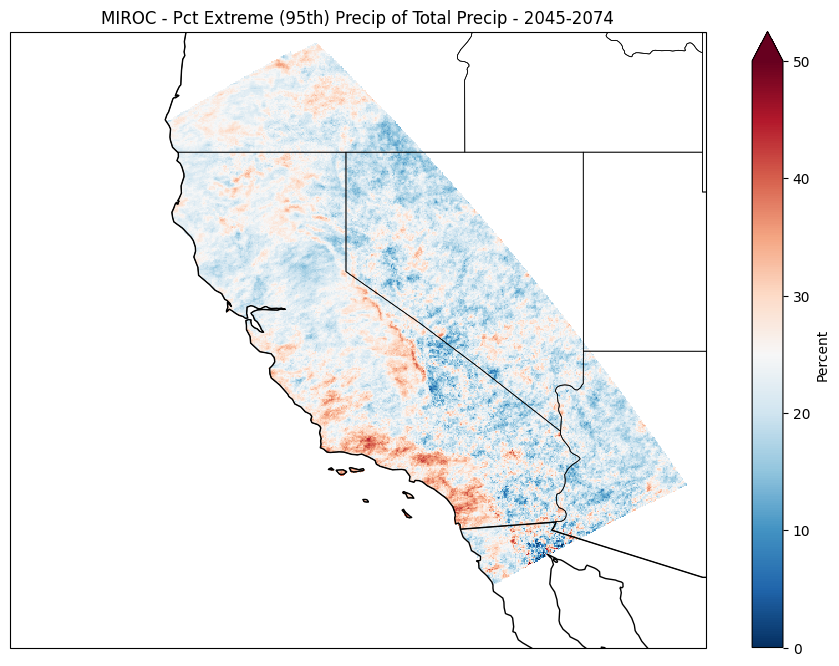

In [168]:
def map_99(netcdf_file, variable_name="total_extreme_precipitation_div_by_total_precipitation_scaled", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the 99th Percentile for PR (1950-2014) from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the pr values.
        variable_name (str): Name of the variable to plot. Defaults to "pr".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmax=50, cbar_kwargs={'label': 'Percent'})

        plt.title("MIROC - Pct Extreme (95th) Precip of Total Precip - 2045-2074")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_FLOOD_PctExtreme95_01B-4_2045-2074_MIROC.nc"  # Path to the NetCDF file with the tasmax difference

map_99(netcdf_file_path)

In [ ]:
# - MPI - Pct Precip on VWD / Total Precip

In [170]:
import xarray as xr
# Optional: For setting up a Dask client for better monitoring and control
# from dask.distributed import Client

def calculate_extreme_precipitation_sum_dask(
    pr_file_path,
    percentile_file_path,
    pr_variable_name='pr',
    percentile_variable_name='pr95', # Changed default to pr95 as per typical naming
    pr_chunks={'time': 'auto'},      # Dask chunks for precipitation data
    percentile_chunks={}             # Dask chunks for percentile data (often smaller, {} or 'auto' is fine)
    ):
    """
    Calculates the total precipitation from days where daily precipitation
    exceeds the 95th percentile at each lat/lon location, using Dask for out-of-core computation.

    Args:
        pr_file_path (str): Path to the NetCDF file containing daily precipitation data.
        percentile_file_path (str): Path to the NetCDF file containing the 95th percentile
                                     precipitation data.
        pr_variable_name (str, optional): Name of the precipitation variable in pr_file_path.
                                          Defaults to 'pr'.
        percentile_variable_name (str, optional): Name of the 95th percentile variable
                                                in percentile_file_path. Defaults to 'pr95'.
        pr_chunks (dict, optional): Chunking dictionary for the precipitation data.
                                   Defaults to {'time': 'auto'}.
        percentile_chunks (dict, optional): Chunking dictionary for the percentile data.
                                           Defaults to {}.

    Returns:
        xarray.DataArray: A Dask-backed DataArray containing the sum of extreme precipitation
                          at each lat/lon. Computation is triggered when writing to disk or
                          explicitly calling .compute() or .load().
                          Returns None if an error occurs.
    """
    try:
        # Open the precipitation and percentile datasets with Dask chunks
        # This makes xarray use Dask arrays, enabling out-of-core computation
        ds_pr = xr.open_dataset(pr_file_path, chunks=pr_chunks)
        ds_percentile = xr.open_dataset(percentile_file_path, chunks=percentile_chunks)

        # Extract the precipitation data and the 95th percentile data
        # Operations will now build a Dask graph
        daily_pr = ds_pr[pr_variable_name] * 86400 # This multiplication is also lazy
        percentile_95 = ds_percentile[percentile_variable_name]

        # Ensure that the percentile data can be broadcasted to the daily data.
        # If percentile_95 is small, you could .load() it into memory here
        # to potentially speed up the comparison, but it's often fine as a Dask array.
        # e.g., if ds_percentile.nbytes < some_threshold: percentile_95 = percentile_95.load()

        if 'time' in percentile_95.dims and percentile_95.sizes['time'] == 1:
            percentile_95 = percentile_95.squeeze('time', drop=True)
        elif 'time' in percentile_95.dims and percentile_95.sizes['time'] > 1:
            print("Warning: Percentile data appears to have a time dimension > 1. "
                  "This usually means it's a daily varying percentile. "
                  "Ensure this is the intended behavior. "
                  "If it's a single percentile map, it should not have a time dimension or be of size 1.")

        # Identify days where daily precipitation is above the 95th percentile
        extreme_days_mask = daily_pr > percentile_95 # Lazy operation

        # Use the mask to select only the precipitation values on extreme days
        extreme_pr = daily_pr.where(extreme_days_mask) # Lazy operation

        # Sum the precipitation from these extreme days along the 'time' dimension
        # skipna=True is important. This is still a lazy Dask operation.
        total_extreme_pr = extreme_pr.sum(dim='time', skipna=True)

        # It's good practice to give the output DataArray a name
        total_extreme_pr.name = "total_extreme_precipitation"
        total_extreme_pr.attrs['long_name'] = 'Total precipitation from days > 95th percentile (Dask)'
        if 'units' in daily_pr.attrs:
            # Assuming units of daily_pr after multiplication are mm/day equivalent
             total_extreme_pr.attrs['units'] = daily_pr.attrs.get('units_after_scaling', 'mm') # or appropriate unit
        else:
            total_extreme_pr.attrs['units'] = 'mm' # Placeholder


        # Datasets can be closed. Dask operations on arrays will still work if the data
        # needed for computation has been described in the task graph.
        # However, ensure computations that need to read metadata or re-read data chunks
        # are defined before closing if not using .persist() or .compute() earlier.
        # For simple sequential operations like this, closing here is usually fine.
        ds_pr.close()
        ds_percentile.close()

        return total_extreme_pr

    except FileNotFoundError:
        print(f"Error: One or both NetCDF files not found.")
        print(f"Precipitation file: {pr_file_path}")
        print(f"Percentile file: {percentile_file_path}")
        return None
    except KeyError as e:
        print(f"Error: Variable not found in NetCDF file. Details: {e}")
        print("Please ensure 'pr_variable_name' and 'percentile_variable_name' are correct.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # Optional: Initialize a Dask client to monitor computations
    # client = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB') # Customize as needed
    # print(f"Dask dashboard link: {client.dashboard_link}")

    # --- Configuration ---
    precipitation_filepath = 'pr.MPI-ESM1-2-HR.ssp370.r3i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc'
    percentile_filepath = 'VCP_FLOOD_PR_95pct_1950-2014_VWD_MPI.nc'

    precip_var_name = 'pr'
    # The user's original main block explicitly uses 'pr' for the percentile variable name.
    # The function default is 'pr95', but this will override it.
    percentile_var_name = 'pr'

    # Dask chunking configuration (tune based on your data and memory)
    # 'auto' often works well. For time series, chunking time is common.
    # If lat/lon are very large, you might chunk them too e.g., {'time': 100, 'lat': 10, 'lon': 10}
    precip_chunks_config = {'time': 'auto'} # Let Dask/xarray decide chunking for time dimension
    percentile_chunks_config = {} # For smaller percentile files, default chunking or no chunking is often fine.
                                   # Or use 'auto' if it also could be large.

    # --- Calculation ---
    print("Starting calculation with Dask...")
    extreme_precipitation_sum = calculate_extreme_precipitation_sum_dask(
        precipitation_filepath,
        percentile_filepath,
        pr_variable_name=precip_var_name,
        percentile_variable_name=percentile_var_name,
        pr_chunks=precip_chunks_config,
        percentile_chunks=percentile_chunks_config
    )

    # --- Output ---
    if extreme_precipitation_sum is not None:
        print("\nSuccessfully defined Dask computation for the sum of precipitation on extreme days.")
        print("The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().")
        print(extreme_precipitation_sum) # This will show the Dask array structure, not values

        # --- Save the result to a new NetCDF file ---
        # This is where Dask will perform the actual computation and write to disk.
        output_filepath = 'VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2015-2044_MPI.nc'
        print(f"\nAttempting to save results to: {output_filepath}")
        try:
            # When saving, Dask computes the result and writes it.
            # For very large outputs, ensure you have disk space.
            # You can also specify encoding for compression, etc.
            extreme_precipitation_sum.to_netcdf(output_filepath)
            print(f"Results successfully saved to: {output_filepath}")
        except Exception as e:
            print(f"\nError saving results to NetCDF: {e}")
            print("This error might have occurred during Dask computation or file writing.")

    # Optional: Close the Dask client if you initialized one
    # if 'client' in locals():
    # client.close()

Starting calculation with Dask...

Successfully defined Dask computation for the sum of precipitation on extreme days.
The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().
<xarray.DataArray 'total_extreme_precipitation' (lat: 495, lon: 559)> Size: 2MB
dask.array<sum-aggregate, shape=(495, 559), dtype=float64, chunksize=(495, 559), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B ...
Attributes:
    long_name:  Total precipitation from days > 95th percentile (Dask)
    units:      mm

Attempting to save results to: VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2015-2044_MPI.nc
Results successfully saved to: VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2015-2044_MPI.nc


In [172]:
def calculate_total_precipitation_dask(
    pr_file_path,
    pr_variable_name='pr',
    pr_chunks={'time': 'auto'}
    ):
    """
    Calculates the total precipitation at each lat/lon location,
    using Dask for out-of-core computation.

    Args:
        pr_file_path (str): Path to the NetCDF file containing daily precipitation data.
        pr_variable_name (str, optional): Name of the precipitation variable in pr_file_path.
                                          Defaults to 'pr'.
        pr_chunks (dict, optional): Chunking dictionary for the precipitation data.
                                    Defaults to {'time': 'auto'}.

    Returns:
        xarray.DataArray: A Dask-backed DataArray containing the sum of precipitation
                          at each lat/lon. Computation is triggered when writing to disk or
                          explicitly calling .compute() or .load().
                          Returns None if an error occurs.
    """
    try:
        # Open the precipitation dataset with Dask chunks
        ds_pr = xr.open_dataset(pr_file_path, chunks=pr_chunks)

        # Extract the precipitation data
        # Operations will now build a Dask graph
        daily_pr = ds_pr[pr_variable_name]

        # Optional: If your precipitation data is not already in mm/day
        # and needs conversion (e.g., from kg m-2 s-1), apply it here.
        # For example, if original units are kg m-2 s-1 (flux)
        # daily_pr_mm_day = daily_pr * 86400 # Convert to mm/day
        # If it's already in mm/day or a similar daily total, no conversion needed.
        # For this example, we'll assume daily_pr is already in appropriate daily units (e.g., mm)
        # or if it was flux, the user would handle the conversion as needed.
        # The original code had `* 86400`, so we'll keep that behavior for now
        # if the user expects it. If the input 'pr' is already daily totals,
        # this multiplication would be incorrect.
        # Let's assume the multiplication is to convert from flux to total daily amount.
        daily_pr_converted = daily_pr * 86400 # This multiplication is also lazy
        daily_pr_converted.attrs['units_after_scaling'] = 'mm' # Example unit after scaling

        # Sum the precipitation along the 'time' dimension
        # skipna=True is important. This is still a lazy Dask operation.
        total_pr = daily_pr_converted.sum(dim='time', skipna=True)

        # It's good practice to give the output DataArray a name and attributes
        total_pr.name = "total_precipitation"
        total_pr.attrs['long_name'] = 'Total precipitation (Dask)'
        if 'units_after_scaling' in daily_pr_converted.attrs:
             total_pr.attrs['units'] = daily_pr_converted.attrs['units_after_scaling']
        elif 'units' in daily_pr.attrs:
            total_pr.attrs['units'] = daily_pr.attrs['units'] # Or sum of daily units
        else:
            total_pr.attrs['units'] = 'mm' # Placeholder

        ds_pr.close()

        return total_pr

    except FileNotFoundError:
        print(f"Error: Precipitation NetCDF file not found.")
        print(f"Precipitation file: {pr_file_path}")
        return None
    except KeyError as e:
        print(f"Error: Variable '{pr_variable_name}' not found in NetCDF file. Details: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # Optional: Initialize a Dask client to monitor computations
    # client = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB') # Customize as needed
    # print(f"Dask dashboard link: {client.dashboard_link}")

    # --- Configuration ---
    precipitation_filepath = 'pr.MPI-ESM1-2-HR.ssp370.r3i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc'
    precip_var_name = 'pr'

    # Dask chunking configuration
    precip_chunks_config = {'time': 'auto'}

    # --- Calculation ---
    print("Starting calculation of total precipitation with Dask...")
    total_precipitation_sum = calculate_total_precipitation_dask(
        precipitation_filepath,
        pr_variable_name=precip_var_name,
        pr_chunks=precip_chunks_config
    )

    # --- Output ---
    if total_precipitation_sum is not None:
        print("\nSuccessfully defined Dask computation for the total precipitation.")
        print("The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().")
        print(total_precipitation_sum)

        # --- Save the result to a new NetCDF file ---
        output_filepath = 'VCP_FLOOD_PR_95pct_VWDTotalPrecip_2015-2044_MPI.nc' # Changed output filename
        print(f"\nAttempting to save results to: {output_filepath}")
        try:
            total_precipitation_sum.to_netcdf(output_filepath)
            print(f"Results successfully saved to: {output_filepath}")
        except Exception as e:
            print(f"\nError saving results to NetCDF: {e}")
            print("This error might have occurred during Dask computation or file writing.")

    # Optional: Close the Dask client if you initialized one
    # if 'client' in locals() and client: # Check if client exists and is not None
    #     client.close()

Starting calculation of total precipitation with Dask...

Successfully defined Dask computation for the total precipitation.
The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().
<xarray.DataArray 'total_precipitation' (lat: 495, lon: 559)> Size: 2MB
dask.array<sum-aggregate, shape=(495, 559), dtype=float64, chunksize=(495, 559), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon      (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
Attributes:
    long_name:  Total precipitation (Dask)
    units:      mm

Attempting to save results to: VCP_FLOOD_PR_95pct_VWDTotalPrecip_2015-2044_MPI.nc
Results successfully saved to: VCP_FLOOD_PR_95pct_VWDTotalPrecip_2015-2044_MPI.nc


In [184]:
def multiply_and_divide_netcdfs(ext_filepath, tot_filepath, output_filepath,
                                ext_var_name='pr', tot_var_name='pr'):
    """
    Opens ext.nc, multiplies its data variable by 100,
    opens tot.nc, and divides the result by tot.nc's data variable.
    Saves the final result to output_filepath.

    Args:
        ext_filepath (str): Path to the 'ext.nc' NetCDF file.
        tot_filepath (str): Path to the 'tot.nc' NetCDF file.
        output_filepath (str): Path to save the resulting NetCDF file.
        ext_var_name (str, optional): Name of the variable in ext.nc.
                                      If None, uses the first data variable.
        tot_var_name (str, optional): Name of the variable in tot.nc.
                                      If None, uses the first data variable.

    Returns:
        xarray.DataArray: The resulting DataArray, or None if an error occurs.
    """
    try:
        # Open the datasets
        ds_ext = xr.open_dataset(ext_filepath)
        ds_tot = xr.open_dataset(tot_filepath)

        # Determine variable names if not provided
        if ext_var_name is None:
            ext_var_name = get_first_data_variable_name(ds_ext)
            print(f"Using inferred variable '{ext_var_name}' from '{ext_filepath}'")
        if tot_var_name is None:
            tot_var_name = get_first_data_variable_name(ds_tot)
            print(f"Using inferred variable '{tot_var_name}' from '{tot_filepath}'")

        # Extract the DataArrays
        ext_data = ds_ext[ext_var_name]
        tot_data = ds_tot[tot_var_name]

        # Perform the calculation: (ext_data * 100) / tot_data
        print(f"\nPerforming operation: ({ext_var_name} * 100) / {tot_var_name}")
        
        scaled_ext_data = ext_data * 100
        result_data = scaled_ext_data / tot_data

        # Handle potential division by zero explicitly if you want something other than inf/NaN
        # For example, to set results to NaN where tot_data is zero:
        # result_data = xr.where(tot_data == 0, np.nan, scaled_ext_data / tot_data)
        # Xarray by default will produce `inf` or `NaN` which is often acceptable.

        # Assign a name and attributes to the result for clarity in the output file
        result_data.name = f"{ext_var_name}_div_by_{tot_var_name}_scaled"
        result_data.attrs['long_name'] = (f"({ext_var_name} * 100) / {tot_var_name}")
        result_data.attrs['units'] = f"({ext_data.attrs.get('units', 'unknown')} * 100) / {tot_data.attrs.get('units', 'unknown')}"
        result_data.attrs['operation_description'] = (
            f"Data from variable '{ext_var_name}' in '{ext_filepath}' was multiplied by 100, "
            f"then divided by data from variable '{tot_var_name}' in '{tot_filepath}'."
        )


        # Save the result to a new NetCDF file
        result_data.to_netcdf(output_filepath)
        print(f"\nResult successfully saved to: {output_filepath}")

        # Close the datasets
        ds_ext.close()
        ds_tot.close()

        return result_data

    except FileNotFoundError as e:
        print(f"Error: File not found. Details: {e}")
        return None
    except KeyError as e:
        print(f"Error: Variable not found in NetCDF file. Details: {e}")
        print("Please ensure 'ext_var_name' and 'tot_var_name' are correct if you specified them.")
        return None
    except ValueError as e: # For issues like no data variables
        print(f"Error: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # --- Configuration ---
    # Replace with the actual paths to your files
    ext_netcdf_file = 'VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2015-2044_MPI.nc'
    tot_netcdf_file = 'VCP_FLOOD_PR_95pct_VWDTotalPrecip_2015-2044_MPI.nc'
    output_netcdf_file = 'VCP_FLOOD_PctExtreme95_01A-5_2015-2044_MPI.nc'

    # Optional: Specify variable names if you know them and want to be explicit,
    # or if the files have multiple data variables and you don't want the first one.
    # If set to None, the script will try to use the first data variable found.
    ext_variable = 'total_extreme_precipitation'  # e.g., 'precipitation_flux' or 'extreme_sum'
    tot_variable = 'total_precipitation'  # e.g., 'total_precipitation'

    # --- Perform Calculation ---
    calculated_result = multiply_and_divide_netcdfs(
        ext_netcdf_file,
        tot_netcdf_file,
        output_netcdf_file,
        ext_var_name=ext_variable,
        tot_var_name=tot_variable
    )

    if calculated_result is not None:
        print("\n--- Result DataArray ---")
        print(calculated_result)
        # You can further analyze or plot 'calculated_result' here if needed
        # For example:
        # import matplotlib.pyplot as plt
        # if 'lat' in calculated_result.dims and 'lon' in calculated_result.dims:
        #     if len(calculated_result.dims) == 2: # Simple 2D plot
        #         calculated_result.plot()
        #         plt.show()
        #     elif 'time' in calculated_result.dims and calculated_result.sizes['time'] > 0: # Plot first time step of 3D data
        #         calculated_result.isel(time=0).plot()
        #         plt.show()


Performing operation: (total_extreme_precipitation * 100) / total_precipitation

Result successfully saved to: VCP_FLOOD_PctExtreme95_01A-5_2015-2044_MPI.nc

--- Result DataArray ---
<xarray.DataArray 'total_extreme_precipitation_div_by_total_precipitation_scaled' (
                                                                                   lat: 495,
                                                                                   lon: 559)> Size: 2MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B ...
Attributes:
    long_name:              (total_extreme_preci

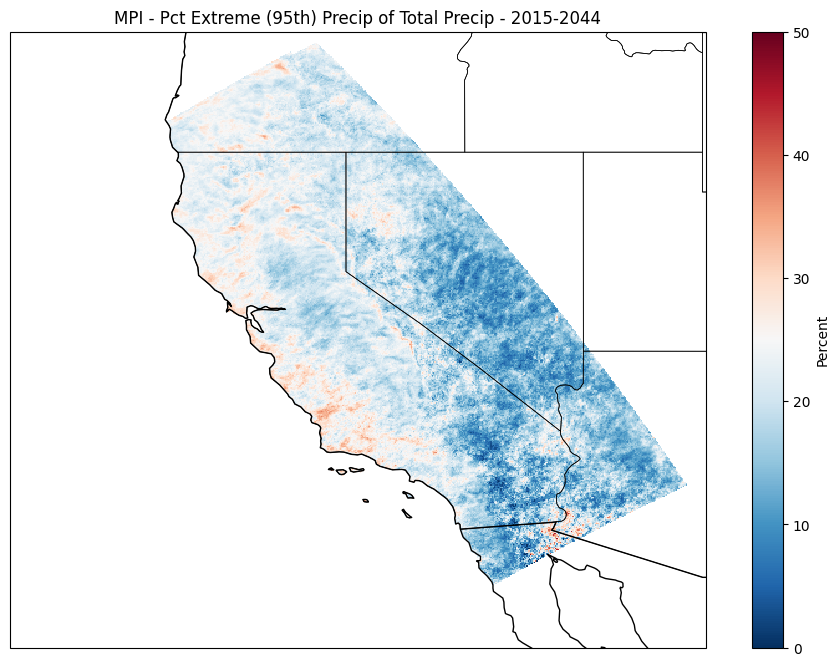

In [186]:
def map_99(netcdf_file, variable_name="total_extreme_precipitation_div_by_total_precipitation_scaled", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the 99th Percentile for PR (1950-2014) from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the pr values.
        variable_name (str): Name of the variable to plot. Defaults to "pr".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmax=50, cbar_kwargs={'label': 'Percent'})

        plt.title("MPI - Pct Extreme (95th) Precip of Total Precip - 2015-2044")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_FLOOD_PctExtreme95_01A-1_2015-2044_MPI.nc"  # Path to the NetCDF file with the tasmax difference

map_99(netcdf_file_path)

In [178]:
import xarray as xr
# Optional: For setting up a Dask client for better monitoring and control
# from dask.distributed import Client

def calculate_extreme_precipitation_sum_dask(
    pr_file_path,
    percentile_file_path,
    pr_variable_name='pr',
    percentile_variable_name='pr95', # Changed default to pr95 as per typical naming
    pr_chunks={'time': 'auto'},      # Dask chunks for precipitation data
    percentile_chunks={}             # Dask chunks for percentile data (often smaller, {} or 'auto' is fine)
    ):
    """
    Calculates the total precipitation from days where daily precipitation
    exceeds the 95th percentile at each lat/lon location, using Dask for out-of-core computation.

    Args:
        pr_file_path (str): Path to the NetCDF file containing daily precipitation data.
        percentile_file_path (str): Path to the NetCDF file containing the 95th percentile
                                     precipitation data.
        pr_variable_name (str, optional): Name of the precipitation variable in pr_file_path.
                                          Defaults to 'pr'.
        percentile_variable_name (str, optional): Name of the 95th percentile variable
                                                in percentile_file_path. Defaults to 'pr95'.
        pr_chunks (dict, optional): Chunking dictionary for the precipitation data.
                                   Defaults to {'time': 'auto'}.
        percentile_chunks (dict, optional): Chunking dictionary for the percentile data.
                                           Defaults to {}.

    Returns:
        xarray.DataArray: A Dask-backed DataArray containing the sum of extreme precipitation
                          at each lat/lon. Computation is triggered when writing to disk or
                          explicitly calling .compute() or .load().
                          Returns None if an error occurs.
    """
    try:
        # Open the precipitation and percentile datasets with Dask chunks
        # This makes xarray use Dask arrays, enabling out-of-core computation
        ds_pr = xr.open_dataset(pr_file_path, chunks=pr_chunks)
        ds_percentile = xr.open_dataset(percentile_file_path, chunks=percentile_chunks)

        # Extract the precipitation data and the 95th percentile data
        # Operations will now build a Dask graph
        daily_pr = ds_pr[pr_variable_name] * 86400 # This multiplication is also lazy
        percentile_95 = ds_percentile[percentile_variable_name]

        # Ensure that the percentile data can be broadcasted to the daily data.
        # If percentile_95 is small, you could .load() it into memory here
        # to potentially speed up the comparison, but it's often fine as a Dask array.
        # e.g., if ds_percentile.nbytes < some_threshold: percentile_95 = percentile_95.load()

        if 'time' in percentile_95.dims and percentile_95.sizes['time'] == 1:
            percentile_95 = percentile_95.squeeze('time', drop=True)
        elif 'time' in percentile_95.dims and percentile_95.sizes['time'] > 1:
            print("Warning: Percentile data appears to have a time dimension > 1. "
                  "This usually means it's a daily varying percentile. "
                  "Ensure this is the intended behavior. "
                  "If it's a single percentile map, it should not have a time dimension or be of size 1.")

        # Identify days where daily precipitation is above the 95th percentile
        extreme_days_mask = daily_pr > percentile_95 # Lazy operation

        # Use the mask to select only the precipitation values on extreme days
        extreme_pr = daily_pr.where(extreme_days_mask) # Lazy operation

        # Sum the precipitation from these extreme days along the 'time' dimension
        # skipna=True is important. This is still a lazy Dask operation.
        total_extreme_pr = extreme_pr.sum(dim='time', skipna=True)

        # It's good practice to give the output DataArray a name
        total_extreme_pr.name = "total_extreme_precipitation"
        total_extreme_pr.attrs['long_name'] = 'Total precipitation from days > 95th percentile (Dask)'
        if 'units' in daily_pr.attrs:
            # Assuming units of daily_pr after multiplication are mm/day equivalent
             total_extreme_pr.attrs['units'] = daily_pr.attrs.get('units_after_scaling', 'mm') # or appropriate unit
        else:
            total_extreme_pr.attrs['units'] = 'mm' # Placeholder


        # Datasets can be closed. Dask operations on arrays will still work if the data
        # needed for computation has been described in the task graph.
        # However, ensure computations that need to read metadata or re-read data chunks
        # are defined before closing if not using .persist() or .compute() earlier.
        # For simple sequential operations like this, closing here is usually fine.
        ds_pr.close()
        ds_percentile.close()

        return total_extreme_pr

    except FileNotFoundError:
        print(f"Error: One or both NetCDF files not found.")
        print(f"Precipitation file: {pr_file_path}")
        print(f"Percentile file: {percentile_file_path}")
        return None
    except KeyError as e:
        print(f"Error: Variable not found in NetCDF file. Details: {e}")
        print("Please ensure 'pr_variable_name' and 'percentile_variable_name' are correct.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # Optional: Initialize a Dask client to monitor computations
    # client = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB') # Customize as needed
    # print(f"Dask dashboard link: {client.dashboard_link}")

    # --- Configuration ---
    precipitation_filepath = 'pr.MPI-ESM1-2-HR.ssp370.r3i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc'
    percentile_filepath = 'VCP_FLOOD_PR_95pct_1950-2014_VWD_MPI.nc'

    precip_var_name = 'pr'
    # The user's original main block explicitly uses 'pr' for the percentile variable name.
    # The function default is 'pr95', but this will override it.
    percentile_var_name = 'pr'

    # Dask chunking configuration (tune based on your data and memory)
    # 'auto' often works well. For time series, chunking time is common.
    # If lat/lon are very large, you might chunk them too e.g., {'time': 100, 'lat': 10, 'lon': 10}
    precip_chunks_config = {'time': 'auto'} # Let Dask/xarray decide chunking for time dimension
    percentile_chunks_config = {} # For smaller percentile files, default chunking or no chunking is often fine.
                                   # Or use 'auto' if it also could be large.

    # --- Calculation ---
    print("Starting calculation with Dask...")
    extreme_precipitation_sum = calculate_extreme_precipitation_sum_dask(
        precipitation_filepath,
        percentile_filepath,
        pr_variable_name=precip_var_name,
        percentile_variable_name=percentile_var_name,
        pr_chunks=precip_chunks_config,
        percentile_chunks=percentile_chunks_config
    )

    # --- Output ---
    if extreme_precipitation_sum is not None:
        print("\nSuccessfully defined Dask computation for the sum of precipitation on extreme days.")
        print("The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().")
        print(extreme_precipitation_sum) # This will show the Dask array structure, not values

        # --- Save the result to a new NetCDF file ---
        # This is where Dask will perform the actual computation and write to disk.
        output_filepath = 'VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2045-2074_MPI.nc'
        print(f"\nAttempting to save results to: {output_filepath}")
        try:
            # When saving, Dask computes the result and writes it.
            # For very large outputs, ensure you have disk space.
            # You can also specify encoding for compression, etc.
            extreme_precipitation_sum.to_netcdf(output_filepath)
            print(f"Results successfully saved to: {output_filepath}")
        except Exception as e:
            print(f"\nError saving results to NetCDF: {e}")
            print("This error might have occurred during Dask computation or file writing.")

    # Optional: Close the Dask client if you initialized one
    # if 'client' in locals():
    # client.close()

Starting calculation with Dask...

Successfully defined Dask computation for the sum of precipitation on extreme days.
The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().
<xarray.DataArray 'total_extreme_precipitation' (lat: 495, lon: 559)> Size: 2MB
dask.array<sum-aggregate, shape=(495, 559), dtype=float64, chunksize=(495, 559), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B ...
Attributes:
    long_name:  Total precipitation from days > 95th percentile (Dask)
    units:      mm

Attempting to save results to: VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2045-2074_MPI.nc
Results successfully saved to: VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2045-2074_MPI.nc


In [180]:
def calculate_total_precipitation_dask(
    pr_file_path,
    pr_variable_name='pr',
    pr_chunks={'time': 'auto'}
    ):
    """
    Calculates the total precipitation at each lat/lon location,
    using Dask for out-of-core computation.

    Args:
        pr_file_path (str): Path to the NetCDF file containing daily precipitation data.
        pr_variable_name (str, optional): Name of the precipitation variable in pr_file_path.
                                          Defaults to 'pr'.
        pr_chunks (dict, optional): Chunking dictionary for the precipitation data.
                                    Defaults to {'time': 'auto'}.

    Returns:
        xarray.DataArray: A Dask-backed DataArray containing the sum of precipitation
                          at each lat/lon. Computation is triggered when writing to disk or
                          explicitly calling .compute() or .load().
                          Returns None if an error occurs.
    """
    try:
        # Open the precipitation dataset with Dask chunks
        ds_pr = xr.open_dataset(pr_file_path, chunks=pr_chunks)

        # Extract the precipitation data
        # Operations will now build a Dask graph
        daily_pr = ds_pr[pr_variable_name]

        # Optional: If your precipitation data is not already in mm/day
        # and needs conversion (e.g., from kg m-2 s-1), apply it here.
        # For example, if original units are kg m-2 s-1 (flux)
        # daily_pr_mm_day = daily_pr * 86400 # Convert to mm/day
        # If it's already in mm/day or a similar daily total, no conversion needed.
        # For this example, we'll assume daily_pr is already in appropriate daily units (e.g., mm)
        # or if it was flux, the user would handle the conversion as needed.
        # The original code had `* 86400`, so we'll keep that behavior for now
        # if the user expects it. If the input 'pr' is already daily totals,
        # this multiplication would be incorrect.
        # Let's assume the multiplication is to convert from flux to total daily amount.
        daily_pr_converted = daily_pr * 86400 # This multiplication is also lazy
        daily_pr_converted.attrs['units_after_scaling'] = 'mm' # Example unit after scaling

        # Sum the precipitation along the 'time' dimension
        # skipna=True is important. This is still a lazy Dask operation.
        total_pr = daily_pr_converted.sum(dim='time', skipna=True)

        # It's good practice to give the output DataArray a name and attributes
        total_pr.name = "total_precipitation"
        total_pr.attrs['long_name'] = 'Total precipitation (Dask)'
        if 'units_after_scaling' in daily_pr_converted.attrs:
             total_pr.attrs['units'] = daily_pr_converted.attrs['units_after_scaling']
        elif 'units' in daily_pr.attrs:
            total_pr.attrs['units'] = daily_pr.attrs['units'] # Or sum of daily units
        else:
            total_pr.attrs['units'] = 'mm' # Placeholder

        ds_pr.close()

        return total_pr

    except FileNotFoundError:
        print(f"Error: Precipitation NetCDF file not found.")
        print(f"Precipitation file: {pr_file_path}")
        return None
    except KeyError as e:
        print(f"Error: Variable '{pr_variable_name}' not found in NetCDF file. Details: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # Optional: Initialize a Dask client to monitor computations
    # client = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB') # Customize as needed
    # print(f"Dask dashboard link: {client.dashboard_link}")

    # --- Configuration ---
    precipitation_filepath = 'pr.MPI-ESM1-2-HR.ssp370.r3i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc'
    precip_var_name = 'pr'

    # Dask chunking configuration
    precip_chunks_config = {'time': 'auto'}

    # --- Calculation ---
    print("Starting calculation of total precipitation with Dask...")
    total_precipitation_sum = calculate_total_precipitation_dask(
        precipitation_filepath,
        pr_variable_name=precip_var_name,
        pr_chunks=precip_chunks_config
    )

    # --- Output ---
    if total_precipitation_sum is not None:
        print("\nSuccessfully defined Dask computation for the total precipitation.")
        print("The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().")
        print(total_precipitation_sum)

        # --- Save the result to a new NetCDF file ---
        output_filepath = 'VCP_FLOOD_PR_95pct_VWDTotalPrecip_2045-2074_MPI.nc' # Changed output filename
        print(f"\nAttempting to save results to: {output_filepath}")
        try:
            total_precipitation_sum.to_netcdf(output_filepath)
            print(f"Results successfully saved to: {output_filepath}")
        except Exception as e:
            print(f"\nError saving results to NetCDF: {e}")
            print("This error might have occurred during Dask computation or file writing.")

    # Optional: Close the Dask client if you initialized one
    # if 'client' in locals() and client: # Check if client exists and is not None
    #     client.close()

Starting calculation of total precipitation with Dask...

Successfully defined Dask computation for the total precipitation.
The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().
<xarray.DataArray 'total_precipitation' (lat: 495, lon: 559)> Size: 2MB
dask.array<sum-aggregate, shape=(495, 559), dtype=float64, chunksize=(495, 559), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon      (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
Attributes:
    long_name:  Total precipitation (Dask)
    units:      mm

Attempting to save results to: VCP_FLOOD_PR_95pct_VWDTotalPrecip_2045-2074_MPI.nc
Results successfully saved to: VCP_FLOOD_PR_95pct_VWDTotalPrecip_2045-2074_MPI.nc


In [188]:
def multiply_and_divide_netcdfs(ext_filepath, tot_filepath, output_filepath,
                                ext_var_name='pr', tot_var_name='pr'):
    """
    Opens ext.nc, multiplies its data variable by 100,
    opens tot.nc, and divides the result by tot.nc's data variable.
    Saves the final result to output_filepath.

    Args:
        ext_filepath (str): Path to the 'ext.nc' NetCDF file.
        tot_filepath (str): Path to the 'tot.nc' NetCDF file.
        output_filepath (str): Path to save the resulting NetCDF file.
        ext_var_name (str, optional): Name of the variable in ext.nc.
                                      If None, uses the first data variable.
        tot_var_name (str, optional): Name of the variable in tot.nc.
                                      If None, uses the first data variable.

    Returns:
        xarray.DataArray: The resulting DataArray, or None if an error occurs.
    """
    try:
        # Open the datasets
        ds_ext = xr.open_dataset(ext_filepath)
        ds_tot = xr.open_dataset(tot_filepath)

        # Determine variable names if not provided
        if ext_var_name is None:
            ext_var_name = get_first_data_variable_name(ds_ext)
            print(f"Using inferred variable '{ext_var_name}' from '{ext_filepath}'")
        if tot_var_name is None:
            tot_var_name = get_first_data_variable_name(ds_tot)
            print(f"Using inferred variable '{tot_var_name}' from '{tot_filepath}'")

        # Extract the DataArrays
        ext_data = ds_ext[ext_var_name]
        tot_data = ds_tot[tot_var_name]

        # Perform the calculation: (ext_data * 100) / tot_data
        print(f"\nPerforming operation: ({ext_var_name} * 100) / {tot_var_name}")
        
        scaled_ext_data = ext_data * 100
        result_data = scaled_ext_data / tot_data

        # Handle potential division by zero explicitly if you want something other than inf/NaN
        # For example, to set results to NaN where tot_data is zero:
        # result_data = xr.where(tot_data == 0, np.nan, scaled_ext_data / tot_data)
        # Xarray by default will produce `inf` or `NaN` which is often acceptable.

        # Assign a name and attributes to the result for clarity in the output file
        result_data.name = f"{ext_var_name}_div_by_{tot_var_name}_scaled"
        result_data.attrs['long_name'] = (f"({ext_var_name} * 100) / {tot_var_name}")
        result_data.attrs['units'] = f"({ext_data.attrs.get('units', 'unknown')} * 100) / {tot_data.attrs.get('units', 'unknown')}"
        result_data.attrs['operation_description'] = (
            f"Data from variable '{ext_var_name}' in '{ext_filepath}' was multiplied by 100, "
            f"then divided by data from variable '{tot_var_name}' in '{tot_filepath}'."
        )


        # Save the result to a new NetCDF file
        result_data.to_netcdf(output_filepath)
        print(f"\nResult successfully saved to: {output_filepath}")

        # Close the datasets
        ds_ext.close()
        ds_tot.close()

        return result_data

    except FileNotFoundError as e:
        print(f"Error: File not found. Details: {e}")
        return None
    except KeyError as e:
        print(f"Error: Variable not found in NetCDF file. Details: {e}")
        print("Please ensure 'ext_var_name' and 'tot_var_name' are correct if you specified them.")
        return None
    except ValueError as e: # For issues like no data variables
        print(f"Error: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # --- Configuration ---
    # Replace with the actual paths to your files
    ext_netcdf_file = 'VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_2045-2074_MPI.nc'
    tot_netcdf_file = 'VCP_FLOOD_PR_95pct_VWDTotalPrecip_2045-2074_MPI.nc'
    output_netcdf_file = 'VCP_FLOOD_PctExtreme95_01B-5_2045-2074_MPI.nc'

    # Optional: Specify variable names if you know them and want to be explicit,
    # or if the files have multiple data variables and you don't want the first one.
    # If set to None, the script will try to use the first data variable found.
    ext_variable = 'total_extreme_precipitation'  # e.g., 'precipitation_flux' or 'extreme_sum'
    tot_variable = 'total_precipitation'  # e.g., 'total_precipitation'

    # --- Perform Calculation ---
    calculated_result = multiply_and_divide_netcdfs(
        ext_netcdf_file,
        tot_netcdf_file,
        output_netcdf_file,
        ext_var_name=ext_variable,
        tot_var_name=tot_variable
    )

    if calculated_result is not None:
        print("\n--- Result DataArray ---")
        print(calculated_result)
        # You can further analyze or plot 'calculated_result' here if needed
        # For example:
        # import matplotlib.pyplot as plt
        # if 'lat' in calculated_result.dims and 'lon' in calculated_result.dims:
        #     if len(calculated_result.dims) == 2: # Simple 2D plot
        #         calculated_result.plot()
        #         plt.show()
        #     elif 'time' in calculated_result.dims and calculated_result.sizes['time'] > 0: # Plot first time step of 3D data
        #         calculated_result.isel(time=0).plot()
        #         plt.show()


Performing operation: (total_extreme_precipitation * 100) / total_precipitation

Result successfully saved to: VCP_FLOOD_PctExtreme95_01B-5_2045-2074_MPI.nc

--- Result DataArray ---
<xarray.DataArray 'total_extreme_precipitation_div_by_total_precipitation_scaled' (
                                                                                   lat: 495,
                                                                                   lon: 559)> Size: 2MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B ...
Attributes:
    long_name:              (total_extreme_preci

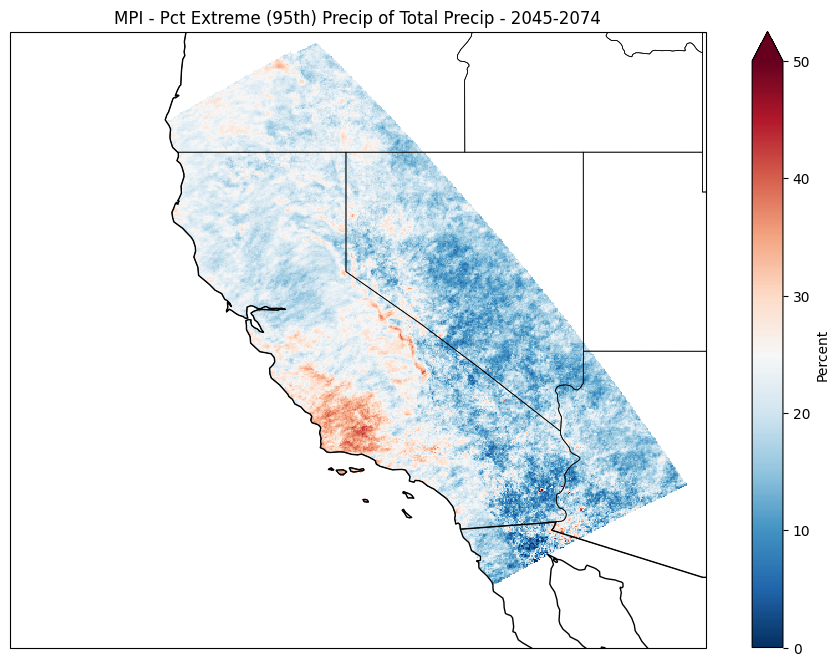

In [190]:
def map_99(netcdf_file, variable_name="total_extreme_precipitation_div_by_total_precipitation_scaled", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the 99th Percentile for PR (1950-2014) from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the pr values.
        variable_name (str): Name of the variable to plot. Defaults to "pr".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmax=50, cbar_kwargs={'label': 'Percent'})

        plt.title("MPI - Pct Extreme (95th) Precip of Total Precip - 2045-2074")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_FLOOD_PctExtreme95_01B-1_2045-2074_MPI.nc"  # Path to the NetCDF file with the tasmax difference

map_99(netcdf_file_path)

In [194]:
import xarray as xr
import glob # For finding files, or you can list them manually
import os

# --- Configuration ---

# 1. Specify the path to your NetCDF files
# Option A: Use a wildcard pattern if your files are in the same directory
file_pattern = "VCP_FLOOD_PctExtreme95_01A*.nc" # IMPORTANT: Change this to your actual path and pattern
netcdf_files = sorted(glob.glob(file_pattern))

# Option B: Manually list the file paths
# netcdf_files = [
#     "/path/to/your/files/file1.nc",
#     "/path/to/your/files/file2.nc",
#     "/path/to/your/files/file3.nc",
#     "/path/to/your/files/file4.nc",
#     "/path/to/your/files/file5.nc",
# ] # IMPORTANT: Change these to your actual file paths

# Check if files were found (if using glob)
if not netcdf_files:
    print(f"No files found matching pattern: {file_pattern}")
    print("Or, if manually listing, ensure the list is not empty.")
    # exit() # Or handle as appropriate

print(f"Found files: {netcdf_files}")

# 2. Specify the name of the variable you want to average
# This variable must exist in all your NetCDF files.
variable_name = "total_extreme_precipitation_div_by_total_precipitation_scaled"  # IMPORTANT: Change this (e.g., 'temperature', 'precipitation')

# 3. Specify the name of the dimension that the files will be concatenated along.
# If your files have a coordinate like 'time' and these times are different,
# xarray might automatically use that. If they are just 5 distinct files
# for the same grid without a distinguishing coordinate, open_mfdataset
# will create a new dimension, often 'concat_dim'.
# We will explicitly tell it to concatenate along a new dimension called 'file_dim'.
# This makes the averaging step clearer.
concatenation_dim = "file_index"

# 4. Specify the output file path
output_filename = "VCP_FLOOD_PctExtreme95_01A_GENUSE-AVE_2015-2044.nc" # IMPORTANT: Change this
output_directory = os.path.dirname(output_filename)
if not os.path.exists(output_directory) and output_directory:
    os.makedirs(output_directory)
    print(f"Created output directory: {output_directory}")

# --- Processing ---

try:
    # 1. Load multiple NetCDF files
    # open_mfdataset can automatically combine files along a new or existing dimension.
    # We provide the list of files and tell it to concatenate them along our specified dimension.
    # We also pass preprocess if we want to ensure a consistent structure or select variables.
    def preprocess_for_mfdataset(ds):
        # Example: Select only the variable of interest to save memory,
        # or ensure the concatenation dimension doesn't already exist with a conflicting meaning.
        if variable_name not in ds.variables:
            raise ValueError(f"Variable '{variable_name}' not found in one of the files.")
        return ds[[variable_name]] # Keep only the target variable

    # If your files already have a 'time' dimension and you want to average over time:
    # ds_combined = xr.open_mfdataset(netcdf_files, combine='by_coords', parallel=True)
    # And then you would average over 'time':
    # averaged_data = ds_combined[variable_name].mean(dim='time')

    # For averaging across files where each file is a separate entity for the same grid:
    # We'll load them and concatenate them along a new dimension.
    list_of_datasets = [xr.open_dataset(f) for f in netcdf_files]

    # Check if all datasets have the required variable
    for i, ds_single in enumerate(list_of_datasets):
        if variable_name not in ds_single.variables:
            raise ValueError(f"Variable '{variable_name}' not found in file: {netcdf_files[i]}")

    # Concatenate along the new dimension
    ds_combined = xr.concat(list_of_datasets, dim=concatenation_dim)
    print("\nCombined dataset structure:")
    print(ds_combined)

    # 2. Calculate the average for each xy (lat/lon) location
    # The mean is calculated along the dimension that represents the different files.
    # If using open_mfdataset without a common coordinate like 'time', it often
    # creates a 'concat_dim'. If we used concat explicitly, it's 'file_index'.
    if variable_name in ds_combined:
        averaged_data_array = ds_combined[variable_name].mean(dim=concatenation_dim)
        print(f"\nCalculated average along dimension: '{concatenation_dim}'")
        print("\nAveraged data array structure:")
        print(averaged_data_array)
    else:
        raise ValueError(f"Variable '{variable_name}' not found in the combined dataset. Available variables: {list(ds_combined.data_vars)}")


    # 3. Prepare the dataset for export
    # The result of .mean() is a DataArray. We'll put it into a Dataset.
    # It's good practice to give the averaged variable a descriptive name
    # and copy relevant attributes.
    output_ds = xr.Dataset({f"{variable_name}_mean": averaged_data_array})

    # You might want to copy global attributes from one of the original files
    if list_of_datasets:
        output_ds.attrs = list_of_datasets[0].attrs
        output_ds.attrs['history'] = (
            f"Averaged from {len(netcdf_files)} files. "
            f"Original files pattern: {file_pattern if 'file_pattern' in locals() else 'manual list'}. "
            f"Averaged variable: {variable_name}."
        )
    if hasattr(averaged_data_array, 'attrs'):
        output_ds[f"{variable_name}_mean"].attrs = averaged_data_array.attrs
        output_ds[f"{variable_name}_mean"].attrs['long_name'] = f"Average of {averaged_data_array.attrs.get('long_name', variable_name)}"
        output_ds[f"{variable_name}_mean"].attrs['units'] = averaged_data_array.attrs.get('units', 'unknown')


    # Ensure latitude and longitude coordinates are preserved correctly.
    # If 'lat' and 'lon' were dimensions in the original files, they should be in averaged_data_array.
    # Example: if your coordinate names are different, adjust here.
    # output_ds = output_ds.rename({'latitude': 'lat', 'longitude': 'lon'}) # If needed

    print("\nOutput dataset structure:")
    print(output_ds)

    # 4. Export the file as NetCDF
    output_ds.to_netcdf(output_filename)
    print(f"\nSuccessfully saved averaged data to: {output_filename}")

except FileNotFoundError:
    print(f"Error: One or more input files not found. Please check paths: {netcdf_files}")
except ValueError as ve:
    print(f"ValueError: {ve}")
except KeyError as ke:
    print(f"KeyError: Likely an issue with variable or dimension names. {ke}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Found files: ['VCP_FLOOD_PctExtreme95_01A-1_2015-2044_ACCESS.nc', 'VCP_FLOOD_PctExtreme95_01A-1_2045-2074_ACCESS.nc', 'VCP_FLOOD_PctExtreme95_01A-2_2015-2044_Earth3.nc', 'VCP_FLOOD_PctExtreme95_01A-3_2015-2044_FGOALS.nc', 'VCP_FLOOD_PctExtreme95_01A-4_2015-2044_MIROC.nc', 'VCP_FLOOD_PctExtreme95_01A-5_2015-2044_MPI.nc']

Combined dataset structure:
<xarray.Dataset> Size: 13MB
Dimensions:                                                        (
                                                                    file_index: 6,
                                                                    lat: 495,
                                                                    lon: 559)
Coordinates:
  * lat                                                            (lat) float32 2kB ...
  * lon                                                            (lon) float32 2kB ...
    quantile                                                       float64 8B ...
Dimensions without coordinates: file_ind

In [196]:
import xarray as xr
import glob # For finding files, or you can list them manually
import os

# --- Configuration ---

# 1. Specify the path to your NetCDF files
# Option A: Use a wildcard pattern if your files are in the same directory
file_pattern = "VCP_FLOOD_PctExtreme95_01B*.nc" # IMPORTANT: Change this to your actual path and pattern
netcdf_files = sorted(glob.glob(file_pattern))

# Option B: Manually list the file paths
# netcdf_files = [
#     "/path/to/your/files/file1.nc",
#     "/path/to/your/files/file2.nc",
#     "/path/to/your/files/file3.nc",
#     "/path/to/your/files/file4.nc",
#     "/path/to/your/files/file5.nc",
# ] # IMPORTANT: Change these to your actual file paths

# Check if files were found (if using glob)
if not netcdf_files:
    print(f"No files found matching pattern: {file_pattern}")
    print("Or, if manually listing, ensure the list is not empty.")
    # exit() # Or handle as appropriate

print(f"Found files: {netcdf_files}")

# 2. Specify the name of the variable you want to average
# This variable must exist in all your NetCDF files.
variable_name = "total_extreme_precipitation_div_by_total_precipitation_scaled"  # IMPORTANT: Change this (e.g., 'temperature', 'precipitation')

# 3. Specify the name of the dimension that the files will be concatenated along.
# If your files have a coordinate like 'time' and these times are different,
# xarray might automatically use that. If they are just 5 distinct files
# for the same grid without a distinguishing coordinate, open_mfdataset
# will create a new dimension, often 'concat_dim'.
# We will explicitly tell it to concatenate along a new dimension called 'file_dim'.
# This makes the averaging step clearer.
concatenation_dim = "file_index"

# 4. Specify the output file path
output_filename = "VCP_FLOOD_PctExtreme95_01B_GENUSE-AVE_2045-2074.nc" # IMPORTANT: Change this
output_directory = os.path.dirname(output_filename)
if not os.path.exists(output_directory) and output_directory:
    os.makedirs(output_directory)
    print(f"Created output directory: {output_directory}")

# --- Processing ---

try:
    # 1. Load multiple NetCDF files
    # open_mfdataset can automatically combine files along a new or existing dimension.
    # We provide the list of files and tell it to concatenate them along our specified dimension.
    # We also pass preprocess if we want to ensure a consistent structure or select variables.
    def preprocess_for_mfdataset(ds):
        # Example: Select only the variable of interest to save memory,
        # or ensure the concatenation dimension doesn't already exist with a conflicting meaning.
        if variable_name not in ds.variables:
            raise ValueError(f"Variable '{variable_name}' not found in one of the files.")
        return ds[[variable_name]] # Keep only the target variable

    # If your files already have a 'time' dimension and you want to average over time:
    # ds_combined = xr.open_mfdataset(netcdf_files, combine='by_coords', parallel=True)
    # And then you would average over 'time':
    # averaged_data = ds_combined[variable_name].mean(dim='time')

    # For averaging across files where each file is a separate entity for the same grid:
    # We'll load them and concatenate them along a new dimension.
    list_of_datasets = [xr.open_dataset(f) for f in netcdf_files]

    # Check if all datasets have the required variable
    for i, ds_single in enumerate(list_of_datasets):
        if variable_name not in ds_single.variables:
            raise ValueError(f"Variable '{variable_name}' not found in file: {netcdf_files[i]}")

    # Concatenate along the new dimension
    ds_combined = xr.concat(list_of_datasets, dim=concatenation_dim)
    print("\nCombined dataset structure:")
    print(ds_combined)

    # 2. Calculate the average for each xy (lat/lon) location
    # The mean is calculated along the dimension that represents the different files.
    # If using open_mfdataset without a common coordinate like 'time', it often
    # creates a 'concat_dim'. If we used concat explicitly, it's 'file_index'.
    if variable_name in ds_combined:
        averaged_data_array = ds_combined[variable_name].mean(dim=concatenation_dim)
        print(f"\nCalculated average along dimension: '{concatenation_dim}'")
        print("\nAveraged data array structure:")
        print(averaged_data_array)
    else:
        raise ValueError(f"Variable '{variable_name}' not found in the combined dataset. Available variables: {list(ds_combined.data_vars)}")


    # 3. Prepare the dataset for export
    # The result of .mean() is a DataArray. We'll put it into a Dataset.
    # It's good practice to give the averaged variable a descriptive name
    # and copy relevant attributes.
    output_ds = xr.Dataset({f"{variable_name}_mean": averaged_data_array})

    # You might want to copy global attributes from one of the original files
    if list_of_datasets:
        output_ds.attrs = list_of_datasets[0].attrs
        output_ds.attrs['history'] = (
            f"Averaged from {len(netcdf_files)} files. "
            f"Original files pattern: {file_pattern if 'file_pattern' in locals() else 'manual list'}. "
            f"Averaged variable: {variable_name}."
        )
    if hasattr(averaged_data_array, 'attrs'):
        output_ds[f"{variable_name}_mean"].attrs = averaged_data_array.attrs
        output_ds[f"{variable_name}_mean"].attrs['long_name'] = f"Average of {averaged_data_array.attrs.get('long_name', variable_name)}"
        output_ds[f"{variable_name}_mean"].attrs['units'] = averaged_data_array.attrs.get('units', 'unknown')


    # Ensure latitude and longitude coordinates are preserved correctly.
    # If 'lat' and 'lon' were dimensions in the original files, they should be in averaged_data_array.
    # Example: if your coordinate names are different, adjust here.
    # output_ds = output_ds.rename({'latitude': 'lat', 'longitude': 'lon'}) # If needed

    print("\nOutput dataset structure:")
    print(output_ds)

    # 4. Export the file as NetCDF
    output_ds.to_netcdf(output_filename)
    print(f"\nSuccessfully saved averaged data to: {output_filename}")

except FileNotFoundError:
    print(f"Error: One or more input files not found. Please check paths: {netcdf_files}")
except ValueError as ve:
    print(f"ValueError: {ve}")
except KeyError as ke:
    print(f"KeyError: Likely an issue with variable or dimension names. {ke}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Found files: ['VCP_FLOOD_PctExtreme95_01B-1_2045-2074_ACCESS.nc', 'VCP_FLOOD_PctExtreme95_01B-1_2045-2074_FGOALS.nc', 'VCP_FLOOD_PctExtreme95_01B-2_2045-2074_Earth3.nc', 'VCP_FLOOD_PctExtreme95_01B-4_2045-2074_MIROC.nc', 'VCP_FLOOD_PctExtreme95_01B-5_2045-2074_MPI.nc']

Combined dataset structure:
<xarray.Dataset> Size: 11MB
Dimensions:                                                        (
                                                                    file_index: 5,
                                                                    lat: 495,
                                                                    lon: 559)
Coordinates:
  * lat                                                            (lat) float32 2kB ...
  * lon                                                            (lon) float32 2kB ...
    quantile                                                       float64 8B ...
Dimensions without coordinates: file_index
Data variables:
    total_extreme_precipitation_d

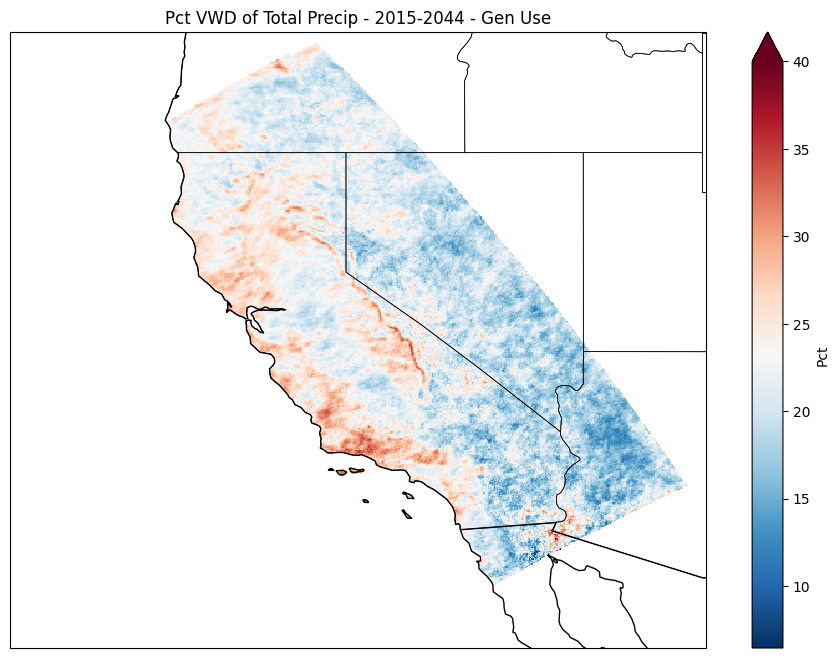

In [247]:
def map_99(netcdf_file, variable_name="total_extreme_precipitation_div_by_total_precipitation_scaled_mean", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the 99th Percentile for PR (1950-2014) from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the pr values.
        variable_name (str): Name of the variable to plot. Defaults to "pr".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmax=40, cbar_kwargs={'label': 'Pct'})

        plt.title("Pct VWD of Total Precip - 2015-2044 - Gen Use")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_FLOOD_PctExtreme95_01A_GENUSE-AVE_2015-2044.nc"  # Path to the NetCDF file with the tasmax difference

map_99(netcdf_file_path)

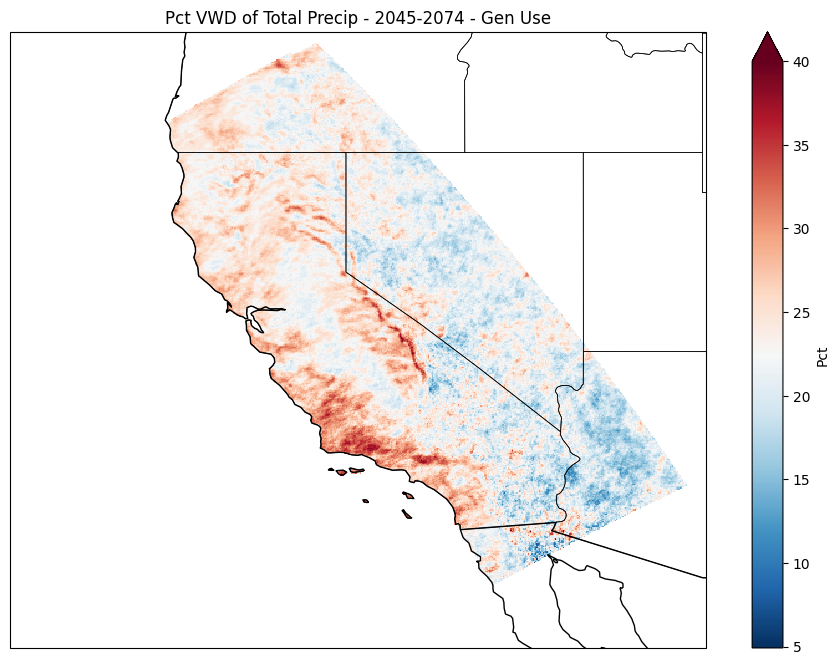

In [249]:
def map_99(netcdf_file, variable_name="total_extreme_precipitation_div_by_total_precipitation_scaled_mean", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the 99th Percentile for PR (1950-2014) from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the pr values.
        variable_name (str): Name of the variable to plot. Defaults to "pr".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmax=40, cbar_kwargs={'label': 'Pct'})

        plt.title("Pct VWD of Total Precip - 2045-2074 - Gen Use")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_FLOOD_PctExtreme95_01B_GENUSE-AVE_2045-2074.nc"  # Path to the NetCDF file with the tasmax difference

map_99(netcdf_file_path)

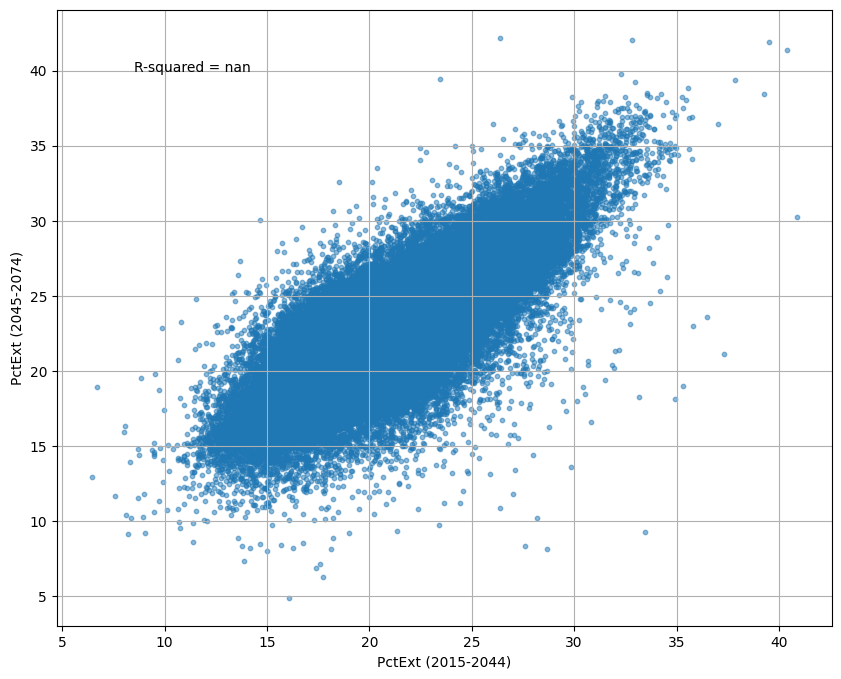

In [257]:
from scipy import stats

def scatter_tasmax_diff_vs_exceedance(diff_file, exceedance_file, output_plot="scatter_diff_exceedance.png"):
    """
    Creates a scatter plot between tasmax_diff.nc and 03B_tasmax3day_sandwiched_exceedance_counts_2045-2074.nc,
    including the R-squared value.

    Args:
        diff_file (str): Path to the tasmax_diff.nc file.
        exceedance_file (str): Path to the 03B_tasmax3day_sandwiched_exceedance_counts_2045-2074.nc file.
        output_plot (str): Path to save the scatter plot image.
    """
    try:
        diff_ds = xr.open_dataset(diff_file)
        exceedance_ds = xr.open_dataset(exceedance_file)

        diff_data = diff_ds["total_extreme_precipitation_div_by_total_precipitation_scaled_mean"]  # Or whatever your variable name is
        exceedance_data = exceedance_ds["total_extreme_precipitation_div_by_total_precipitation_scaled_mean"]  # Or your variable name

        # Ensure dimensions are compatible by flattening
        diff_values = diff_data.values.flatten()
        exceedance_values = exceedance_data.values.flatten()

        # Calculate R-squared
        slope, intercept, r_value, p_value, std_err = stats.linregress(diff_values, exceedance_values)
        r_squared = r_value**2

        plt.figure(figsize=(10, 8))
        plt.scatter(diff_values, exceedance_values, s=10, alpha=0.5)

        plt.xlabel("PctExt (2015-2044)")
        plt.ylabel("PctExt (2045-2074)")
        #plt.title("Scatter Plot: tasmax Difference vs. Exceedance Counts")
        plt.grid(True)

        # Add R-squared to the plot
        plt.text(0.1, 0.9, f"R-squared = {r_squared:.2f}", transform=plt.gca().transAxes)

        plt.savefig(output_plot)
        plt.show()

    except FileNotFoundError:
        print("Error: One or both files not found.")
    except KeyError:
        print("Error: Required variables not found in one or both files.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'diff_ds' in locals():
            diff_ds.close()
        if 'exceedance_ds' in locals():
            exceedance_ds.close()

# Example usage:
diff_file_path = "VCP_FLOOD_PctExtreme95_01A_GENUSE-AVE_2015-2044.nc"  # Replace with your tasmax_diff.nc file path
exceedance_file_path = "VCP_FLOOD_PctExtreme95_01B_GENUSE-AVE_2045-2074.nc"  # Replace with your exceedance file path

scatter_tasmax_diff_vs_exceedance(diff_file_path, exceedance_file_path)


--- Running Example 2: xarray ---

xarray Dataset structure:
<xarray.Dataset> Size: 2MB
Dimensions:                                                             (
                                                                         lat: 495,
                                                                         lon: 559)
Coordinates:
  * lat                                                                 (lat) float32 2kB ...
  * lon                                                                 (lon) float32 2kB ...
    quantile                                                            float64 8B ...
Data variables:
    total_extreme_precipitation_div_by_total_precipitation_scaled_mean  (lat, lon) float64 2MB ...
Attributes:
    history:  Averaged from 6 files. Original files pattern: VCP_FLOOD_PctExt...


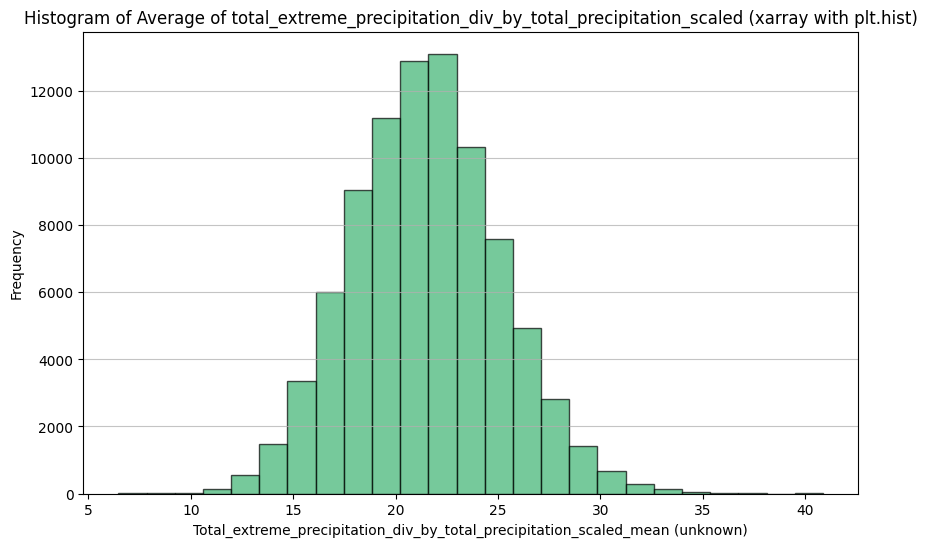

In [261]:
try:
    import xarray as xr
    XARRAY_AVAILABLE = True
except ImportError:
    XARRAY_AVAILABLE = False
    print("xarray library not found. Please install it (e.g., pip install xarray).")
    print("Skipping xarray example.")
# --- Example 2: Using xarray and Matplotlib (or xarray's plotting) ---
if XARRAY_AVAILABLE:
    print("\n--- Running Example 2: xarray ---")
    netcdf_filepath = 'VCP_FLOOD_PctExtreme95_01A_GENUSE-AVE_2015-2044.nc'
    variable_to_plot_xr = 'total_extreme_precipitation_div_by_total_precipitation_scaled_mean' # Change this to your variable name

    try:
        # 1. Load the NetCDF file using xarray
        # xarray automatically handles closing the file when 'ds' goes out of scope
        # or you can use a 'with' statement like with netCDF4.
        ds = xr.open_dataset(netcdf_filepath)

        # 2. Inspect the dataset (optional)
        print("\nxarray Dataset structure:")
        print(ds)

        # 3. Select the data variable
        if variable_to_plot_xr in ds:
            data_array = ds[variable_to_plot_xr] 
            # Alternative: Using matplotlib directly with xarray data
            # This gives more control if needed, similar to the netCDF4 example
            plt.figure(figsize=(10, 6))
            # .values flattens and converts to a NumPy array
            plt.hist(data_array.values.flatten(), bins=25, color='mediumseagreen', edgecolor='black', alpha=0.7)
            plt.title(f'Histogram of {data_array.attrs.get("long_name", variable_to_plot_xr)} (xarray with plt.hist)')
            plt.xlabel(f'{variable_to_plot_xr.capitalize()} ({data_array.attrs.get("units", "")})')
            plt.ylabel('Frequency')
            plt.grid(axis='y', alpha=0.75)
            plt.show()

        else:
            print(f"Variable '{variable_to_plot_xr}' not found in the xarray Dataset.")
        
        # Close the dataset explicitly if not using a 'with' statement
        # (though for simple scripts, Python's garbage collection often handles it)
        ds.close()

    except FileNotFoundError:
        print(f"Error: NetCDF file not found at '{netcdf_filepath}'")
    except Exception as e:
        print(f"An error occurred with xarray: {e}")
else:
    if not XARRAY_AVAILABLE:
        print("Skipping xarray example as the library is not installed.")
    elif not dummy_nc_file:
        print("Skipping xarray example as dummy file could not be created.")



--- Running Example 2: xarray ---

xarray Dataset structure:
<xarray.Dataset> Size: 2MB
Dimensions:                                                             (
                                                                         lat: 495,
                                                                         lon: 559)
Coordinates:
  * lat                                                                 (lat) float32 2kB ...
  * lon                                                                 (lon) float32 2kB ...
    quantile                                                            float64 8B ...
Data variables:
    total_extreme_precipitation_div_by_total_precipitation_scaled_mean  (lat, lon) float64 2MB ...
Attributes:
    history:  Averaged from 5 files. Original files pattern: VCP_FLOOD_PctExt...


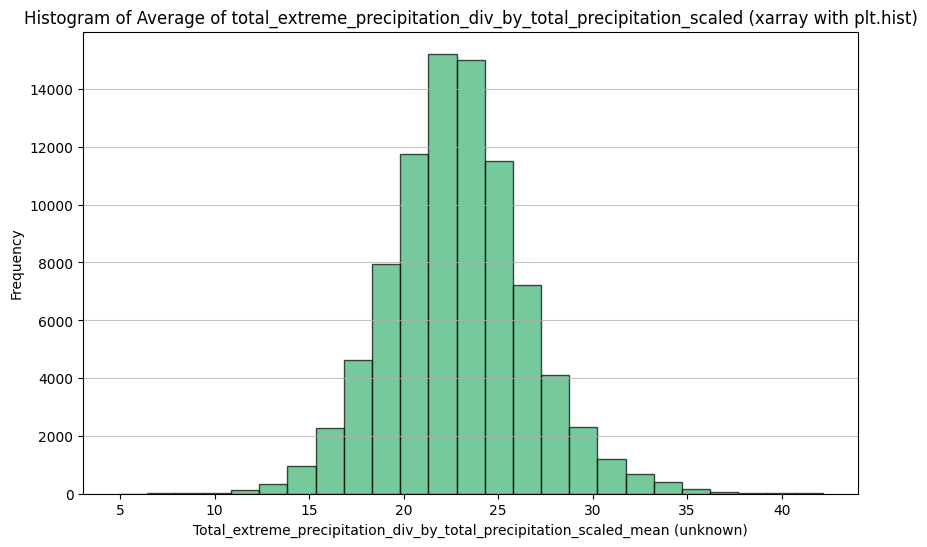

In [263]:
try:
    import xarray as xr
    XARRAY_AVAILABLE = True
except ImportError:
    XARRAY_AVAILABLE = False
    print("xarray library not found. Please install it (e.g., pip install xarray).")
    print("Skipping xarray example.")
# --- Example 2: Using xarray and Matplotlib (or xarray's plotting) ---
if XARRAY_AVAILABLE:
    print("\n--- Running Example 2: xarray ---")
    netcdf_filepath = 'VCP_FLOOD_PctExtreme95_01B_GENUSE-AVE_2045-2074.nc'
    variable_to_plot_xr = 'total_extreme_precipitation_div_by_total_precipitation_scaled_mean' # Change this to your variable name

    try:
        # 1. Load the NetCDF file using xarray
        # xarray automatically handles closing the file when 'ds' goes out of scope
        # or you can use a 'with' statement like with netCDF4.
        ds = xr.open_dataset(netcdf_filepath)

        # 2. Inspect the dataset (optional)
        print("\nxarray Dataset structure:")
        print(ds)

        # 3. Select the data variable
        if variable_to_plot_xr in ds:
            data_array = ds[variable_to_plot_xr] 
            # Alternative: Using matplotlib directly with xarray data
            # This gives more control if needed, similar to the netCDF4 example
            plt.figure(figsize=(10, 6))
            # .values flattens and converts to a NumPy array
            plt.hist(data_array.values.flatten(), bins=25, color='mediumseagreen', edgecolor='black', alpha=0.7)
            plt.title(f'Histogram of {data_array.attrs.get("long_name", variable_to_plot_xr)} (xarray with plt.hist)')
            plt.xlabel(f'{variable_to_plot_xr.capitalize()} ({data_array.attrs.get("units", "")})')
            plt.ylabel('Frequency')
            plt.grid(axis='y', alpha=0.75)
            plt.show()

        else:
            print(f"Variable '{variable_to_plot_xr}' not found in the xarray Dataset.")
        
        # Close the dataset explicitly if not using a 'with' statement
        # (though for simple scripts, Python's garbage collection often handles it)
        ds.close()

    except FileNotFoundError:
        print(f"Error: NetCDF file not found at '{netcdf_filepath}'")
    except Exception as e:
        print(f"An error occurred with xarray: {e}")
else:
    if not XARRAY_AVAILABLE:
        print("Skipping xarray example as the library is not installed.")
    elif not dummy_nc_file:
        print("Skipping xarray example as dummy file could not be created.")



Loaded VCP_FLOOD_PctExtreme95_01A_GENUSE-AVE_2015-2044.nc:
<xarray.Dataset> Size: 2MB
Dimensions:                                                             (
                                                                         lat: 495,
                                                                         lon: 559)
Coordinates:
  * lat                                                                 (lat) float32 2kB ...
  * lon                                                                 (lon) float32 2kB ...
    quantile                                                            float64 8B ...
Data variables:
    total_extreme_precipitation_div_by_total_precipitation_scaled_mean  (lat, lon) float64 2MB ...
Attributes:
    history:  Averaged from 6 files. Original files pattern: VCP_FLOOD_PctExt...

Loaded VCP_FLOOD_PctExtreme95_01B_GENUSE-AVE_2045-2074.nc:
<xarray.Dataset> Size: 2MB
Dimensions:                                                             (
                

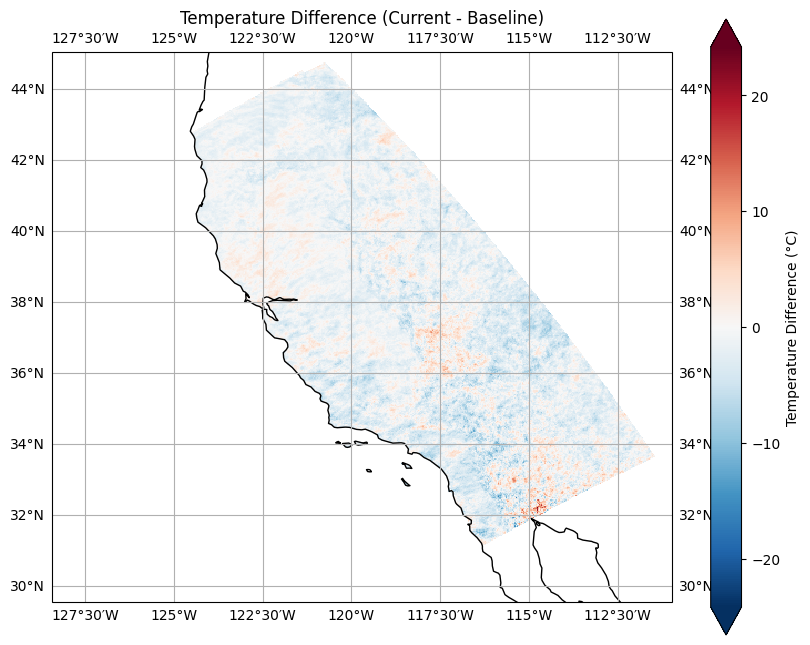

In [265]:
# Define file paths
file1_path = 'VCP_FLOOD_PctExtreme95_01A_GENUSE-AVE_2015-2044.nc'
file2_path = 'VCP_FLOOD_PctExtreme95_01B_GENUSE-AVE_2045-2074.nc'
output_diff_path = 'temp_temperature_difference.nc' # Optional: to save the difference

# --- 2. Load the NetCDF files ---
try:
    ds1 = xr.open_dataset(file1_path)
    ds2 = xr.open_dataset(file2_path)
    print(f"\nLoaded {file1_path}:\n{ds1}")
    print(f"\nLoaded {file2_path}:\n{ds2}")

except FileNotFoundError:
    print(f"Error: Make sure '{file1_path}' and '{file2_path}' exist.")
    print("If you just ran the dummy file creation, this shouldn't happen.")
    exit()
except Exception as e:
    print(f"An error occurred while loading files: {e}")
    exit()

# --- 3. Perform the subtraction ---
# Assuming the variable name is 'temperature' in both files
# And that their dimensions (lat, lon) align. Xarray handles this smartly.
try:
    # Subtracting the datasets directly if they have the same structure and variable names
    # Or, subtract specific DataArrays: ds1['temperature'] - ds2['temperature']
    temperature_difference = ds1['total_extreme_precipitation_div_by_total_precipitation_scaled_mean'] - ds2['total_extreme_precipitation_div_by_total_precipitation_scaled_mean']
    print(f"\nCalculated temperature difference:\n{temperature_difference}")

    # Optional: Save the difference to a new NetCDF file
    temperature_difference.to_netcdf(output_diff_path)
    print(f"\nSaved difference to {output_diff_path}")

except KeyError:
    print("Error: 'temperature' variable not found in one or both NetCDF files.")
    print(f"Variables in {file1_path}: {list(ds1.data_vars)}")
    print(f"Variables in {file2_path}: {list(ds2.data_vars)}")
    exit()
except Exception as e:
    print(f"An error occurred during subtraction: {e}")
    exit()

# --- 4. Map the output ---

# Set up the plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()) # Using Plate Carree for simple lat/lon

# Plot the data
# Use .plot() method from xarray DataArray for quick plotting.
# vmax and vmin can be set for consistent color scaling, especially if differences can be negative.
# cmap can be chosen to represent divergence (e.g., 'RdBu_r' for cool/warm differences).
plot = temperature_difference.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r', # Red-Blue reversed colormap, good for differences
    cbar_kwargs={'label': 'Temperature Difference (°C)'},
    extend='both' # Extends colorbar to show values outside the range if any
)

# Add map features
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.set_title('Temperature Difference (Current - Baseline)')

plt.show()

In [ ]:
#TEST RUN on hist data

In [279]:
import xarray as xr
# Optional: For setting up a Dask client for better monitoring and control
# from dask.distributed import Client

def calculate_extreme_precipitation_sum_dask(
    pr_file_path,
    percentile_file_path,
    pr_variable_name='pr',
    percentile_variable_name='pr95', # Changed default to pr95 as per typical naming
    pr_chunks={'time': 'auto'},      # Dask chunks for precipitation data
    percentile_chunks={}             # Dask chunks for percentile data (often smaller, {} or 'auto' is fine)
    ):
    """
    Calculates the total precipitation from days where daily precipitation
    exceeds the 95th percentile at each lat/lon location, using Dask for out-of-core computation.

    Args:
        pr_file_path (str): Path to the NetCDF file containing daily precipitation data.
        percentile_file_path (str): Path to the NetCDF file containing the 95th percentile
                                     precipitation data.
        pr_variable_name (str, optional): Name of the precipitation variable in pr_file_path.
                                          Defaults to 'pr'.
        percentile_variable_name (str, optional): Name of the 95th percentile variable
                                                in percentile_file_path. Defaults to 'pr95'.
        pr_chunks (dict, optional): Chunking dictionary for the precipitation data.
                                   Defaults to {'time': 'auto'}.
        percentile_chunks (dict, optional): Chunking dictionary for the percentile data.
                                           Defaults to {}.

    Returns:
        xarray.DataArray: A Dask-backed DataArray containing the sum of extreme precipitation
                          at each lat/lon. Computation is triggered when writing to disk or
                          explicitly calling .compute() or .load().
                          Returns None if an error occurs.
    """
    try:
        # Open the precipitation and percentile datasets with Dask chunks
        # This makes xarray use Dask arrays, enabling out-of-core computation
        ds_pr = xr.open_dataset(pr_file_path, chunks=pr_chunks)
        ds_percentile = xr.open_dataset(percentile_file_path, chunks=percentile_chunks)

        # Extract the precipitation data and the 95th percentile data
        # Operations will now build a Dask graph
        daily_pr = ds_pr[pr_variable_name] * 86400 # This multiplication is also lazy
        percentile_95 = ds_percentile[percentile_variable_name]

        # Ensure that the percentile data can be broadcasted to the daily data.
        # If percentile_95 is small, you could .load() it into memory here
        # to potentially speed up the comparison, but it's often fine as a Dask array.
        # e.g., if ds_percentile.nbytes < some_threshold: percentile_95 = percentile_95.load()

        if 'time' in percentile_95.dims and percentile_95.sizes['time'] == 1:
            percentile_95 = percentile_95.squeeze('time', drop=True)
        elif 'time' in percentile_95.dims and percentile_95.sizes['time'] > 1:
            print("Warning: Percentile data appears to have a time dimension > 1. "
                  "This usually means it's a daily varying percentile. "
                  "Ensure this is the intended behavior. "
                  "If it's a single percentile map, it should not have a time dimension or be of size 1.")

        # Identify days where daily precipitation is above the 95th percentile
        extreme_days_mask = daily_pr > percentile_95 # Lazy operation

        # Use the mask to select only the precipitation values on extreme days
        extreme_pr = daily_pr.where(extreme_days_mask) # Lazy operation

        # Sum the precipitation from these extreme days along the 'time' dimension
        # skipna=True is important. This is still a lazy Dask operation.
        total_extreme_pr = extreme_pr.sum(dim='time', skipna=True)

        # It's good practice to give the output DataArray a name
        total_extreme_pr.name = "total_extreme_precipitation"
        total_extreme_pr.attrs['long_name'] = 'Total precipitation from days > 95th percentile (Dask)'
        if 'units' in daily_pr.attrs:
            # Assuming units of daily_pr after multiplication are mm/day equivalent
             total_extreme_pr.attrs['units'] = daily_pr.attrs.get('units_after_scaling', 'mm') # or appropriate unit
        else:
            total_extreme_pr.attrs['units'] = 'mm' # Placeholder


        # Datasets can be closed. Dask operations on arrays will still work if the data
        # needed for computation has been described in the task graph.
        # However, ensure computations that need to read metadata or re-read data chunks
        # are defined before closing if not using .persist() or .compute() earlier.
        # For simple sequential operations like this, closing here is usually fine.
        ds_pr.close()
        ds_percentile.close()

        return total_extreme_pr

    except FileNotFoundError:
        print(f"Error: One or both NetCDF files not found.")
        print(f"Precipitation file: {pr_file_path}")
        print(f"Percentile file: {percentile_file_path}")
        return None
    except KeyError as e:
        print(f"Error: Variable not found in NetCDF file. Details: {e}")
        print("Please ensure 'pr_variable_name' and 'percentile_variable_name' are correct.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # Optional: Initialize a Dask client to monitor computations
    # client = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB') # Customize as needed
    # print(f"Dask dashboard link: {client.dashboard_link}")

    # --- Configuration ---
    precipitation_filepath = 'pr.ACCESS-CM2.historical.r1i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc'
    percentile_filepath = 'VCP_FLOOD_PR_95pct_1950-2014_VWD_ACCESS.nc'

    precip_var_name = 'pr'
    # The user's original main block explicitly uses 'pr' for the percentile variable name.
    # The function default is 'pr95', but this will override it.
    percentile_var_name = 'pr'

    # Dask chunking configuration (tune based on your data and memory)
    # 'auto' often works well. For time series, chunking time is common.
    # If lat/lon are very large, you might chunk them too e.g., {'time': 100, 'lat': 10, 'lon': 10}
    precip_chunks_config = {'time': 'auto'} # Let Dask/xarray decide chunking for time dimension
    percentile_chunks_config = {} # For smaller percentile files, default chunking or no chunking is often fine.
                                   # Or use 'auto' if it also could be large.

    # --- Calculation ---
    print("Starting calculation with Dask...")
    extreme_precipitation_sum = calculate_extreme_precipitation_sum_dask(
        precipitation_filepath,
        percentile_filepath,
        pr_variable_name=precip_var_name,
        percentile_variable_name=percentile_var_name,
        pr_chunks=precip_chunks_config,
        percentile_chunks=percentile_chunks_config
    )

    # --- Output ---
    if extreme_precipitation_sum is not None:
        print("\nSuccessfully defined Dask computation for the sum of precipitation on extreme days.")
        print("The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().")
        print(extreme_precipitation_sum) # This will show the Dask array structure, not values

        # --- Save the result to a new NetCDF file ---
        # This is where Dask will perform the actual computation and write to disk.
        output_filepath = 'VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_1950-2014_ACCESS.nc'
        print(f"\nAttempting to save results to: {output_filepath}")
        try:
            # When saving, Dask computes the result and writes it.
            # For very large outputs, ensure you have disk space.
            # You can also specify encoding for compression, etc.
            extreme_precipitation_sum.to_netcdf(output_filepath)
            print(f"Results successfully saved to: {output_filepath}")
        except Exception as e:
            print(f"\nError saving results to NetCDF: {e}")
            print("This error might have occurred during Dask computation or file writing.")

    # Optional: Close the Dask client if you initialized one
    # if 'client' in locals():
    # client.close()

Starting calculation with Dask...

Successfully defined Dask computation for the sum of precipitation on extreme days.
The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().
<xarray.DataArray 'total_extreme_precipitation' (lat: 495, lon: 559)> Size: 2MB
dask.array<sum-aggregate, shape=(495, 559), dtype=float64, chunksize=(495, 559), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B ...
Attributes:
    long_name:  Total precipitation from days > 95th percentile (Dask)
    units:      mm

Attempting to save results to: VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_1950-2014_ACCESS.nc
Results successfully saved to: VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_1950-2014_ACCESS.nc


In [280]:
def calculate_total_precipitation_dask(
    pr_file_path,
    pr_variable_name='pr',
    pr_chunks={'time': 'auto'}
    ):
    """
    Calculates the total precipitation at each lat/lon location,
    using Dask for out-of-core computation.

    Args:
        pr_file_path (str): Path to the NetCDF file containing daily precipitation data.
        pr_variable_name (str, optional): Name of the precipitation variable in pr_file_path.
                                          Defaults to 'pr'.
        pr_chunks (dict, optional): Chunking dictionary for the precipitation data.
                                    Defaults to {'time': 'auto'}.

    Returns:
        xarray.DataArray: A Dask-backed DataArray containing the sum of precipitation
                          at each lat/lon. Computation is triggered when writing to disk or
                          explicitly calling .compute() or .load().
                          Returns None if an error occurs.
    """
    try:
        # Open the precipitation dataset with Dask chunks
        ds_pr = xr.open_dataset(pr_file_path, chunks=pr_chunks)

        # Extract the precipitation data
        # Operations will now build a Dask graph
        daily_pr = ds_pr[pr_variable_name]

        # Optional: If your precipitation data is not already in mm/day
        # and needs conversion (e.g., from kg m-2 s-1), apply it here.
        # For example, if original units are kg m-2 s-1 (flux)
        # daily_pr_mm_day = daily_pr * 86400 # Convert to mm/day
        # If it's already in mm/day or a similar daily total, no conversion needed.
        # For this example, we'll assume daily_pr is already in appropriate daily units (e.g., mm)
        # or if it was flux, the user would handle the conversion as needed.
        # The original code had `* 86400`, so we'll keep that behavior for now
        # if the user expects it. If the input 'pr' is already daily totals,
        # this multiplication would be incorrect.
        # Let's assume the multiplication is to convert from flux to total daily amount.
        daily_pr_converted = daily_pr * 86400 # This multiplication is also lazy
        daily_pr_converted.attrs['units_after_scaling'] = 'mm' # Example unit after scaling

        # Sum the precipitation along the 'time' dimension
        # skipna=True is important. This is still a lazy Dask operation.
        total_pr = daily_pr_converted.sum(dim='time', skipna=True)

        # It's good practice to give the output DataArray a name and attributes
        total_pr.name = "total_precipitation"
        total_pr.attrs['long_name'] = 'Total precipitation (Dask)'
        if 'units_after_scaling' in daily_pr_converted.attrs:
             total_pr.attrs['units'] = daily_pr_converted.attrs['units_after_scaling']
        elif 'units' in daily_pr.attrs:
            total_pr.attrs['units'] = daily_pr.attrs['units'] # Or sum of daily units
        else:
            total_pr.attrs['units'] = 'mm' # Placeholder

        ds_pr.close()

        return total_pr

    except FileNotFoundError:
        print(f"Error: Precipitation NetCDF file not found.")
        print(f"Precipitation file: {pr_file_path}")
        return None
    except KeyError as e:
        print(f"Error: Variable '{pr_variable_name}' not found in NetCDF file. Details: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # Optional: Initialize a Dask client to monitor computations
    # client = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB') # Customize as needed
    # print(f"Dask dashboard link: {client.dashboard_link}")

    # --- Configuration ---
    precipitation_filepath = 'pr.ACCESS-CM2.historical.r1i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc'
    precip_var_name = 'pr'

    # Dask chunking configuration
    precip_chunks_config = {'time': 'auto'}

    # --- Calculation ---
    print("Starting calculation of total precipitation with Dask...")
    total_precipitation_sum = calculate_total_precipitation_dask(
        precipitation_filepath,
        pr_variable_name=precip_var_name,
        pr_chunks=precip_chunks_config
    )

    # --- Output ---
    if total_precipitation_sum is not None:
        print("\nSuccessfully defined Dask computation for the total precipitation.")
        print("The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().")
        print(total_precipitation_sum)

        # --- Save the result to a new NetCDF file ---
        output_filepath = 'VCP_FLOOD_PR_95pct_VWDTotalPrecip_1950-2014_ACCESS.nc' # Changed output filename
        print(f"\nAttempting to save results to: {output_filepath}")
        try:
            total_precipitation_sum.to_netcdf(output_filepath)
            print(f"Results successfully saved to: {output_filepath}")
        except Exception as e:
            print(f"\nError saving results to NetCDF: {e}")
            print("This error might have occurred during Dask computation or file writing.")

    # Optional: Close the Dask client if you initialized one
    # if 'client' in locals() and client: # Check if client exists and is not None
    #     client.close()

Starting calculation of total precipitation with Dask...

Successfully defined Dask computation for the total precipitation.
The result is a Dask array. Actual computation will occur upon saving or explicit .compute()/.load().
<xarray.DataArray 'total_precipitation' (lat: 495, lon: 559)> Size: 2MB
dask.array<sum-aggregate, shape=(495, 559), dtype=float64, chunksize=(495, 559), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon      (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
Attributes:
    long_name:  Total precipitation (Dask)
    units:      mm

Attempting to save results to: VCP_FLOOD_PR_95pct_VWDTotalPrecip_1950-2014_ACCESS.nc
Results successfully saved to: VCP_FLOOD_PR_95pct_VWDTotalPrecip_1950-2014_ACCESS.nc


In [282]:
def multiply_and_divide_netcdfs(ext_filepath, tot_filepath, output_filepath,
                                ext_var_name='pr', tot_var_name='pr'):
    """
    Opens ext.nc, multiplies its data variable by 100,
    opens tot.nc, and divides the result by tot.nc's data variable.
    Saves the final result to output_filepath.

    Args:
        ext_filepath (str): Path to the 'ext.nc' NetCDF file.
        tot_filepath (str): Path to the 'tot.nc' NetCDF file.
        output_filepath (str): Path to save the resulting NetCDF file.
        ext_var_name (str, optional): Name of the variable in ext.nc.
                                      If None, uses the first data variable.
        tot_var_name (str, optional): Name of the variable in tot.nc.
                                      If None, uses the first data variable.

    Returns:
        xarray.DataArray: The resulting DataArray, or None if an error occurs.
    """
    try:
        # Open the datasets
        ds_ext = xr.open_dataset(ext_filepath)
        ds_tot = xr.open_dataset(tot_filepath)

        # Determine variable names if not provided
        if ext_var_name is None:
            ext_var_name = get_first_data_variable_name(ds_ext)
            print(f"Using inferred variable '{ext_var_name}' from '{ext_filepath}'")
        if tot_var_name is None:
            tot_var_name = get_first_data_variable_name(ds_tot)
            print(f"Using inferred variable '{tot_var_name}' from '{tot_filepath}'")

        # Extract the DataArrays
        ext_data = ds_ext[ext_var_name]
        tot_data = ds_tot[tot_var_name]

        # Perform the calculation: (ext_data * 100) / tot_data
        print(f"\nPerforming operation: ({ext_var_name} * 100) / {tot_var_name}")
        
        scaled_ext_data = ext_data * 100
        result_data = scaled_ext_data / tot_data

        # Handle potential division by zero explicitly if you want something other than inf/NaN
        # For example, to set results to NaN where tot_data is zero:
        # result_data = xr.where(tot_data == 0, np.nan, scaled_ext_data / tot_data)
        # Xarray by default will produce `inf` or `NaN` which is often acceptable.

        # Assign a name and attributes to the result for clarity in the output file
        result_data.name = f"{ext_var_name}_div_by_{tot_var_name}_scaled"
        result_data.attrs['long_name'] = (f"({ext_var_name} * 100) / {tot_var_name}")
        result_data.attrs['units'] = f"({ext_data.attrs.get('units', 'unknown')} * 100) / {tot_data.attrs.get('units', 'unknown')}"
        result_data.attrs['operation_description'] = (
            f"Data from variable '{ext_var_name}' in '{ext_filepath}' was multiplied by 100, "
            f"then divided by data from variable '{tot_var_name}' in '{tot_filepath}'."
        )


        # Save the result to a new NetCDF file
        result_data.to_netcdf(output_filepath)
        print(f"\nResult successfully saved to: {output_filepath}")

        # Close the datasets
        ds_ext.close()
        ds_tot.close()

        return result_data

    except FileNotFoundError as e:
        print(f"Error: File not found. Details: {e}")
        return None
    except KeyError as e:
        print(f"Error: Variable not found in NetCDF file. Details: {e}")
        print("Please ensure 'ext_var_name' and 'tot_var_name' are correct if you specified them.")
        return None
    except ValueError as e: # For issues like no data variables
        print(f"Error: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

if __name__ == '__main__':
    # --- Configuration ---
    # Replace with the actual paths to your files
    ext_netcdf_file = 'VCP_FLOOD_PR_95pct_VWDTotalExtremePrecip_1950-2014_ACCESS.nc'
    tot_netcdf_file = 'VCP_FLOOD_PR_95pct_VWDTotalPrecip_1950-2014_ACCESS.nc'
    output_netcdf_file = 'VCP_FLOOD_PctExtreme95_01A-1_1950-2014_ACCESS.nc'

    # Optional: Specify variable names if you know them and want to be explicit,
    # or if the files have multiple data variables and you don't want the first one.
    # If set to None, the script will try to use the first data variable found.
    ext_variable = 'total_extreme_precipitation'  # e.g., 'precipitation_flux' or 'extreme_sum'
    tot_variable = 'total_precipitation'  # e.g., 'total_precipitation'

    # --- Perform Calculation ---
    calculated_result = multiply_and_divide_netcdfs(
        ext_netcdf_file,
        tot_netcdf_file,
        output_netcdf_file,
        ext_var_name=ext_variable,
        tot_var_name=tot_variable
    )

    if calculated_result is not None:
        print("\n--- Result DataArray ---")
        print(calculated_result)
        # You can further analyze or plot 'calculated_result' here if needed
        # For example:
        # import matplotlib.pyplot as plt
        # if 'lat' in calculated_result.dims and 'lon' in calculated_result.dims:
        #     if len(calculated_result.dims) == 2: # Simple 2D plot
        #         calculated_result.plot()
        #         plt.show()
        #     elif 'time' in calculated_result.dims and calculated_result.sizes['time'] > 0: # Plot first time step of 3D data
        #         calculated_result.isel(time=0).plot()
        #         plt.show()


Performing operation: (total_extreme_precipitation * 100) / total_precipitation

Result successfully saved to: VCP_FLOOD_PctExtreme95_01A-1_1950-2014_ACCESS.nc

--- Result DataArray ---
<xarray.DataArray 'total_extreme_precipitation_div_by_total_precipitation_scaled' (
                                                                                   lat: 495,
                                                                                   lon: 559)> Size: 2MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B ...
Attributes:
    long_name:              (total_extreme_pr

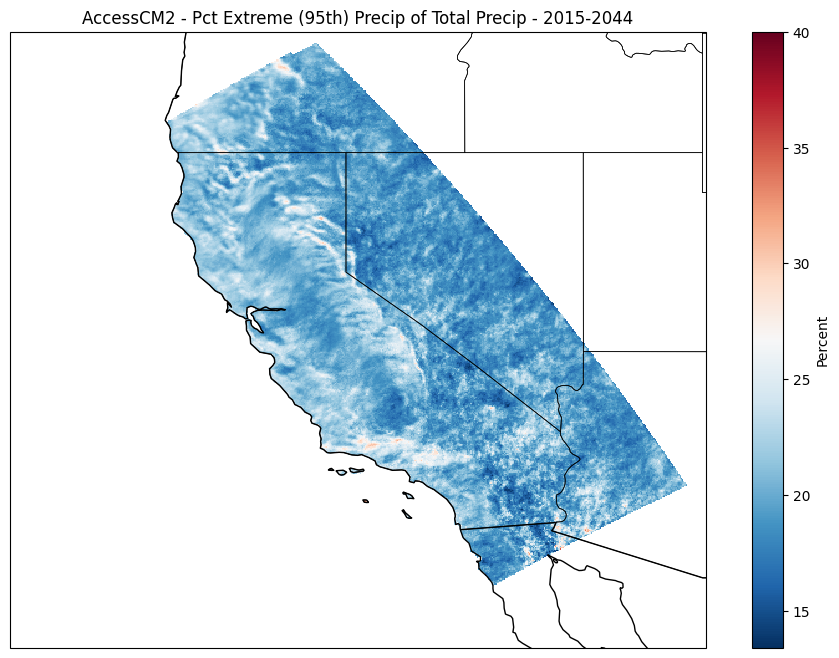

In [321]:
def map_99(netcdf_file, variable_name="total_extreme_precipitation_div_by_total_precipitation_scaled", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the 99th Percentile for PR (1950-2014) from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the pr values.
        variable_name (str): Name of the variable to plot. Defaults to "pr".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmax=40, cbar_kwargs={'label': 'Percent'})

        plt.title("AccessCM2 - Pct Extreme (95th) Precip of Total Precip - 2015-2044")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_FLOOD_PctExtreme95_01A-1_1950-2014_ACCESS.nc"  # Path to the NetCDF file with the tasmax difference

map_99(netcdf_file_path)


Loaded VCP_FLOOD_PctExtreme95_01A-1_1950-2014_ACCESS.nc:
<xarray.Dataset> Size: 2MB
Dimensions:                                                        (lat: 495,
                                                                    lon: 559)
Coordinates:
  * lat                                                            (lat) float32 2kB ...
  * lon                                                            (lon) float32 2kB ...
    quantile                                                       float64 8B ...
Data variables:
    total_extreme_precipitation_div_by_total_precipitation_scaled  (lat, lon) float64 2MB ...

Loaded VCP_FLOOD_PctExtreme95_01A-1_2015-2044_ACCESS.nc:
<xarray.Dataset> Size: 2MB
Dimensions:                                                        (lat: 495,
                                                                    lon: 559)
Coordinates:
  * lat                                                            (lat) float32 2kB ...
  * lon                          

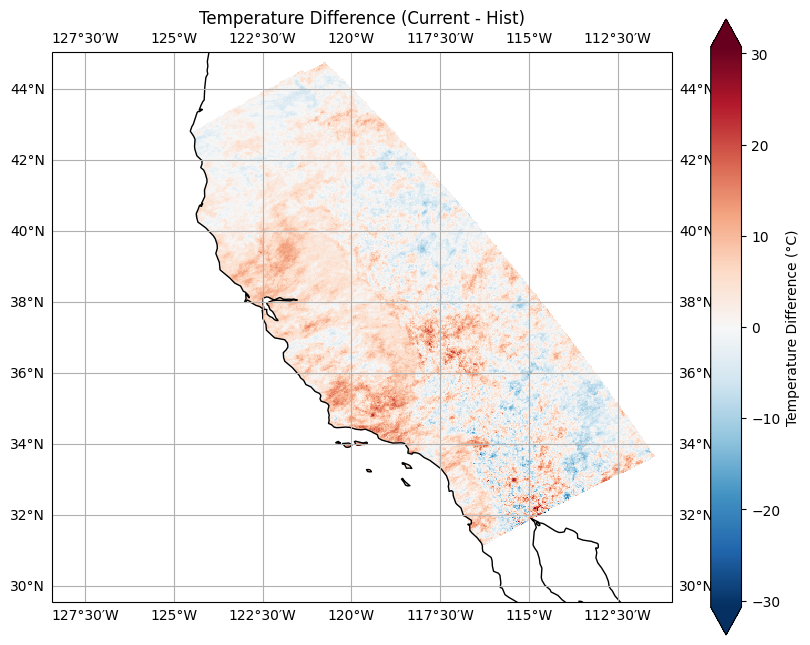

In [342]:
# Define file paths
file1_path = 'VCP_FLOOD_PctExtreme95_01A-1_1950-2014_ACCESS.nc'
file2_path = 'VCP_FLOOD_PctExtreme95_01A-1_2015-2044_ACCESS.nc'
output_diff_path = 'VCP_FLOOD_Diff-PctExtreme95_01A-1_2015-2044_ACCESS.nc' # Optional: to save the difference

# --- 2. Load the NetCDF files ---
try:
    ds1 = xr.open_dataset(file1_path)
    ds2 = xr.open_dataset(file2_path)
    print(f"\nLoaded {file1_path}:\n{ds1}")
    print(f"\nLoaded {file2_path}:\n{ds2}")

except FileNotFoundError:
    print(f"Error: Make sure '{file1_path}' and '{file2_path}' exist.")
    print("If you just ran the dummy file creation, this shouldn't happen.")
    exit()
except Exception as e:
    print(f"An error occurred while loading files: {e}")
    exit()

# --- 3. Perform the subtraction ---
# Assuming the variable name is 'temperature' in both files
# And that their dimensions (lat, lon) align. Xarray handles this smartly.
try:
    # Subtracting the datasets directly if they have the same structure and variable names
    # Or, subtract specific DataArrays: ds1['temperature'] - ds2['temperature']
    temperature_difference = ds2['total_extreme_precipitation_div_by_total_precipitation_scaled'] - ds1['total_extreme_precipitation_div_by_total_precipitation_scaled']
    print(f"\nCalculated temperature difference:\n{temperature_difference}")

    # Optional: Save the difference to a new NetCDF file
    temperature_difference.to_netcdf(output_diff_path)
    print(f"\nSaved difference to {output_diff_path}")

except KeyError:
    print("Error: 'temperature' variable not found in one or both NetCDF files.")
    print(f"Variables in {file1_path}: {list(ds1.data_vars)}")
    print(f"Variables in {file2_path}: {list(ds2.data_vars)}")
    exit()
except Exception as e:
    print(f"An error occurred during subtraction: {e}")
    exit()

# --- 4. Map the output ---

# Set up the plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()) # Using Plate Carree for simple lat/lon

# Plot the data
# Use .plot() method from xarray DataArray for quick plotting.
# vmax and vmin can be set for consistent color scaling, especially if differences can be negative.
# cmap can be chosen to represent divergence (e.g., 'RdBu_r' for cool/warm differences).
plot = temperature_difference.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r', # Red-Blue reversed colormap, good for differences
    cbar_kwargs={'label': 'Temperature Difference (°C)'},
    extend='both' # Extends colorbar to show values outside the range if any
)

# Add map features
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.set_title('Temperature Difference (Current - Hist)')

plt.show()


Loaded VCP_FLOOD_PctExtreme95_01A-1_1950-2014_ACCESS.nc:
<xarray.Dataset> Size: 2MB
Dimensions:                                                        (lat: 495,
                                                                    lon: 559)
Coordinates:
  * lat                                                            (lat) float32 2kB ...
  * lon                                                            (lon) float32 2kB ...
    quantile                                                       float64 8B ...
Data variables:
    total_extreme_precipitation_div_by_total_precipitation_scaled  (lat, lon) float64 2MB ...

Loaded VCP_FLOOD_PctExtreme95_01A-1_2045-2074_ACCESS.nc:
<xarray.Dataset> Size: 2MB
Dimensions:                                                        (lat: 495,
                                                                    lon: 559)
Coordinates:
  * lat                                                            (lat) float32 2kB ...
  * lon                          

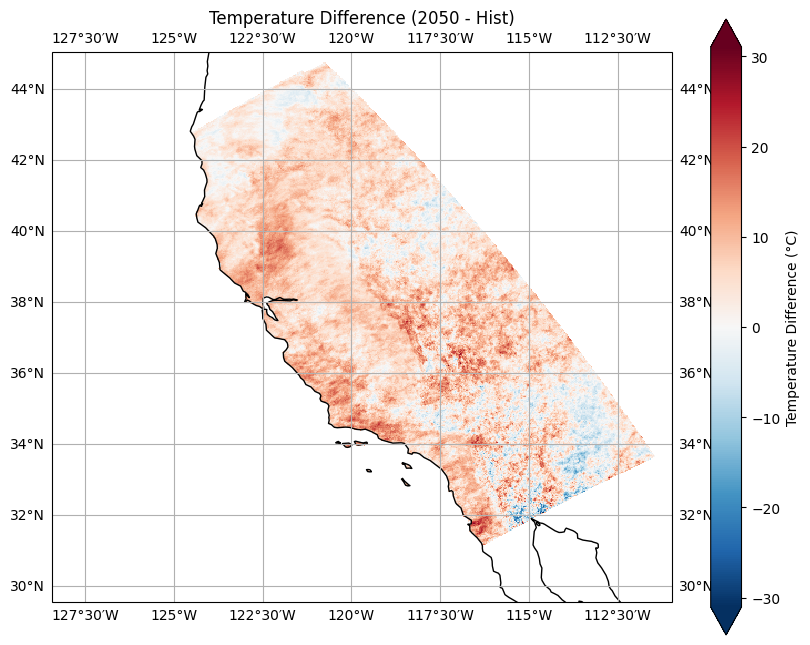

In [344]:
# Define file paths
file1_path = 'VCP_FLOOD_PctExtreme95_01A-1_1950-2014_ACCESS.nc'
file2_path = 'VCP_FLOOD_PctExtreme95_01A-1_2045-2074_ACCESS.nc'
output_diff_path = 'VCP_FLOOD_Diff-PctExtreme95_01A-1_2045-2074_ACCESS.nc' # Optional: to save the difference

# --- 2. Load the NetCDF files ---
try:
    ds1 = xr.open_dataset(file1_path)
    ds2 = xr.open_dataset(file2_path)
    print(f"\nLoaded {file1_path}:\n{ds1}")
    print(f"\nLoaded {file2_path}:\n{ds2}")

except FileNotFoundError:
    print(f"Error: Make sure '{file1_path}' and '{file2_path}' exist.")
    print("If you just ran the dummy file creation, this shouldn't happen.")
    exit()
except Exception as e:
    print(f"An error occurred while loading files: {e}")
    exit()

# --- 3. Perform the subtraction ---
# Assuming the variable name is 'temperature' in both files
# And that their dimensions (lat, lon) align. Xarray handles this smartly.
try:
    # Subtracting the datasets directly if they have the same structure and variable names
    # Or, subtract specific DataArrays: ds1['temperature'] - ds2['temperature']
    temperature_difference = ds2['total_extreme_precipitation_div_by_total_precipitation_scaled'] - ds1['total_extreme_precipitation_div_by_total_precipitation_scaled']
    print(f"\nCalculated temperature difference:\n{temperature_difference}")

    # Optional: Save the difference to a new NetCDF file
    temperature_difference.to_netcdf(output_diff_path)
    print(f"\nSaved difference to {output_diff_path}")

except KeyError:
    print("Error: 'temperature' variable not found in one or both NetCDF files.")
    print(f"Variables in {file1_path}: {list(ds1.data_vars)}")
    print(f"Variables in {file2_path}: {list(ds2.data_vars)}")
    exit()
except Exception as e:
    print(f"An error occurred during subtraction: {e}")
    exit()

# --- 4. Map the output ---

# Set up the plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()) # Using Plate Carree for simple lat/lon

# Plot the data
# Use .plot() method from xarray DataArray for quick plotting.
# vmax and vmin can be set for consistent color scaling, especially if differences can be negative.
# cmap can be chosen to represent divergence (e.g., 'RdBu_r' for cool/warm differences).
plot = temperature_difference.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r', # Red-Blue reversed colormap, good for differences
    cbar_kwargs={'label': 'Temperature Difference (°C)'},
    extend='both' # Extends colorbar to show values outside the range if any
)

# Add map features
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.set_title('Temperature Difference (2050 - Hist)')

plt.show()

In [346]:
#VCP_FLOOD_PctExtreme95_01A_GENUSE-AVE_2015-2044

In [355]:
import xarray as xr

# Define the path to your NetCDF file
file_path = 'VCP_FLOOD_PctExtreme95_01A_GENUSE-AVE_2015-2044.nc' # Replace 'your_file.nc' with the actual file path

try:
    # Load the NetCDF dataset
    ds = xr.open_dataset(file_path)

    # Check if the 'quantile' variable exists
    if 'quantile' in ds.variables:
        # Remove the 'quantile' variable
        ds_modified = ds.drop_vars('quantile')
        print("Variable 'quantile' removed successfully.")

        # If you want to save the modified dataset to a new file:
        ds_modified.to_netcdf('VCP_FLOOD_PctExtreme95_01A_GENUSE-AVE_2015-2044_noQuantile.nc')
        print("Modified dataset saved to 'VCP_FLOOD_PctExtreme95_01A_GENUSE-AVE_2015-2044_noQuantile.nc'")

        # You can now work with ds_modified
        print("\nModified dataset summary:")
        print(ds_modified)

    else:
        print("Variable 'quantile' not found in the dataset.")
        print("\nOriginal dataset summary:")
        print(ds)

except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

Variable 'quantile' removed successfully.
Modified dataset saved to 'VCP_FLOOD_PctExtreme95_01A_GENUSE-AVE_2015-2044_noQuantile.nc'

Modified dataset summary:
<xarray.Dataset> Size: 2MB
Dimensions:                                                             (
                                                                         lat: 495,
                                                                         lon: 559)
Coordinates:
  * lat                                                                 (lat) float32 2kB ...
  * lon                                                                 (lon) float32 2kB ...
Data variables:
    total_extreme_precipitation_div_by_total_precipitation_scaled_mean  (lat, lon) float64 2MB ...
Attributes:
    history:  Averaged from 6 files. Original files pattern: VCP_FLOOD_PctExt...


In [357]:
import xarray as xr

# Define the path to your NetCDF file
file_path = 'VCP_FLOOD_PctExtreme95_01B_GENUSE-AVE_2045-2074.nc' # Replace 'your_file.nc' with the actual file path

try:
    # Load the NetCDF dataset
    ds = xr.open_dataset(file_path)

    # Check if the 'quantile' variable exists
    if 'quantile' in ds.variables:
        # Remove the 'quantile' variable
        ds_modified = ds.drop_vars('quantile')
        print("Variable 'quantile' removed successfully.")

        # If you want to save the modified dataset to a new file:
        ds_modified.to_netcdf('VCP_FLOOD_PctExtreme95_01B_GENUSE-AVE_2045-2074_noQuantile.nc')
        print("Modified dataset saved to 'VCP_FLOOD_PctExtreme95_01B_GENUSE-AVE_2045-2074_noQuantile.nc'")

        # You can now work with ds_modified
        print("\nModified dataset summary:")
        print(ds_modified)

    else:
        print("Variable 'quantile' not found in the dataset.")
        print("\nOriginal dataset summary:")
        print(ds)

except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

Variable 'quantile' removed successfully.
Modified dataset saved to 'VCP_FLOOD_PctExtreme95_01B_GENUSE-AVE_2045-2074_noQuantile.nc'

Modified dataset summary:
<xarray.Dataset> Size: 2MB
Dimensions:                                                             (
                                                                         lat: 495,
                                                                         lon: 559)
Coordinates:
  * lat                                                                 (lat) float32 2kB ...
  * lon                                                                 (lon) float32 2kB ...
Data variables:
    total_extreme_precipitation_div_by_total_precipitation_scaled_mean  (lat, lon) float64 2MB ...
Attributes:
    history:  Averaged from 5 files. Original files pattern: VCP_FLOOD_PctExt...


In [363]:
import xarray as xr
import rioxarray # Extends xarray with rio accessor

# 1. Define file paths
netcdf_file_path = 'VCP_FLOOD_PctExtreme95_01A_GENUSE-AVE_2015-2044_NoQuantile.nc'  # Replace with your NetCDF file
geotiff_file_path = 'VCP_FLOOD_PctExtreme95_01A_GENUSE-AVE_2015-2044.tif' # Replace with your desired output GeoTIFF name
variable_name = 'total_extreme_precipitation_div_by_total_precipitation_scaled_mean' # IMPORTANT: Replace with the variable you want to export

try:
    # 2. Open the NetCDF dataset
    ds = xr.open_dataset(netcdf_file_path)

    data_array_to_inspect = ds[variable_name] # Use your actual variable name
    print(f"\n--- Inspecting variable: {variable_name} ---")
    print("Dimensions of this variable:", data_array_to_inspect.dims)
    print("Coordinates available for this variable:", list(data_array_to_inspect.coords))
    print("--------------------------------------------")

    # Also print general coordinates of the dataset, as spatial dims might be there
    print("\n--- General Dataset Coordinates ---")
    print(list(ds.coords))
    print("---------------------------------")
    
    # --- Optional: Inspect the dataset ---
    print("--- Dataset Information ---")
    print(ds)
    print("\n--- Data Variables ---")
    print(list(ds.data_vars))
    print("\n--- Coordinates ---")
    print(list(ds.coords))
    # --- End Inspect ---

    # 3. Select the DataArray (variable) to export
    # Ensure the variable_name you specified exists in the dataset
    if variable_name not in ds.data_vars:
        raise ValueError(f"Variable '{variable_name}' not found in the NetCDF file. "
                         f"Available variables are: {list(ds.data_vars)}")
    data_array = ds[variable_name]

    # 4. Handle additional dimensions (e.g., time, level)
    # If your data has more than two spatial dimensions (e.g., time, elevation),
    # you need to select a specific slice.
    # Example: Select the first time step if a 'time' dimension exists
    if 'time' in data_array.dims:
        print("\nSelecting the first time step.")
        data_array = data_array.isel(time=0) # Selects the first time slice
    # Example: Select a specific level if a 'level' or 'depth' dimension exists
    # if 'level' in data_array.dims:
    #     print("\nSelecting the first level.")
    #     data_array = data_array.isel(level=0)

    # Ensure the DataArray is 2D or 3D (with bands as the first dimension)
    if data_array.ndim == 3:
        # Assuming the first dimension is 'band' for multi-band GeoTIFF
        # If not, you might need to transpose, e.g., data_array.transpose('band', 'y', 'x')
        print(f"\nData array has 3 dimensions: {data_array.dims}. Assuming the first is 'band'.")
    elif data_array.ndim != 2:
        raise ValueError(f"DataArray must be 2D (or 3D with bands as first dim) for GeoTIFF export, "
                         f"but got {data_array.ndim} dimensions: {data_array.dims}. "
                         "Please select appropriate slices for non-spatial dimensions.")

    # 5. Ensure geospatial information is set (rioxarray often infers this)
    # rioxarray will try to automatically parse CRS and coordinates.
    # If it fails, you might need to set it manually, e.g.:
    # data_array = data_array.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
    # data_array = data_array.rio.write_crs("EPSG:4326", inplace=True) # Example: WGS84

    # Check if CRS is present, if not, you might need to add it
    if data_array.rio.crs is None:
        print("\nCRS not found. Attempting to write without explicit CRS, or you might need to set it.")
        # Example: If you know it's WGS84 latitude/longitude
        # data_array = data_array.rio.set_spatial_dims(x_dim='longitude', y_dim='latitude') # Adjust dim names if needed
        # data_array.rio.write_crs("EPSG:4326", inplace=True)
        # print("Assigned EPSG:4326 (WGS84) as CRS. Verify this is correct for your data.")


    # 6. Set NoData value if applicable (rioxarray tries to get it from _FillValue)
    if hasattr(data_array, '_FillValue'):
        nodata_val = data_array.attrs['_FillValue']
        data_array = data_array.rio.write_nodata(nodata_val, encoded=True, inplace=True)
        print(f"\nSetting NoData value from _FillValue attribute: {nodata_val}")
    elif data_array.dtype.kind == 'f': # Common for float data
        # pass # or set a common one like np.nan if appropriate after checking data
        pass


    # 7. Export to GeoTIFF
    print(f"\nExporting variable '{variable_name}' to '{geotiff_file_path}'...")
    data_array.rio.to_raster(geotiff_file_path)
    print("Export complete.")

except FileNotFoundError:
    print(f"Error: NetCDF file not found at '{netcdf_file_path}'")
except ValueError as ve:
    print(f"ValueError: {ve}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    print("Make sure your NetCDF file has appropriate coordinate variables (e.g., lat, lon or x, y)")
    print("and that the selected variable is suitable for 2D raster export.")


--- Inspecting variable: total_extreme_precipitation_div_by_total_precipitation_scaled_mean ---
Dimensions of this variable: ('lat', 'lon')
Coordinates available for this variable: ['lat', 'lon']
--------------------------------------------

--- General Dataset Coordinates ---
['lat', 'lon']
---------------------------------
--- Dataset Information ---
<xarray.Dataset> Size: 2MB
Dimensions:                                                             (
                                                                         lat: 495,
                                                                         lon: 559)
Coordinates:
  * lat                                                                 (lat) float32 2kB ...
  * lon                                                                 (lon) float32 2kB ...
Data variables:
    total_extreme_precipitation_div_by_total_precipitation_scaled_mean  (lat, lon) float64 2MB ...
Attributes:
    history:  Averaged from 6 files. Original fil